


<p style="font-size:36px;text-align:center"> <b>Personalized cancer diagnosis</b> </p>

<h1>1. Business Problem</h1>

<h2>1.1. Description</h2>

<p> Source: https://www.kaggle.com/c/msk-redefining-cancer-treatment/ </p>

<h6> Problem statement : </h6>
<p> Classify the given genetic variations/mutations based on evidence from text-based clinical literature. </p>

<h2>1.3. Real-world/Business objectives and constraints.</h2>

* No low-latency requirement.
* Interpretability is important.
* Errors can be very costly.
* Probability of a data-point belonging to each class is needed.

<h1>2. Machine Learning Problem Formulation</h1>

<h2>2.1. Data</h2>

<h6>training_variants</h6>
<hr>
ID,Gene,Variation,Class<br>
0,FAM58A,Truncating Mutations,1 <br>
1,CBL,W802*,2 <br>
2,CBL,Q249E,2 <br>
...

<h6> training_text</h6>
<hr>
ID,Text <br>
0||Cyclin-dependent kinases (CDKs) regulate a variety of fundamental cellular processes. CDK10 stands out as one of the last orphan CDKs for which no activating cyclin has been identified and no kinase activity revealed. Previous work has shown that CDK10 silencing increases ETS2 (v-ets erythroblastosis virus E26 oncogene homolog 2)-driven activation of the MAPK pathway, which confers tamoxifen resistance to breast cancer cells. The precise mechanisms by which CDK10 modulates ETS2 activity, and more generally the functions of CDK10, remain elusive. Here we demonstrate that CDK10 is a cyclin-dependent kinase by identifying cyclin M as an activating cyclin. Cyclin M, an orphan cyclin, is the product of FAM58A, whose mutations cause STAR syndrome, a human developmental anomaly whose features include toe syndactyly, telecanthus, and anogenital and renal malformations. We show that STAR syndrome-associated cyclin M mutants are unable to interact with CDK10. Cyclin M silencing phenocopies CDK10 silencing in increasing c-Raf and in conferring tamoxifen resistance to breast cancer cells. CDK10/cyclin M phosphorylates ETS2 in vitro, and in cells it positively controls ETS2 degradation by the proteasome. ETS2 protein levels are increased in cells derived from a STAR patient, and this increase is attributable to decreased cyclin M levels. Altogether, our results reveal an additional regulatory mechanism for ETS2, which plays key roles in cancer and development. They also shed light on the molecular mechanisms underlying STAR syndrome.Cyclin-dependent kinases (CDKs) play a pivotal role in the control of a number of fundamental cellular processes (1). The human genome contains 21 genes encoding proteins that can be considered as members of the CDK family owing to their sequence similarity with bona fide CDKs, those known to be activated by cyclins (2). Although discovered almost 20 y ago (3, 4), CDK10 remains one of the two CDKs without an identified cyclin partner. This knowledge gap has largely impeded the exploration of its biological functions. CDK10 can act as a positive cell cycle regulator in some cells (5, 6) or as a tumor suppressor in others (7, 8). CDK10 interacts with the ETS2 (v-ets erythroblastosis virus E26 oncogene homolog 2) transcription factor and inhibits its transcriptional activity through an unknown mechanism (9). CDK10 knockdown derepresses ETS2, which increases the expression of the c-Raf protein kinase, activates the MAPK pathway, and induces resistance of MCF7 cells to tamoxifen (6). ... 

<h2>2.2. Mapping the real-world problem to an ML problem</h2>

<h3>2.2.1. Type of Machine Learning Problem</h3>

<p>
    
            There are nine different classes a genetic mutation can be classified into => Multi class classification problem
   
      
    
</p>

<h3>2.2.2. Performance Metric</h3>

Source: https://www.kaggle.com/c/msk-redefining-cancer-treatment#evaluation

Metric(s): 
* Multi class log-loss 
* Confusion matrix 


<h3>2.2.3. Machine Learing Objectives and Constraints</h3>

<p> Objective: Predict the probability of each data-point belonging to each of the nine classes.
</p>
<p> Constraints:
</p>
* Interpretability
* Class probabilities are needed.
* Penalize the errors in class probabilites => Metric is Log-loss.
* No Latency constraints.

<h2>2.3. Train, CV and Test Datasets</h2>

 Split the dataset randomly into three parts train, cross validation and test with 64%,16%, 20% of data respectively

<h1>3. Exploratory Data Analysis</h1>

In [490]:
pip install imbalanced-learn

Note: you may need to restart the kernel to use updated packages.


In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import re
import time
import warnings
import numpy as np
from nltk.corpus import stopwords
from sklearn.decomposition import TruncatedSVD
from sklearn.preprocessing import normalize
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.manifold import TSNE
import seaborn as sns
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import confusion_matrix
from sklearn.metrics import log_loss
from sklearn.metrics import accuracy_score
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import SGDClassifier
from imblearn.over_sampling import SMOTE
from collections import Counter
from scipy.sparse import hstack
from sklearn.multiclass import OneVsRestClassifier
from sklearn.svm import SVC
from sklearn.model_selection import StratifiedKFold
from collections import Counter, defaultdict
from sklearn.calibration import CalibratedClassifierCV
from sklearn.naive_bayes import MultinomialNB
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
import math
from sklearn.metrics import normalized_mutual_info_score
from sklearn.ensemble import RandomForestClassifier
warnings.filterwarnings("ignore")

from sklearn.ensemble import StackingClassifier

from sklearn import model_selection
from sklearn.linear_model import LogisticRegression


<h2>3.1. Reading Data</h2>

<h3>3.1.1. Reading Gene and Variation Data</h3>

In [6]:
data = pd.read_csv('training_variants')
print('Number of data points : ', data.shape[0])
print('Number of features : ', data.shape[1])
print('Features : ', data.columns.values)
data.head()

Number of data points :  3321
Number of features :  4
Features :  ['ID' 'Gene' 'Variation' 'Class']


,ID,Gene,Variation,Class
0,0,FAM58A,Truncating Mutations,1
1,1,CBL,W802*,2
2,2,CBL,Q249E,2
3,3,CBL,N454D,3
4,4,CBL,L399V,4


<p>
    training/training_variants is a comma separated file containing the description of the genetic mutations used for training. <br>
    Fields are 
    <ul>
        <li><b>ID : </b>the id of the row used to link the mutation to the clinical evidence</li>
        <li><b>Gene : </b>the gene where this genetic mutation is located </li>
        <li><b>Variation : </b>the aminoacid change for this mutations </li>
        <li><b>Class :</b> 1-9 the class this genetic mutation has been classified on</li>
    </ul>

<h3>3.1.2. Reading Text Data</h3>

In [7]:
# note the seprator in this file
data_text =pd.read_csv("training_text",sep="\|\|",engine="python",names=["ID","TEXT"],skiprows=1)
print('Number of data points : ', data_text.shape[0])
print('Number of features : ', data_text.shape[1])
print('Features : ', data_text.columns.values)
data_text.head()

Number of data points :  3321
Number of features :  2
Features :  ['ID' 'TEXT']


,ID,TEXT
0,0,Cyclin-dependent kinases (CDKs) regulate a var...
1,1,Abstract Background Non-small cell lung canc...
2,2,Abstract Background Non-small cell lung canc...
3,3,Recent evidence has demonstrated that acquired...
4,4,Oncogenic mutations in the monomeric Casitas B...


<h3>3.1.3. Preprocessing of text</h3>

In [8]:
# loading stop words from nltk library
stop_words = set(stopwords.words('english'))


def nlp_preprocessing(total_text, index, column):
    if type(total_text) is not int:
        string = ""
        # replace every special char with space
        total_text = re.sub('[^a-zA-Z0-9\n]', ' ', total_text)
        # replace multiple spaces with single space
        total_text = re.sub('\s+',' ', total_text)
        # converting all the chars into lower-case.
        total_text = total_text.lower()
        
        for word in total_text.split():
        # if the word is a not a stop word then retain that word from the data
            if not word in stop_words:
                string += word + " "
        
        data_text[column][index] = string

In [9]:
#text processing stage.
start_time = time.time()
for index, row in data_text.iterrows():
    if type(row['TEXT']) is str:
        nlp_preprocessing(row['TEXT'], index, 'TEXT')
    else:
        print("there is no text description for id:",index)
print('Time took for preprocessing the text :',time.time() - start_time, "seconds")

there is no text description for id: 1109
there is no text description for id: 1277
there is no text description for id: 1407
there is no text description for id: 1639
there is no text description for id: 2755
Time took for preprocessing the text : 60.43599796295166 seconds


In [10]:
#merging both gene_variations and text data based on ID
result = pd.merge(data, data_text,on='ID', how='left')
result.head()

,ID,Gene,Variation,Class,TEXT
0,0,FAM58A,Truncating Mutations,1,cyclin dependent kinases cdks regulate variety...
1,1,CBL,W802*,2,abstract background non small cell lung cancer...
2,2,CBL,Q249E,2,abstract background non small cell lung cancer...
3,3,CBL,N454D,3,recent evidence demonstrated acquired uniparen...
4,4,CBL,L399V,4,oncogenic mutations monomeric casitas b lineag...


In [11]:
result.isnull().sum()

ID           0
Gene         0
Variation    0
Class        0
TEXT         5
dtype: int64

In [12]:
result.loc[result['TEXT'].isnull(),'TEXT'] = result['Gene'] +' '+result['Variation']

In [13]:
result[result['ID']==1109]

,ID,Gene,Variation,Class,TEXT
1109,1109,FANCA,S1088F,1,FANCA S1088F


In [14]:
result=result.drop(columns='ID')

<h3>3.1.4. Test, Train and Cross Validation Split</h3>

<h4>3.1.4.1. Splitting data into train, test and cross validation (64:20:16)</h4>

In [15]:
y_true = result['Class'].values
result.Gene      = result.Gene.str.replace('\s+', '_')
result.Variation = result.Variation.str.replace('\s+', '_')
# split the data into test and train by maintaining same distribution of output varaible 'y_true' [stratify=y_true]
X_train, test_df, y_train, y_test = train_test_split(result, y_true, stratify=y_true, test_size=0.2)
# split the train data into train and cross validation by maintaining same distribution of output varaible 'y_train' [stratify=y_train]
train_df, cv_df, y_train, y_cv = train_test_split(X_train, y_train, stratify=y_train, test_size=0.2)

<p> We split the data into train, test and cross validation data sets, preserving the ratio of class distribution in the original data set  </p>

In [16]:
print('Number of data points in train data:', train_df.shape[0])
print('Number of data points in test data:', test_df.shape[0])
print('Number of data points in cross validation data:', cv_df.shape[0])

Number of data points in train data: 2124
Number of data points in test data: 665
Number of data points in cross validation data: 532


<h4>3.1.4.2. Distribution of y_i's in Train, Test and Cross Validation datasets</h4>

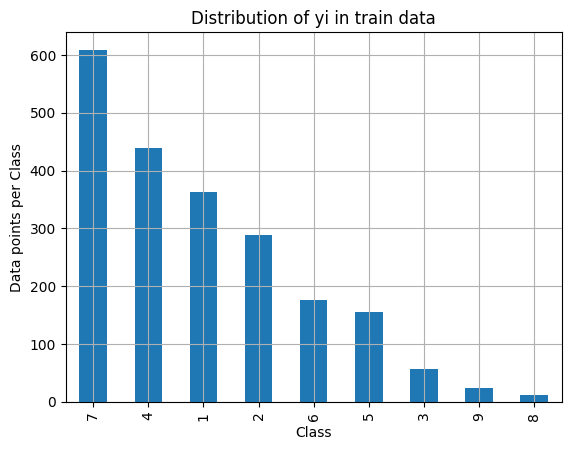

Number of data points in class 1 : 609 ( 28.672 %)
Number of data points in class 2 : 439 ( 20.669 %)
Number of data points in class 3 : 363 ( 17.09 %)
Number of data points in class 4 : 289 ( 13.606 %)
Number of data points in class 5 : 176 ( 8.286 %)
Number of data points in class 6 : 155 ( 7.298 %)
Number of data points in class 7 : 57 ( 2.684 %)
Number of data points in class 8 : 24 ( 1.13 %)
Number of data points in class 9 : 12 ( 0.565 %)
--------------------------------------------------------------------------------


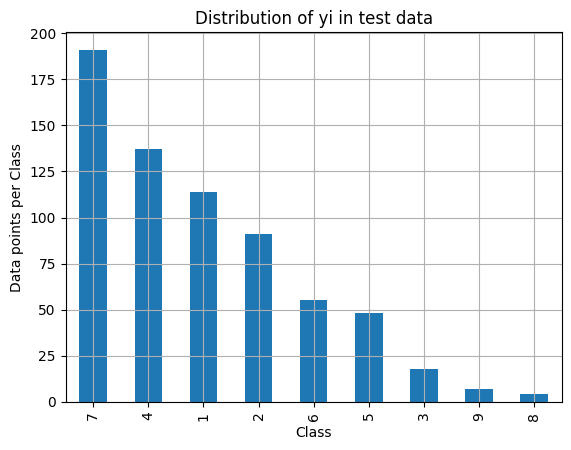

Number of data points in class 1 : 191 ( 28.722 %)
Number of data points in class 2 : 137 ( 20.602 %)
Number of data points in class 3 : 114 ( 17.143 %)
Number of data points in class 4 : 91 ( 13.684 %)
Number of data points in class 5 : 55 ( 8.271 %)
Number of data points in class 6 : 48 ( 7.218 %)
Number of data points in class 7 : 18 ( 2.707 %)
Number of data points in class 8 : 7 ( 1.053 %)
Number of data points in class 9 : 4 ( 0.602 %)
--------------------------------------------------------------------------------


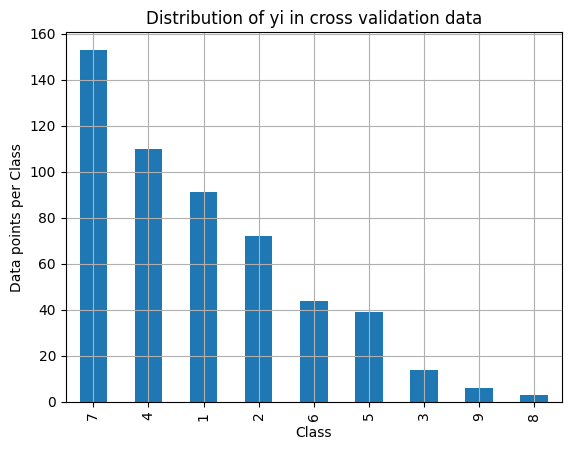

Number of data points in class 1 : 153 ( 28.759 %)
Number of data points in class 2 : 110 ( 20.677 %)
Number of data points in class 3 : 91 ( 17.105 %)
Number of data points in class 4 : 72 ( 13.534 %)
Number of data points in class 5 : 44 ( 8.271 %)
Number of data points in class 6 : 39 ( 7.331 %)
Number of data points in class 7 : 14 ( 2.632 %)
Number of data points in class 8 : 6 ( 1.128 %)
Number of data points in class 9 : 3 ( 0.564 %)


In [18]:
# it returns a dict, keys as class labels and values as the number of data points in that class
train_class_distribution = train_df['Class'].value_counts()
test_class_distribution = test_df['Class'].value_counts()
cv_class_distribution = cv_df['Class'].value_counts()

my_colors = 'rgbkymc'
train_class_distribution.plot(kind='bar')
plt.xlabel('Class')
plt.ylabel('Data points per Class')
plt.title('Distribution of yi in train data')
plt.grid()
plt.show()

# ref: argsort https://docs.scipy.org/doc/numpy/reference/generated/numpy.argsort.html
# -(train_class_distribution.values): the minus sign will give us in decreasing order
sorted_yi = np.argsort(-train_class_distribution.values)
for i in sorted_yi:
    print('Number of data points in class', i+1, ':',train_class_distribution.values[i], '(', np.round((train_class_distribution.values[i]/train_df.shape[0]*100), 3), '%)')

    
print('-'*80)
my_colors = 'rgbkymc'
test_class_distribution.plot(kind='bar')
plt.xlabel('Class')
plt.ylabel('Data points per Class')
plt.title('Distribution of yi in test data')
plt.grid()
plt.show()

# ref: argsort https://docs.scipy.org/doc/numpy/reference/generated/numpy.argsort.html
# -(train_class_distribution.values): the minus sign will give us in decreasing order
sorted_yi = np.argsort(-test_class_distribution.values)
for i in sorted_yi:
    print('Number of data points in class', i+1, ':',test_class_distribution.values[i], '(', np.round((test_class_distribution.values[i]/test_df.shape[0]*100), 3), '%)')

print('-'*80)
my_colors = 'rgbkymc'
cv_class_distribution.plot(kind='bar')
plt.xlabel('Class')
plt.ylabel('Data points per Class')
plt.title('Distribution of yi in cross validation data')
plt.grid()
plt.show()

# ref: argsort https://docs.scipy.org/doc/numpy/reference/generated/numpy.argsort.html
# -(train_class_distribution.values): the minus sign will give us in decreasing order
sorted_yi = np.argsort(-train_class_distribution.values)
for i in sorted_yi:
    print('Number of data points in class', i+1, ':',cv_class_distribution.values[i], '(', np.round((cv_class_distribution.values[i]/cv_df.shape[0]*100), 3), '%)')


1. Our Data is imbalanced

2. For a machine learning model, we need distribution of classes in train, cv and test to be same, i.e. same proportion of classes should be sampled to each train, cv and test because of random samplimg

In our case, the Distribution of class labels in train, cv and test data is same

<h2>3.2 Prediction using a 'Random' Model</h2>

<p style="font-size:16px"> In a 'Random' Model, we generate the NINE class probabilites randomly such that they sum to 1. </p>

In [19]:
# This function plots the confusion matrices given y_i, y_i_hat.
# We can also use crosstab
def plot_confusion_matrix(test_y, predict_y):
    C = confusion_matrix(test_y, predict_y)
    # C = 9,9 matrix, each cell (i,j) represents number of points of class i are predicted class j
    
    A =(((C.T)/(C.sum(axis=1))).T)
    #divid each element of the confusion matrix with the sum of elements in that column
    
    # C = [[1, 2],
    #     [3, 4]]
    # C.T = [[1, 3],
    #        [2, 4]]
    # C.sum(axis = 1)  axis=0 corresonds to columns and axis=1 corresponds to rows in two diamensional array
    # C.sum(axix =1) = [[3, 7]]
    # ((C.T)/(C.sum(axis=1))) = [[1/3, 3/7]
    #                           [2/3, 4/7]]

    # ((C.T)/(C.sum(axis=1))).T = [[1/3, 2/3]
    #                           [3/7, 4/7]]
    # sum of row elements = 1
    
    B =(C/C.sum(axis=0))
    #divid each element of the confusion matrix with the sum of elements in that row
    # C = [[1, 2],
    #     [3, 4]]
    # C.sum(axis = 0)  axis=0 corresonds to columns and axis=1 corresponds to rows in two diamensional array
    # C.sum(axix =0) = [[4, 6]]
    # (C/C.sum(axis=0)) = [[1/4, 2/6],
    #                      [3/4, 4/6]] 
    
    labels = [1,2,3,4,5,6,7,8,9]
    # representing A in heatmap format
    print("-"*20, "Confusion matrix", "-"*20)
    plt.figure(figsize=(20,7))
    sns.heatmap(C, annot=True, cmap="YlGnBu", fmt=".3f", xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted Class')
    plt.ylabel('Original Class')
    plt.show()

    print("-"*20, "Precision matrix (Columm Sum=1)", "-"*20)
    plt.figure(figsize=(20,7))
    sns.heatmap(B, annot=True, cmap="YlGnBu", fmt=".3f", xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted Class')
    plt.ylabel('Original Class')
    plt.show()
    
    # representing B in heatmap format
    print("-"*20, "Recall matrix (Row sum=1)", "-"*20)
    plt.figure(figsize=(20,7))
    sns.heatmap(A, annot=True, cmap="YlGnBu", fmt=".3f", xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted Class')
    plt.ylabel('Original Class')
    plt.show()

Log loss on Cross Validation Data using Random Model 2.5250365546783167
Log loss on Test Data using Random Model 2.467227794341375
-------------------- Confusion matrix --------------------


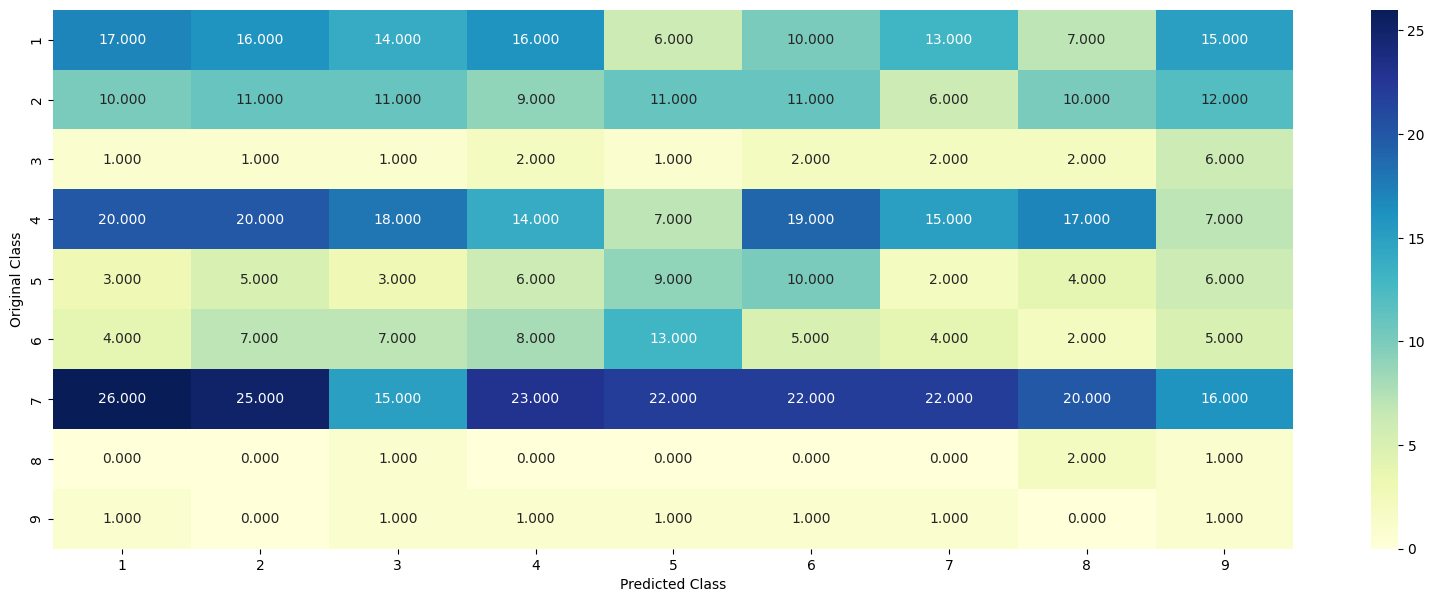

-------------------- Precision matrix (Columm Sum=1) --------------------


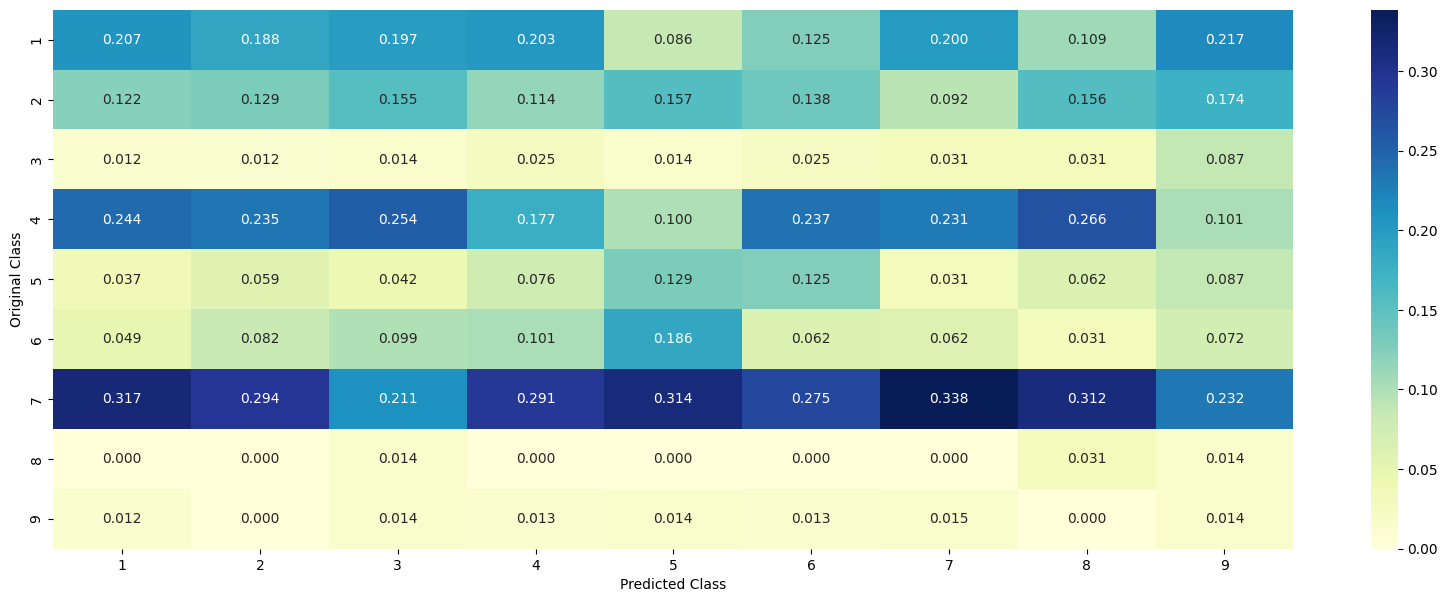

-------------------- Recall matrix (Row sum=1) --------------------


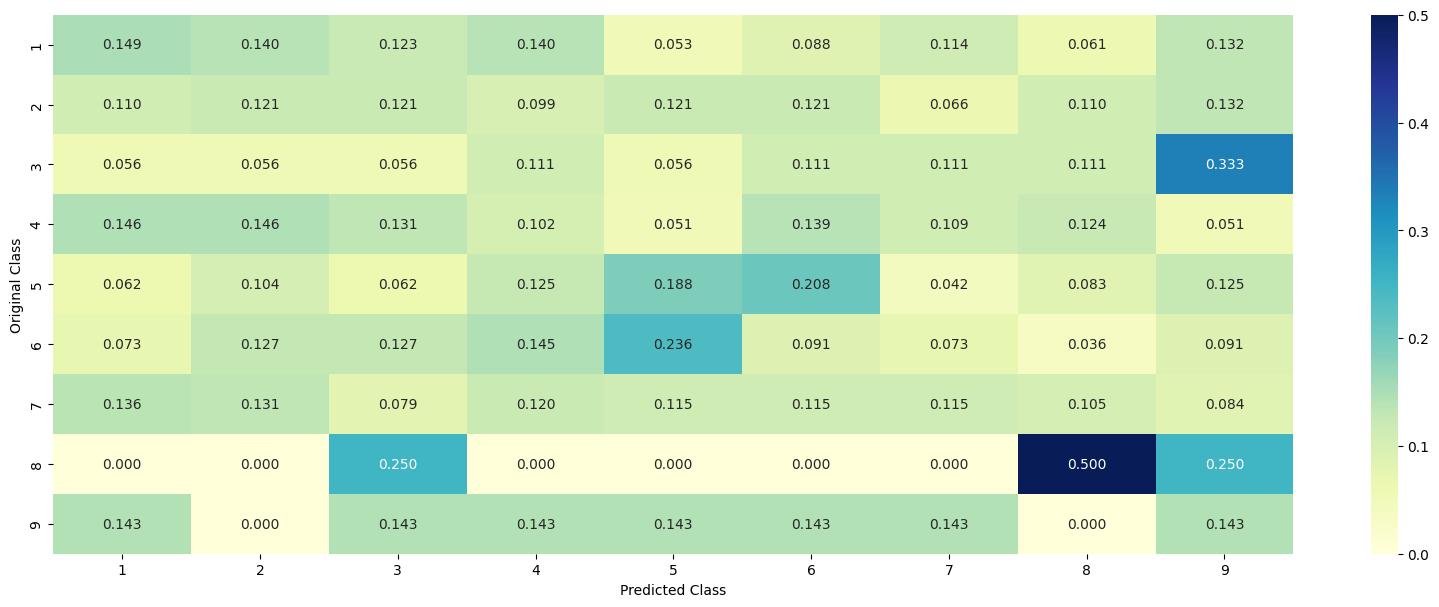

In [719]:
# we need to generate 9 numbers and the sum of numbers should be 1
# one solution is to genarate 9 numbers and divide each of the numbers by their sum
# ref: https://stackoverflow.com/a/18662466/4084039
test_data_len = test_df.shape[0]
cv_data_len = cv_df.shape[0]

# we create a output array that has exactly same size as the CV data
cv_predicted_y = np.zeros((cv_data_len,9))
for i in range(cv_data_len):
    rand_probs = np.random.rand(9)
    cv_predicted_y[i] = (rand_probs/sum(rand_probs))
print("Log loss on Cross Validation Data using Random Model",log_loss(y_cv,cv_predicted_y, eps=1e-15))


# Test-Set error.
#we create a output array that has exactly same as the test data
test_predicted_y = np.zeros((test_data_len,9))
for i in range(test_data_len):
    rand_probs = np.random.rand(1,9)
    test_predicted_y[i] = ((rand_probs/sum(sum(rand_probs)))[0])
print("Log loss on Test Data using Random Model",log_loss(y_test,test_predicted_y, eps=1e-15))

predicted_y =np.argmax(test_predicted_y, axis=1)
plot_confusion_matrix(y_test, predicted_y+1) # we can also use crosstab

<h2>3.3 Univariate Analysis</h2>

In [20]:
# code for response coding with Laplace smoothing.
# alpha : used for laplace smoothing
# feature: ['gene', 'variation']
# df: ['train_df', 'test_df', 'cv_df']
# algorithm
# ----------
# Consider all unique values and the number of occurances of given feature in train data dataframe
# build a vector (1*9) , the first element = (number of times it occured in class1 + 10*alpha / number of time it occurred in total data+90*alpha)
# gv_dict is like a look up table, for every gene it store a (1*9) representation of it
# for a value of feature in df:
# if it is in train data:
# we add the vector that was stored in 'gv_dict' look up table to 'gv_fea'
# if it is not there is train:
# we add [1/9, 1/9, 1/9, 1/9,1/9, 1/9, 1/9, 1/9, 1/9] to 'gv_fea'
# return 'gv_fea'
# ----------------------

# get_gv_fea_dict: Get Gene varaition Feature Dict
def get_gv_fea_dict(alpha, feature, df):
    # value_count: it contains a dict like
    # print(train_df['Gene'].value_counts())
    # output:
    #        {BRCA1      174
    #         TP53       106
    #         EGFR        86
    #         BRCA2       75
    #         PTEN        69
    #         KIT         61
    #         BRAF        60
    #         ERBB2       47
    #         PDGFRA      46
    #         ...}
    # print(train_df['Variation'].value_counts())
    # output:
    # {
    # Truncating_Mutations                     63
    # Deletion                                 43
    # Amplification                            43
    # Fusions                                  22
    # Overexpression                            3
    # E17K                                      3
    
    # Q61L                                      3
    # S222D                                     2
    # P130S                                     2
    # ...
    # }
    value_count = df[feature].value_counts()
    
    # gv_dict : Gene Variation Dict, which contains the probability array for each gene/variation
    gv_dict = dict()
    
    # denominator will contain the number of time that particular feature occured in whole data
    for i, denominator in value_count.items():
        # vec will contain (p(yi==1/Gi) probability of gene/variation belongs to perticular class
        # vec is 9 diamensional vector
        vec = []
        for k in range(1,10):
            # print(train_df.loc[(train_df['Class']==1) & (train_df['Gene']=='BRCA1')])
            #         ID   Gene             Variation  Class  
            # 2470  2470  BRCA1                S1715C      1   
            # 2486  2486  BRCA1                S1841R      1   
            # 2614  2614  BRCA1                   M1R      1   
            # 2432  2432  BRCA1                L1657P      1   
            # 2567  2567  BRCA1                T1685A      1   
            # 2583  2583  BRCA1                E1660G      1   
            # 2634  2634  BRCA1                W1718L      1   
            # cls_cnt.shape[0] will return the number of rows

            cls_cnt = df.loc[(df['Class']==k) & (df[feature]==i)]
            
            # cls_cnt.shape[0](numerator) will contain the number of time that particular feature occured in whole data
            vec.append((cls_cnt.shape[0] + alpha*10)/ (denominator + 90*alpha))

        # we are adding the gene/variation to the dict as key and vec as value
        gv_dict[i]=vec
    return gv_dict

# Get Gene variation feature
def get_gv_feature(alpha, feature, df):
    # print(gv_dict)
    #     {'BRCA1': [0.20075757575757575, 0.03787878787878788, 0.068181818181818177, 0.13636363636363635, 0.25, 0.19318181818181818, 0.03787878787878788, 0.03787878787878788, 0.03787878787878788], 
    #      'TP53': [0.32142857142857145, 0.061224489795918366, 0.061224489795918366, 0.27040816326530615, 0.061224489795918366, 0.066326530612244902, 0.051020408163265307, 0.051020408163265307, 0.056122448979591837], 
    #      'EGFR': [0.056818181818181816, 0.21590909090909091, 0.0625, 0.068181818181818177, 0.068181818181818177, 0.0625, 0.34659090909090912, 0.0625, 0.056818181818181816], 
    #      'BRCA2': [0.13333333333333333, 0.060606060606060608, 0.060606060606060608, 0.078787878787878782, 0.1393939393939394, 0.34545454545454546, 0.060606060606060608, 0.060606060606060608, 0.060606060606060608], 
    #      'PTEN': [0.069182389937106917, 0.062893081761006289, 0.069182389937106917, 0.46540880503144655, 0.075471698113207544, 0.062893081761006289, 0.069182389937106917, 0.062893081761006289, 0.062893081761006289], 
    #      'KIT': [0.066225165562913912, 0.25165562913907286, 0.072847682119205295, 0.072847682119205295, 0.066225165562913912, 0.066225165562913912, 0.27152317880794702, 0.066225165562913912, 0.066225165562913912], 
    #      'BRAF': [0.066666666666666666, 0.17999999999999999, 0.073333333333333334, 0.073333333333333334, 0.093333333333333338, 0.080000000000000002, 0.29999999999999999, 0.066666666666666666, 0.066666666666666666],
    #      ...
    #     }
    gv_dict = get_gv_fea_dict(alpha, feature, df)
    # value_count is similar in get_gv_fea_dict
    value_count = df[feature].value_counts()
    
    # gv_fea: Gene_variation feature, it will contain the feature for each feature value in the data
    gv_fea = []
    # for every feature values in the given data frame we will check if it is there in the train data then we will add the feature to gv_fea
    # if not we will add [1/9,1/9,1/9,1/9,1/9,1/9,1/9,1/9,1/9] to gv_fea
    for index, row in df.iterrows():
        if row[feature] in dict(value_count).keys():
            gv_fea.append(gv_dict[row[feature]])
        else:
            gv_fea.append([1/9,1/9,1/9,1/9,1/9,1/9,1/9,1/9,1/9])
#             gv_fea.append([-1,-1,-1,-1,-1,-1,-1,-1,-1])
    return gv_fea

when we caculate the probability of a feature belongs to any particular class, we apply laplace smoothing
<li>(numerator + 10\*alpha) / (denominator + 90\*alpha) </li>

<h3>3.2.1 Univariate Analysis on Gene Feature</h3>

<p style="font-size:18px;"> <b>Q1.</b> Gene, What type of feature it is ?</p>
<p style="font-size:16px;"><b>Ans.</b> Gene is a categorical variable </p>
<p style="font-size:18px;"> <b>Q2.</b> How many categories are there and How they are distributed?</p>

In [25]:
unique_genes = train_df['Gene'].value_counts()
print('Number of Unique Genes :', unique_genes.shape[0])
# the top 10 genes that occured most
print(unique_genes.head(10))

Number of Unique Genes : 224
BRCA1     173
TP53      104
EGFR       95
PTEN       86
BRCA2      83
KIT        69
BRAF       54
ERBB2      48
ALK        45
PDGFRA     41
Name: Gene, dtype: int64


In [515]:
print("Ans: There are", unique_genes.shape[0] ,"different categories of genes in the train data, and they are distibuted as follows",)

Ans: There are 238 different categories of genes in the train data, and they are distibuted as follows


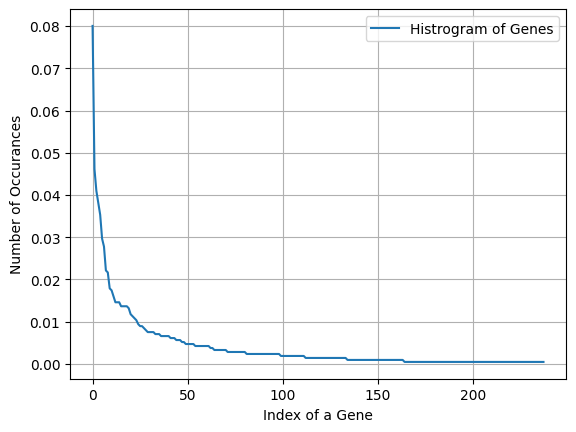

In [516]:
s = sum(unique_genes.values);
h = unique_genes.values/s;
plt.plot(h, label="Histrogram of Genes")
plt.xlabel('Index of a Gene')
plt.ylabel('Number of Occurances')
plt.legend()
plt.grid()
plt.show()


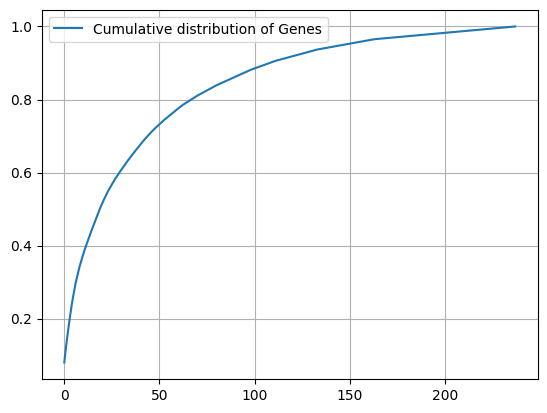

In [517]:
c = np.cumsum(h)
plt.plot(c,label='Cumulative distribution of Genes')
plt.grid()
plt.legend()
plt.show()

<p style="font-size:18px;"> <b>Q3.</b> How to featurize this Gene feature ?</p>

<p style="font-size:16px;"><b>Ans.</b>there are two ways we can featurize this variable
check out this video: https://www.appliedaicourse.com/course/applied-ai-course-online/lessons/handling-categorical-and-numerical-features/
<ol><li>One hot Encoding</li><li>Response coding / Target Encoding</li></ol></p>
<p> We will choose the appropriate featurization based on the ML model we use.  For this problem of multi-class classification with categorical features, one-hot encoding is better for Logistic regression while response coding is better for Random Forests. </p>

In [21]:
#response-coding of the Gene feature
# alpha is used for laplace smoothing
alpha = 1
# train gene feature
train_gene_feature_responseCoding = np.array(get_gv_feature(alpha, "Gene", train_df))
# test gene feature
test_gene_feature_responseCoding = np.array(get_gv_feature(alpha, "Gene", test_df))
# cross validation gene feature
cv_gene_feature_responseCoding = np.array(get_gv_feature(alpha, "Gene", cv_df))

Response coding with Laplace smoothing is only used when your feature cardinality is high because there can be classes in test data that are not present in train data. So, to ensure that those classes in test data prob should not be zero, we use laplace smoothing.
When combining response coding with Laplace smoothing, we address two main challenges:

1. Handling categories(of test data) with zero occurrences in train data: Laplace smoothing allows us to assign a non-zero probability to all categories, including those that have not been observed in the training data. Without smoothing, categories with zero occurrences would have zero probabilities, making them problematic for encoding purposes.

2. Reducing the impact of rare categories: Laplace smoothing helps to mitigate the effects of rare categories by smoothing their probabilities towards a uniform distribution. By adding a pseudocount to each category count, we ensure that even rare categories receive a reasonable probability estimate instead of being assigned extreme probabilities based solely on the limited observed data.

In [946]:
print("train_gene_feature_responseCoding is converted feature using respone coding method. The shape of gene feature:", train_gene_feature_responseCoding.shape)

train_gene_feature_responseCoding is converted feature using respone coding method. The shape of gene feature: (2124, 9)


In [22]:
# one-hot encoding of Gene feature.
gene_vectorizer = CountVectorizer()
train_gene_feature_onehotCoding = gene_vectorizer.fit_transform(train_df['Gene'])
test_gene_feature_onehotCoding = gene_vectorizer.transform(test_df['Gene'])
cv_gene_feature_onehotCoding = gene_vectorizer.transform(cv_df['Gene'])

In [521]:
train_df['Gene'].head()

1689     PMS2
711     ERBB2
2733     BRAF
825     BRIP1
1519      ALK
Name: Gene, dtype: object

In [757]:
gene_vectorizer.get_feature_names_out()

array(['abl1', 'acvr1', 'ago2', 'akt1', 'akt2', 'akt3', 'alk', 'apc',
       'ar', 'araf', 'arid1a', 'arid1b', 'arid2', 'arid5b', 'asxl2',
       'atm', 'atr', 'atrx', 'aurka', 'b2m', 'bap1', 'bard1', 'bcl10',
       'bcl2', 'bcl2l11', 'bcor', 'braf', 'brca1', 'brca2', 'brd4',
       'brip1', 'btk', 'card11', 'carm1', 'casp8', 'cbl', 'ccnd1',
       'ccnd3', 'ccne1', 'cdh1', 'cdk12', 'cdk4', 'cdk6', 'cdk8',
       'cdkn1a', 'cdkn1b', 'cdkn2a', 'cdkn2b', 'cebpa', 'chek2', 'cic',
       'crebbp', 'ctcf', 'ctla4', 'ctnnb1', 'ddr2', 'dicer1', 'dnmt3a',
       'dnmt3b', 'dusp4', 'egfr', 'eif1ax', 'elf3', 'ep300', 'epas1',
       'epcam', 'erbb2', 'erbb3', 'erbb4', 'ercc2', 'ercc3', 'ercc4',
       'erg', 'esr1', 'etv1', 'etv6', 'ewsr1', 'ezh2', 'fanca', 'fancc',
       'fat1', 'fbxw7', 'fgf19', 'fgf3', 'fgf4', 'fgfr1', 'fgfr2',
       'fgfr3', 'fgfr4', 'flt3', 'foxa1', 'foxp1', 'fubp1', 'gata3',
       'gna11', 'gnaq', 'gnas', 'h3f3a', 'hist1h1c', 'hla', 'hnf1a',
       'hras', 'idh1', 'idh

In [523]:
print("train_gene_feature_onehotCoding is converted feature using one-hot encoding method. The shape of gene feature:", train_gene_feature_onehotCoding.shape)

train_gene_feature_onehotCoding is converted feature using one-hot encoding method. The shape of gene feature: (2124, 238)


<p style="font-size:18px;"> <b>Q4.</b> How good is this gene feature  in predicting y_i?</p>

There are many ways to estimate how good a feature is, in predicting y_i. One of the good methods is to build a proper ML model using just this feature. In this case, we will build a logistic regression model (with calibration) using only Gene feature (one hot encoded) to predict y_i.

For values of alpha =  1e-05 The log loss is: 1.2362339357116443
For values of alpha =  0.0001 The log loss is: 1.217070258406917
For values of alpha =  0.001 The log loss is: 1.2518221942241898
For values of alpha =  0.01 The log loss is: 1.3385589599932837
For values of alpha =  0.1 The log loss is: 1.4351597042547843
For values of alpha =  1 The log loss is: 1.4761423450567766


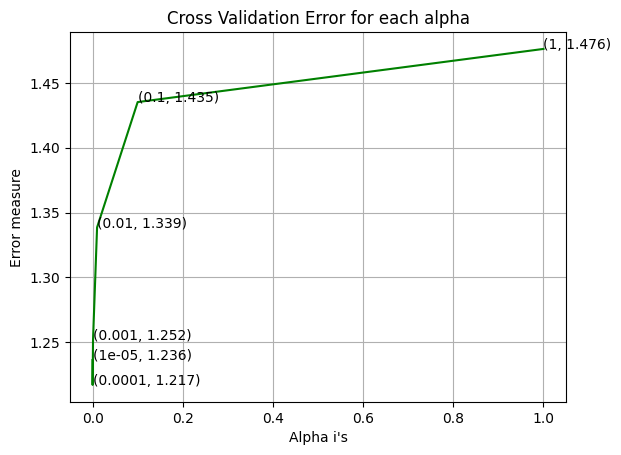

For values of best alpha =  0.0001 The train log loss is: 0.9871535626851683
For values of best alpha =  0.0001 The cross validation log loss is: 1.217070258406917
For values of best alpha =  0.0001 The test log loss is: 1.1841180722437157


In [23]:
alpha = [10 ** x for x in range(-5, 1)] # hyperparam for SGD classifier.

# read more about SGDClassifier() at http://scikit-learn.org/stable/modules/generated/sklearn.linear_model.SGDClassifier.html
# ------------------------------
# default parameters
# SGDClassifier(loss=’hinge’, penalty=’l2’, alpha=0.0001, l1_ratio=0.15, fit_intercept=True, max_iter=None, tol=None, 
# shuffle=True, verbose=0, epsilon=0.1, n_jobs=1, random_state=None, learning_rate=’optimal’, eta0=0.0, power_t=0.5, 
# class_weight=None, warm_start=False, average=False, n_iter=None)

# some of methods
# fit(X, y[, coef_init, intercept_init, …])	Fit linear model with Stochastic Gradient Descent.
# predict(X)	Predict class labels for samples in X.

#-------------------------------
# video link: 
#------------------------------


cv_log_error_array=[]
for i in alpha:
    clf = SGDClassifier(alpha=i, penalty='l2', loss='log', random_state=42)
    clf.fit(train_gene_feature_onehotCoding, y_train)
    sig_clf = CalibratedClassifierCV(clf, method="sigmoid") # Platt Scaling
    sig_clf.fit(train_gene_feature_onehotCoding, y_train)
    predict_y = sig_clf.predict_proba(cv_gene_feature_onehotCoding)
    cv_log_error_array.append(log_loss(y_cv, predict_y, labels=clf.classes_, eps=1e-15))
    print('For values of alpha = ', i, "The log loss is:",log_loss(y_cv, predict_y, labels=clf.classes_, eps=1e-15))

fig, ax = plt.subplots()
ax.plot(alpha, cv_log_error_array,c='g')
for i, txt in enumerate(np.round(cv_log_error_array,3)):
    ax.annotate((alpha[i],np.round(txt,3)), (alpha[i],cv_log_error_array[i]))
plt.grid()
plt.title("Cross Validation Error for each alpha")
plt.xlabel("Alpha i's")
plt.ylabel("Error measure")
plt.show()


best_alpha = np.argmin(cv_log_error_array)
clf = SGDClassifier(alpha=alpha[best_alpha], penalty='l2', loss='log', random_state=42)
clf.fit(train_gene_feature_onehotCoding, y_train)
sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(train_gene_feature_onehotCoding, y_train)

predict_y = sig_clf.predict_proba(train_gene_feature_onehotCoding)
print('For values of best alpha = ', alpha[best_alpha], "The train log loss is:",log_loss(y_train, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(cv_gene_feature_onehotCoding)
print('For values of best alpha = ', alpha[best_alpha], "The cross validation log loss is:",log_loss(y_cv, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(test_gene_feature_onehotCoding)
print('For values of best alpha = ', alpha[best_alpha], "The test log loss is:",log_loss(y_test, predict_y, labels=clf.classes_, eps=1e-15))


In [525]:
# So as test error of log reg model (+ Calibration) using only "Gene" feature is 1.2 which is way better than a random model (2.5).
# So Gene is a very important feature

<p style="font-size:18px;"> <b>Q5.</b> Is the Gene feature stable across all the data sets (Test, Train, Cross validation)?</p>
<p style="font-size:16px;"> <b>Ans.</b> Yes, it is. Otherwise, the CV and Test errors would be significantly more than train error. </p>

In [26]:
print("Q6. How many data points in Test and CV datasets are covered by the ", unique_genes.shape[0], " genes in train dataset?")

test_coverage=test_df[test_df['Gene'].isin(list(set(train_df['Gene'])))].shape[0]
cv_coverage=cv_df[cv_df['Gene'].isin(list(set(train_df['Gene'])))].shape[0]

print('Ans\n1. In test data',test_coverage, 'out of',test_df.shape[0], ":",(test_coverage/test_df.shape[0])*100)
print('2. In cross validation data',cv_coverage, 'out of ',cv_df.shape[0],":" ,(cv_coverage/cv_df.shape[0])*100)

Q6. How many data points in Test and CV datasets are covered by the  224  genes in train dataset?
Ans
1. In test data 637 out of 665 : 95.78947368421052
2. In cross validation data 506 out of  532 : 95.11278195488721


As we can see there is a good intersection of genes classes in train,test and cv. so gene is stable feature. 

But if there were many gene class in cv or test which are not present in train data. Then it would lead to overfitting. In that case either :

`(a).` we can try train test cv split again but because of this other categorical features may become unstable 

`(b).` So its better to remove that feature because this feature is not important as its unstable and test error is high (overfitting)

<h3>3.2.2 Univariate Analysis on Variation Feature</h3>

<p style="font-size:18px;"> <b>Q7.</b> Variation, What type of feature is it ?</p>
<p style="font-size:16px;"><b>Ans.</b> Variation is a categorical variable </p>
<p style="font-size:18px;"> <b>Q8.</b> How many categories are there?</p>

In [27]:
unique_variations = train_df['Variation'].value_counts()
print('Number of Unique Variations :', unique_variations.shape[0])
# the top 10 variations that occured most
print(unique_variations.head(10))

Number of Unique Variations : 1930
Truncating_Mutations    60
Deletion                50
Amplification           46
Fusions                 18
G12V                     3
Overexpression           3
M1R                      2
E17K                     2
K117N                    2
T286A                    2
Name: Variation, dtype: int64


### Variation has high cardinality

In [528]:
print("Ans: There are", unique_variations.shape[0] ,"different categories of variations in the train data, and they are distibuted as follows",)

Ans: There are 1919 different categories of variations in the train data, and they are distibuted as follows


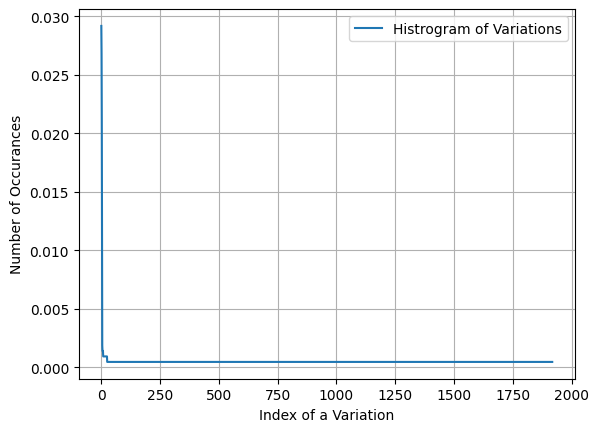

In [529]:
s = sum(unique_variations.values);
h = unique_variations.values/s;
plt.plot(h, label="Histrogram of Variations")
plt.xlabel('Index of a Variation')
plt.ylabel('Number of Occurances')
plt.legend()
plt.grid()
plt.show()

[0.02919021 0.05602637 0.07721281 ... 0.99905838 0.99952919 1.        ]


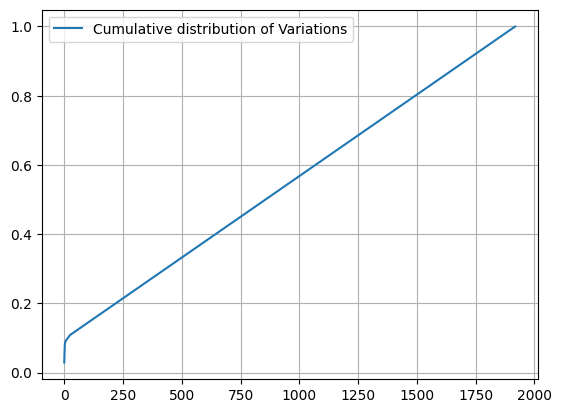

In [530]:
c = np.cumsum(h)
print(c)
plt.plot(c,label='Cumulative distribution of Variations')
plt.grid()
plt.legend()
plt.show()

<p style="font-size:18px;"> <b>Q9.</b> How to featurize this Variation feature ?</p>

<p style="font-size:16px;"><b>Ans.</b>There are two ways we can featurize this variable
check out this video: https://www.appliedaicourse.com/course/applied-ai-course-online/lessons/handling-categorical-and-numerical-features/
<ol><li>One hot Encoding</li><li>Response coding</li></ol></p>
<p> We will be using both these methods to featurize the Variation Feature </p>

In [28]:
# alpha is used for laplace smoothing
alpha = 1
# train gene feature
train_variation_feature_responseCoding = np.array(get_gv_feature(alpha, "Variation", train_df))
# test gene feature
test_variation_feature_responseCoding = np.array(get_gv_feature(alpha, "Variation", test_df))
# cross validation gene feature
cv_variation_feature_responseCoding = np.array(get_gv_feature(alpha, "Variation", cv_df))

In [29]:
print("train_variation_feature_responseCoding is a converted feature using the response coding method. The shape of Variation feature:", train_variation_feature_responseCoding.shape)

train_variation_feature_responseCoding is a converted feature using the response coding method. The shape of Variation feature: (2124, 9)


In [30]:
# one-hot encoding of variation feature.
variation_vectorizer = CountVectorizer()
train_variation_feature_onehotCoding = variation_vectorizer.fit_transform(train_df['Variation'])
test_variation_feature_onehotCoding = variation_vectorizer.transform(test_df['Variation'])
cv_variation_feature_onehotCoding = variation_vectorizer.transform(cv_df['Variation'])

In [31]:
print("train_variation_feature_onehotEncoded is converted feature using the onne-hot encoding method. The shape of Variation feature:", train_variation_feature_onehotCoding.shape)

train_variation_feature_onehotEncoded is converted feature using the onne-hot encoding method. The shape of Variation feature: (2124, 1957)


In [760]:
result.shape

(3321, 5)

<p style="font-size:18px;"> <b>Q10.</b> How good is this Variation feature  in predicting y_i?</p>

Let's build a model just like the earlier!

For values of alpha =  1e-05 The log loss is: 1.7142955258674162
For values of alpha =  0.0001 The log loss is: 1.7089986228577256
For values of alpha =  0.001 The log loss is: 1.7123987716310172
For values of alpha =  0.01 The log loss is: 1.7232527011082208
For values of alpha =  0.1 The log loss is: 1.7367679361717558
For values of alpha =  1 The log loss is: 1.7383078471257591


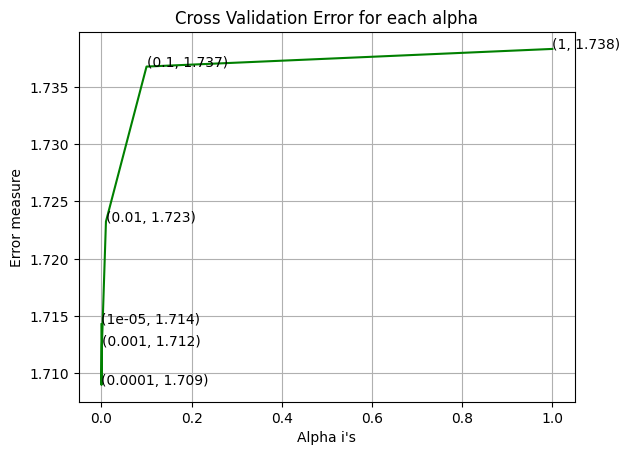

For values of best alpha =  0.0001 The train log loss is: 0.6461438050085647
For values of best alpha =  0.0001 The cross validation log loss is: 1.7089986228577256
For values of best alpha =  0.0001 The test log loss is: 1.7025505433916668


In [32]:
alpha = [10 ** x for x in range(-5, 1)]

# read more about SGDClassifier() at http://scikit-learn.org/stable/modules/generated/sklearn.linear_model.SGDClassifier.html
# ------------------------------
# default parameters
# SGDClassifier(loss=’hinge’, penalty=’l2’, alpha=0.0001, l1_ratio=0.15, fit_intercept=True, max_iter=None, tol=None, 
# shuffle=True, verbose=0, epsilon=0.1, n_jobs=1, random_state=None, learning_rate=’optimal’, eta0=0.0, power_t=0.5, 
# class_weight=None, warm_start=False, average=False, n_iter=None)

# some of methods
# fit(X, y[, coef_init, intercept_init, …])	Fit linear model with Stochastic Gradient Descent.
# predict(X)	Predict class labels for samples in X.

#-------------------------------
# video link: 
#------------------------------


cv_log_error_array=[]
for i in alpha:
    clf = SGDClassifier(alpha=i, penalty='l2', loss='log', random_state=42)
    clf.fit(train_variation_feature_onehotCoding, y_train)
    
    sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
    sig_clf.fit(train_variation_feature_onehotCoding, y_train)
    predict_y = sig_clf.predict_proba(cv_variation_feature_onehotCoding)
    
    cv_log_error_array.append(log_loss(y_cv, predict_y, labels=clf.classes_, eps=1e-15))
    print('For values of alpha = ', i, "The log loss is:",log_loss(y_cv, predict_y, labels=clf.classes_, eps=1e-15))

fig, ax = plt.subplots()
ax.plot(alpha, cv_log_error_array,c='g')
for i, txt in enumerate(np.round(cv_log_error_array,3)):
    ax.annotate((alpha[i],np.round(txt,3)), (alpha[i],cv_log_error_array[i]))
plt.grid()
plt.title("Cross Validation Error for each alpha")
plt.xlabel("Alpha i's")
plt.ylabel("Error measure")
plt.show()


best_alpha = np.argmin(cv_log_error_array)
clf = SGDClassifier(alpha=alpha[best_alpha], penalty='l2', loss='log', random_state=42)
clf.fit(train_variation_feature_onehotCoding, y_train)
sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(train_variation_feature_onehotCoding, y_train)

predict_y = sig_clf.predict_proba(train_variation_feature_onehotCoding)
print('For values of best alpha = ', alpha[best_alpha], "The train log loss is:",log_loss(y_train, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(cv_variation_feature_onehotCoding)
print('For values of best alpha = ', alpha[best_alpha], "The cross validation log loss is:",log_loss(y_cv, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(test_variation_feature_onehotCoding)
print('For values of best alpha = ', alpha[best_alpha], "The test log loss is:",log_loss(y_test, predict_y, labels=clf.classes_, eps=1e-15))


We can see much difference in train , cv and test error, also variation has high cardinality. So seeing this, we can say that this feature might be very unstable. But we are not very sure, we will verify it below.

<p style="font-size:18px;"> <b>Q11.</b> Is the Variation feature stable across all the data sets (Test, Train, Cross validation)?</p>
<p style="font-size:16px;"> <b>Ans.</b> Not sure! But lets be very sure using the below analysis. </p>

In [33]:
print("Q12. How many data points are covered by total ", unique_variations.shape[0], "variation in test and cross validation data sets?")
test_coverage=test_df[test_df['Variation'].isin(list(set(train_df['Variation'])))].shape[0]
cv_coverage=cv_df[cv_df['Variation'].isin(list(set(train_df['Variation'])))].shape[0]
print('Ans\n1. In test data',test_coverage, 'out of',test_df.shape[0], ":",(test_coverage/test_df.shape[0])*100)
print('2. In cross validation data',cv_coverage, 'out of ',cv_df.shape[0],":" ,(cv_coverage/cv_df.shape[0])*100)

Q12. How many data points are covered by total  1930 variation in test and cross validation data sets?
Ans
1. In test data 64 out of 665 : 9.624060150375941
2. In cross validation data 65 out of  532 : 12.218045112781954


### Even though, this feature is very unstable, then also its log loss is good enough (less than random model) not as good as gene. So, we will not throw out this feature because its useful for predicting y_i.

<h3>3.2.3 Univariate Analysis on Text Feature</h3>

1. How many unique words are present in train data?
2. How are word frequencies distributed?
3. How to featurize text field?
4. Is the text feature useful in predicitng y_i?
5. Is the text feature stable across train, test and CV datasets?

In [36]:
# cls_text is a data frame
# for every row in data fram consider the 'TEXT'
# split the words by space
# make a dict with those words
# increment its count whenever we see that word

def extract_dictionary_paddle(cls_text):
    dictionary = defaultdict(int)
    for index, row in cls_text.iterrows():
        for word in row['TEXT'].split():
            dictionary[word] +=1
    return dictionary

In [37]:
import math
#https://stackoverflow.com/a/1602964
def get_text_responsecoding(df):
    text_feature_responseCoding = np.zeros((df.shape[0],9))
    for i in range(0,9):
        row_index = 0
        for index, row in df.iterrows():
            sum_prob = 0
            for word in row['TEXT'].split():
                sum_prob += math.log(((dict_list[i].get(word,0)+10 )/(total_dict.get(word,0)+90)))
            text_feature_responseCoding[row_index][i] = math.exp(sum_prob/len(row['TEXT'].split()))
            row_index += 1
    return text_feature_responseCoding

In [38]:
# building a CountVectorizer with all the words that occured minimum 3 times in train data
text_vectorizer = CountVectorizer(min_df=3)
train_text_feature_onehotCoding = text_vectorizer.fit_transform(train_df['TEXT'])
test_text_feature_onehotCoding = text_vectorizer.transform(test_df['TEXT'])
cv_text_feature_onehotCoding = text_vectorizer.transform(cv_df['TEXT'])
# getting all the feature names (words)
train_text_features= text_vectorizer.get_feature_names_out()

# train_text_feature_onehotCoding.sum(axis=0).A1 will sum every row and returns (1*number of features) vector
train_text_fea_counts = train_text_feature_onehotCoding.sum(axis=0).A1

# zip(list(text_features),text_fea_counts) will zip a word with its number of times it occured
text_fea_dict = dict(zip(list(train_text_features),train_text_fea_counts))


print("Total number of unique words in train data :", len(train_text_features))

Total number of unique words in train data : 53377


In [42]:
dict_list = []
# dict_list =[] contains 9 dictoinaries each corresponds to a class
for i in range(1,10):
    cls_text = train_df[train_df['Class']==i]
    # build a word dict based on the words in that class
    dict_list.append(extract_dictionary_paddle(cls_text))
    # append it to dict_list

# dict_list[i] is build on i'th  class text data
# total_dict is buid on whole training text data
total_dict = extract_dictionary_paddle(train_df)


confuse_array = []
for i in train_text_features:
    ratios = []
    max_val = -1
    for j in range(0,9):
        ratios.append((dict_list[j][i]+10 )/(total_dict[i]+90))
    confuse_array.append(ratios)
confuse_array = np.array(confuse_array)

In [43]:
#response coding of text features
train_text_feature_responseCoding  = get_text_responsecoding(train_df)
test_text_feature_responseCoding  = get_text_responsecoding(test_df)
cv_text_feature_responseCoding  = get_text_responsecoding(cv_df)

In [44]:
# https://stackoverflow.com/a/16202486
# we convert each row values such that they sum to 1  
train_text_feature_responseCoding = (train_text_feature_responseCoding.T/train_text_feature_responseCoding.sum(axis=1)).T
test_text_feature_responseCoding = (test_text_feature_responseCoding.T/test_text_feature_responseCoding.sum(axis=1)).T
cv_text_feature_responseCoding = (cv_text_feature_responseCoding.T/cv_text_feature_responseCoding.sum(axis=1)).T

For values of alpha =  1e-05 The log loss is: 1.8308895093721704
For values of alpha =  0.0001 The log loss is: 1.7764850556295775
For values of alpha =  0.001 The log loss is: 1.299246044340415
For values of alpha =  0.01 The log loss is: 1.2997214096185512
For values of alpha =  0.1 The log loss is: 1.3086158304902973
For values of alpha =  1 The log loss is: 1.22128757300246


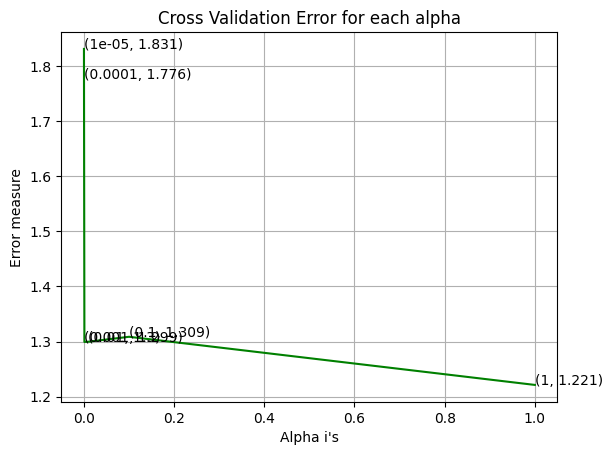

For values of best alpha =  1 The train log loss is: 0.8285764787161713
For values of best alpha =  1 The cross validation log loss is: 1.22128757300246
For values of best alpha =  1 The test log loss is: 1.2134151758285447


In [39]:
# Train a Logistic regression+Calibration model using text features which are one-hot encoded
alpha = [10 ** x for x in range(-5, 1)]

# read more about SGDClassifier() at http://scikit-learn.org/stable/modules/generated/sklearn.linear_model.SGDClassifier.html
# ------------------------------
# default parameters
# SGDClassifier(loss=’hinge’, penalty=’l2’, alpha=0.0001, l1_ratio=0.15, fit_intercept=True, max_iter=None, tol=None, 
# shuffle=True, verbose=0, epsilon=0.1, n_jobs=1, random_state=None, learning_rate=’optimal’, eta0=0.0, power_t=0.5, 
# class_weight=None, warm_start=False, average=False, n_iter=None)

# some of methods
# fit(X, y[, coef_init, intercept_init, …])	Fit linear model with Stochastic Gradient Descent.
# predict(X)	Predict class labels for samples in X.

#-------------------------------
# video link: 
#------------------------------


cv_log_error_array=[]
for i in alpha:
    clf = SGDClassifier(alpha=i, penalty='l2', loss='log', random_state=42)
    clf.fit(train_text_feature_onehotCoding, y_train)
    
    sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
    sig_clf.fit(train_text_feature_onehotCoding, y_train)
    predict_y = sig_clf.predict_proba(cv_text_feature_onehotCoding)
    cv_log_error_array.append(log_loss(y_cv, predict_y, labels=clf.classes_, eps=1e-15))
    print('For values of alpha = ', i, "The log loss is:",log_loss(y_cv, predict_y, labels=clf.classes_, eps=1e-15))

fig, ax = plt.subplots()
ax.plot(alpha, cv_log_error_array,c='g')
for i, txt in enumerate(np.round(cv_log_error_array,3)):
    ax.annotate((alpha[i],np.round(txt,3)), (alpha[i],cv_log_error_array[i]))
plt.grid()
plt.title("Cross Validation Error for each alpha")
plt.xlabel("Alpha i's")
plt.ylabel("Error measure")
plt.show()


best_alpha = np.argmin(cv_log_error_array)
clf = SGDClassifier(alpha=alpha[best_alpha], penalty='l2', loss='log', random_state=42)
clf.fit(train_text_feature_onehotCoding, y_train)
sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(train_text_feature_onehotCoding, y_train)

predict_y = sig_clf.predict_proba(train_text_feature_onehotCoding)
print('For values of best alpha = ', alpha[best_alpha], "The train log loss is:",log_loss(y_train, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(cv_text_feature_onehotCoding)
print('For values of best alpha = ', alpha[best_alpha], "The cross validation log loss is:",log_loss(y_cv, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(test_text_feature_onehotCoding)
print('For values of best alpha = ', alpha[best_alpha], "The test log loss is:",log_loss(y_test, predict_y, labels=clf.classes_, eps=1e-15))


<p style="font-size:18px;"> <b>Q.</b> Is the Text feature stable across all the data sets (Test, Train, Cross validation)?</p>
<p style="font-size:16px;"> <b>Ans.</b> Yes, it seems like! </p>

In [40]:
def get_intersec_text(df):
    df_text_vec = CountVectorizer(min_df=3)
    df_text_fea = df_text_vec.fit_transform(df['TEXT'])
    df_text_features = df_text_vec.get_feature_names_out()

    df_text_fea_counts = df_text_fea.sum(axis=0).A1
    df_text_fea_dict = dict(zip(list(df_text_features),df_text_fea_counts))
    len1 = len(set(df_text_features))
    len2 = len(set(train_text_features) & set(df_text_features))
    return len1,len2

In [41]:
len1,len2 = get_intersec_text(test_df)
print(np.round((len2/len1)*100, 3), "% of word of test data appeared in train data")
len1,len2 = get_intersec_text(cv_df)
print(np.round((len2/len1)*100, 3), "% of word of Cross Validation appeared in train data")

97.584 % of word of test data appeared in train data
96.943 % of word of Cross Validation appeared in train data


<h1>4. Machine Learning Models</h1>

In [45]:
#Data preparation for ML models.

#Misc. functionns for ML models


def predict_and_plot_confusion_matrix(train_x, train_y,test_x, test_y, clf):
    clf.fit(train_x, train_y)
    sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
    sig_clf.fit(train_x, train_y)
    pred_y = sig_clf.predict(test_x)

    # for calculating log_loss we willl provide the array of probabilities belongs to each class
    print("Log loss :",log_loss(test_y, sig_clf.predict_proba(test_x)))
    # calculating the number of data points that are misclassified
    print("Number of mis-classified points :", np.count_nonzero((pred_y- test_y))/test_y.shape[0])
    plot_confusion_matrix(test_y, pred_y)

In [46]:
def report_log_loss(train_x, train_y, test_x, test_y,  clf):
    clf.fit(train_x, train_y)
    sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
    sig_clf.fit(train_x, train_y)
    sig_clf_probs = sig_clf.predict_proba(test_x)
    return log_loss(test_y, sig_clf_probs, eps=1e-15)

In [47]:
# this function will be used just for naive bayes
# for the given indices, we will print the name of the features
# and we will check whether the feature present in the test point text or not
def get_impfeature_names(indices, text, gene, var, no_features):
    gene_count_vec = CountVectorizer()
    var_count_vec = CountVectorizer()
    text_count_vec = CountVectorizer(min_df=3)
    
    gene_vec = gene_count_vec.fit(train_df['Gene'])
    var_vec  = var_count_vec.fit(train_df['Variation'])
    text_vec = text_count_vec.fit(train_df['TEXT'])
    
    fea1_len = len(gene_vec.get_feature_names_out())
    fea2_len = len(var_count_vec.get_feature_names_out())
    
    word_present = 0
    for i,v in enumerate(indices):
        if (v < fea1_len):
            word = gene_vec.get_feature_names_out()[v]
            yes_no = True if word == gene else False
            if yes_no:
                word_present += 1
                print(i, "Gene feature [{}] present in test data point [{}]".format(word,yes_no))
        elif (v < fea1_len+fea2_len):
            word = var_vec.get_feature_names_out()[v-(fea1_len)]
            yes_no = True if word == var else False
            if yes_no:
                word_present += 1
                print(i, "variation feature [{}] present in test data point [{}]".format(word,yes_no))
        else:
            word = text_vec.get_feature_names_out()[v-(fea1_len+fea2_len)]
            yes_no = True if word in text.split() else False
            if yes_no:
                word_present += 1
                print(i, "Text feature [{}] present in test data point [{}]".format(word,yes_no))

    print("Out of the top ",no_features," features ", word_present, "are present in query point")

<p style="font-size:24px;text-align:Center"> <b>Stacking the three types of features </b><p>

In [48]:
# merging gene, variance and text features


train_gene_var_onehotCoding = hstack((train_gene_feature_onehotCoding,train_variation_feature_onehotCoding))
test_gene_var_onehotCoding = hstack((test_gene_feature_onehotCoding,test_variation_feature_onehotCoding))
cv_gene_var_onehotCoding = hstack((cv_gene_feature_onehotCoding,cv_variation_feature_onehotCoding))

train_x_onehotCoding = hstack((train_gene_var_onehotCoding, train_text_feature_onehotCoding)).tocsr()
train_y = np.array(list(train_df['Class']))

test_x_onehotCoding = hstack((test_gene_var_onehotCoding, test_text_feature_onehotCoding)).tocsr()
test_y = np.array(list(test_df['Class']))

cv_x_onehotCoding = hstack((cv_gene_var_onehotCoding, cv_text_feature_onehotCoding)).tocsr()
cv_y = np.array(list(cv_df['Class']))


train_gene_var_responseCoding = np.hstack((train_gene_feature_responseCoding,train_variation_feature_responseCoding))
test_gene_var_responseCoding = np.hstack((test_gene_feature_responseCoding,test_variation_feature_responseCoding))
cv_gene_var_responseCoding = np.hstack((cv_gene_feature_responseCoding,cv_variation_feature_responseCoding))

train_x_responseCoding = np.hstack((train_gene_var_responseCoding, train_text_feature_responseCoding))
test_x_responseCoding = np.hstack((test_gene_var_responseCoding, test_text_feature_responseCoding))
cv_x_responseCoding = np.hstack((cv_gene_var_responseCoding, cv_text_feature_responseCoding))


In [555]:
print("One hot encoding features :")
print("(number of data points * number of features) in train data = ", train_x_onehotCoding.shape)
print("(number of data points * number of features) in test data = ", test_x_onehotCoding.shape)
print("(number of data points * number of features) in cross validation data =", cv_x_onehotCoding.shape)

One hot encoding features :
(number of data points * number of features) in train data =  (2124, 127286)
(number of data points * number of features) in test data =  (665, 127286)
(number of data points * number of features) in cross validation data = (532, 127286)


In [584]:
print(" Response encoding features :")
print("(number of data points * number of features) in train data = ", train_x_responseCoding.shape)
print("(number of data points * number of features) in test data = ", test_x_responseCoding.shape)
print("(number of data points * number of features) in cross validation data =", cv_x_responseCoding.shape)

 Response encoding features :
(number of data points * number of features) in train data =  (2124, 27)
(number of data points * number of features) in test data =  (665, 27)
(number of data points * number of features) in cross validation data = (532, 27)


<h2>4.1. Base Line Model</h2>

<h3>4.1.1. Naive Bayes</h3>

#### Using One-Hot Features

<h4>4.1.1.1. Hyper parameter tuning</h4>

for alpha = 1e-05
Log Loss : 1.3129436113262418
for alpha = 0.0001
Log Loss : 1.3166302684605478
for alpha = 0.001
Log Loss : 1.3178640097221184
for alpha = 0.1
Log Loss : 1.3413414390824077
for alpha = 1
Log Loss : 1.3542522985476022
for alpha = 10
Log Loss : 1.392962807873019
for alpha = 100
Log Loss : 1.697335890436152
for alpha = 1000
Log Loss : 1.7901778831536461


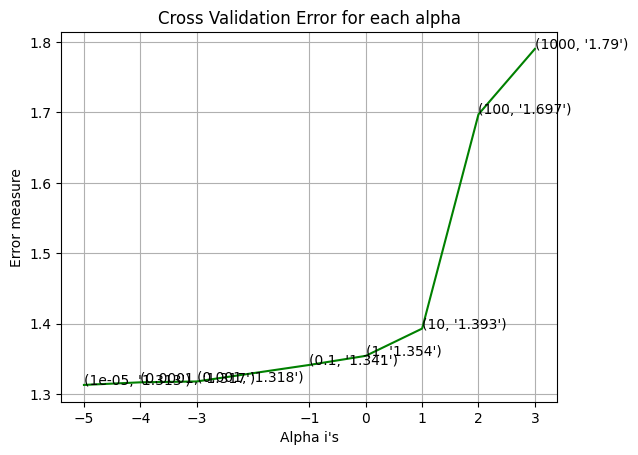

For values of best alpha =  1e-05 The train log loss is: 0.9246353792651704
For values of best alpha =  1e-05 The cross validation log loss is: 1.3129436113262418
For values of best alpha =  1e-05 The test log loss is: 1.2524535379133845


In [49]:

alpha = [0.00001, 0.0001, 0.001, 0.1, 1, 10, 100,1000]
cv_log_error_array = []
for i in alpha:
    print("for alpha =", i)
    clf = MultinomialNB(alpha=i)
    clf.fit(train_x_onehotCoding, train_y)
    sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
    sig_clf.fit(train_x_onehotCoding, train_y)
    sig_clf_probs = sig_clf.predict_proba(cv_x_onehotCoding)
    cv_log_error_array.append(log_loss(cv_y, sig_clf_probs, labels=clf.classes_, eps=1e-15))
    # to avoid rounding error while multiplying probabilites we use log-probability estimates
    print("Log Loss :",log_loss(cv_y, sig_clf_probs)) 

fig, ax = plt.subplots()
ax.plot(np.log10(alpha), cv_log_error_array,c='g')
for i, txt in enumerate(np.round(cv_log_error_array,3)):
    ax.annotate((alpha[i],str(txt)), (np.log10(alpha[i]),cv_log_error_array[i]))
plt.grid()
plt.xticks(np.log10(alpha))
plt.title("Cross Validation Error for each alpha")
plt.xlabel("Alpha i's")
plt.ylabel("Error measure")
plt.show()


best_alpha = np.argmin(cv_log_error_array)
clf = MultinomialNB(alpha=alpha[best_alpha])
clf.fit(train_x_onehotCoding, train_y)
sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(train_x_onehotCoding, train_y)


predict_y = sig_clf.predict_proba(train_x_onehotCoding)
train_loss=log_loss(y_train, predict_y, labels=clf.classes_, eps=1e-15)
print('For values of best alpha = ', alpha[best_alpha], "The train log loss is:",train_loss)
predict_y = sig_clf.predict_proba(cv_x_onehotCoding)
cv_loss=log_loss(y_cv, predict_y, labels=clf.classes_, eps=1e-15)
print('For values of best alpha = ', alpha[best_alpha], "The cross validation log loss is:",cv_loss)
predict_y = sig_clf.predict_proba(test_x_onehotCoding)
test_loss=log_loss(y_test, predict_y, labels=clf.classes_, eps=1e-15)
print('For values of best alpha = ', alpha[best_alpha], "The test log loss is:",test_loss)


<h4>4.1.1.2. Testing the model with best hyper paramters</h4>

Log Loss : 1.3129436113262418
Number of missclassified point : 0.41541353383458646
-------------------- Confusion matrix --------------------


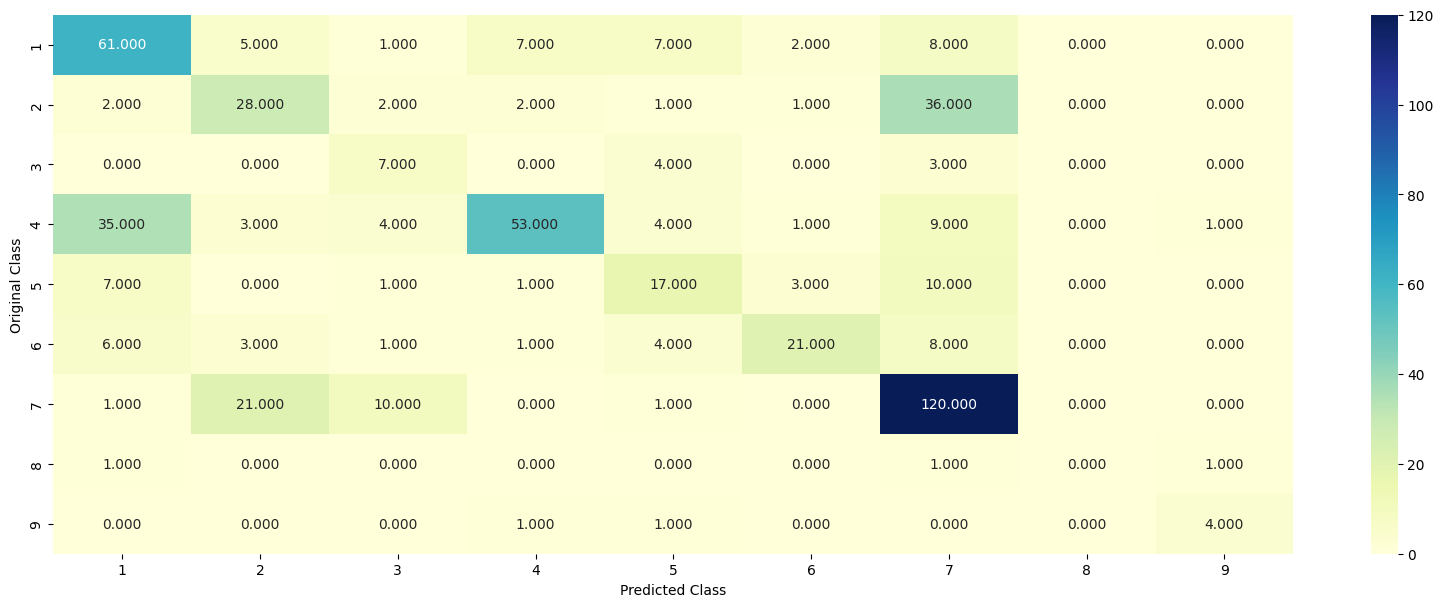

-------------------- Precision matrix (Columm Sum=1) --------------------


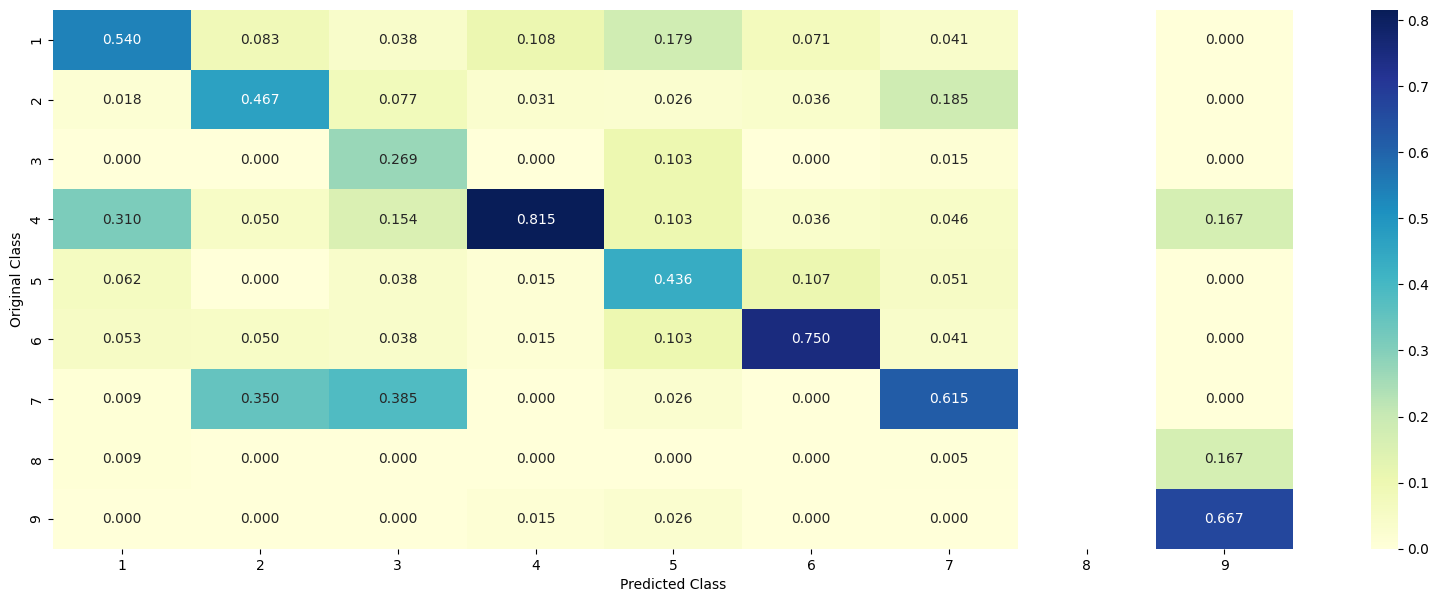

-------------------- Recall matrix (Row sum=1) --------------------


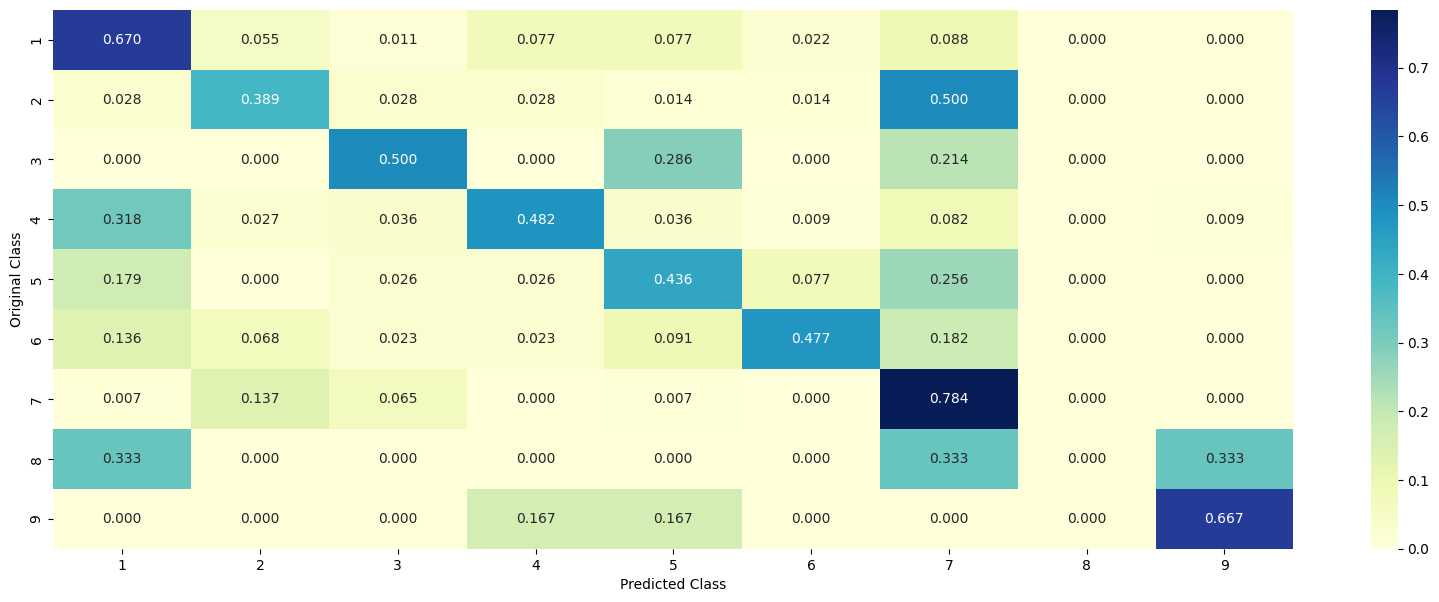

In [50]:

clf = MultinomialNB(alpha=alpha[best_alpha])
clf.fit(train_x_onehotCoding, train_y)
sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(train_x_onehotCoding, train_y)
sig_clf_probs = sig_clf.predict_proba(cv_x_onehotCoding)
# to avoid rounding error while multiplying probabilites we use log-probability estimates
print("Log Loss :",log_loss(cv_y, sig_clf_probs))
print("Number of missclassified point :", np.count_nonzero((sig_clf.predict(cv_x_onehotCoding)- cv_y))/cv_y.shape[0])
plot_confusion_matrix(cv_y, sig_clf.predict(cv_x_onehotCoding.toarray()))

In [561]:
# There is some problem b/w classes 1-7, 4-7, 2-7, 8-7, 9-7 and 3-7 etc. And 1,2,7,4 are big classes, so we cannot avoid their misclassified points

<h4>4.1.1.3. Feature Importance, Correctly classified point</h4>

In [51]:
test_point_index = 1
no_feature = 100
predicted_cls = sig_clf.predict(test_x_onehotCoding[test_point_index])
print("Predicted Class :", predicted_cls[0])
print("Predicted Class Probabilities:", np.round(sig_clf.predict_proba(test_x_onehotCoding[test_point_index]),4))
print("Actual Class :", test_y[test_point_index])
indices=np.argsort(-1*abs(clf.feature_log_prob_))[predicted_cls-1][:,:no_feature]
print("-"*50)
get_impfeature_names(indices[0], test_df['TEXT'].iloc[test_point_index],test_df['Gene'].iloc[test_point_index],test_df['Variation'].iloc[test_point_index], no_feature)
test_point_index = 1
no_feature = 100
predicted_cls = sig_clf.predict(test_x_onehotCoding[test_point_index])
print("Predicted Class :", predicted_cls[0])
print("Predicted Class Probabilities:", np.round(sig_clf.predict_proba(test_x_onehotCoding[test_point_index]),4))
print("Actual Class :", test_y[test_point_index])
indices=np.argsort(-1*abs(clf.feature_log_prob_))[predicted_cls-1][:,:no_feature]
print("-"*50)
get_impfeature_names(indices[0], test_df['TEXT'].iloc[test_point_index],test_df['Gene'].iloc[test_point_index],test_df['Variation'].iloc[test_point_index], no_feature)
Predicted Class : 2
Predicted Class Probabilities: [[0.0896 0.4583 0.0153 0.1292 0.0438 0.0432 0.2096 0.0061 0.0049]]
Actual Class : 7
--------------------------------------------------
Out of the top  100  features  0 are present in query point
4.1.1.4. Feature Importance, Incorrectly classified point


Predicted Class : 2
Predicted Class Probabilities: [[0.0896 0.4583 0.0153 0.1292 0.0438 0.0432 0.2096 0.0061 0.0049]]
Actual Class : 7
--------------------------------------------------
Out of the top  100  features  0 are present in query point


<h4>4.1.1.4. Feature Importance, Incorrectly classified point</h4>

In [52]:
test_point_index = 100
no_feature = 100
predicted_cls = sig_clf.predict(test_x_onehotCoding[test_point_index])
print("Predicted Class :", predicted_cls[0])
print("Predicted Class Probabilities:", np.round(sig_clf.predict_proba(test_x_onehotCoding[test_point_index]),4))
print("Actual Class :", test_y[test_point_index])
indices = np.argsort(-1*abs(clf.feature_log_prob_))[predicted_cls-1][:,:no_feature]
print("-"*50)
get_impfeature_names(indices[0], test_df['TEXT'].iloc[test_point_index],test_df['Gene'].iloc[test_point_index],test_df['Variation'].iloc[test_point_index], no_feature)

Predicted Class : 4
Predicted Class Probabilities: [[0.0768 0.0757 0.013  0.6547 0.0374 0.037  0.0959 0.0052 0.0044]]
Actual Class : 4
--------------------------------------------------
Out of the top  100  features  0 are present in query point


<h2>4.2. K Nearest Neighbour Classification</h2>

<h3>4.2.1. Hyper parameter tuning</h3>

### A. Using Euclidean Distance

for alpha = 5
Log Loss : 0.9342291954501603
for alpha = 6
Log Loss : 0.9311965358234771
for alpha = 7
Log Loss : 0.9275500559670852
for alpha = 8
Log Loss : 0.9269713456473002
for alpha = 9
Log Loss : 0.9216083226951919


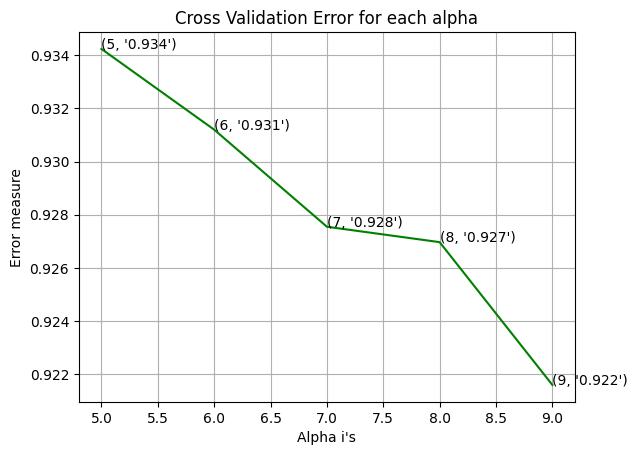

For values of best alpha =  9 The train log loss is: 0.5727667235602938
For values of best alpha =  9 The cross validation log loss is: 0.9216083226951919
For values of best alpha =  9 The test log loss is: 0.9319598907110664


In [53]:

alpha = [ 5,6, 7,8,9]
cv_log_error_array = []
for i in alpha:
    print("for alpha =", i)
    clf = KNeighborsClassifier(n_neighbors=i)
    sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
    sig_clf.fit(train_x_responseCoding, train_y)
    sig_clf_probs = sig_clf.predict_proba(cv_x_responseCoding)
    cv_log_error_array.append(log_loss(cv_y, sig_clf_probs, labels=result.Class.unique(), eps=1e-15))
    # to avoid rounding error while multiplying probabilites we use log-probability estimates
    print("Log Loss :",log_loss(cv_y, sig_clf_probs)) 

fig, ax = plt.subplots()
ax.plot(alpha, cv_log_error_array,c='g')
for i, txt in enumerate(np.round(cv_log_error_array,3)):
    ax.annotate((alpha[i],str(txt)), (alpha[i],cv_log_error_array[i]))
plt.grid()
plt.title("Cross Validation Error for each alpha")
plt.xlabel("Alpha i's")
plt.ylabel("Error measure")
plt.show()


best_alpha = np.argmin(cv_log_error_array)
clf = KNeighborsClassifier(n_neighbors=alpha[best_alpha])
clf.fit(train_x_responseCoding, train_y)
sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(train_x_responseCoding, train_y)

predict_y = sig_clf.predict_proba(train_x_responseCoding)
train_loss=log_loss(y_train, predict_y, labels=clf.classes_, eps=1e-15)
print('For values of best alpha = ', alpha[best_alpha], "The train log loss is:",train_loss)
predict_y = sig_clf.predict_proba(cv_x_responseCoding)
cv_loss=log_loss(y_cv, predict_y, labels=clf.classes_, eps=1e-15)
print('For values of best alpha = ', alpha[best_alpha], "The cross validation log loss is:",cv_loss)
predict_y = sig_clf.predict_proba(test_x_responseCoding)
test_loss=log_loss(y_test, predict_y, labels=clf.classes_, eps=1e-15)
print('For values of best alpha = ', alpha[best_alpha], "The test log loss is:",test_loss)


### B. Using Cosine Distance

for alpha = 4
Log Loss : 0.9369600695762922
for alpha = 5
Log Loss : 0.9280473942675752
for alpha = 6
Log Loss : 0.9290080121560255
for alpha = 7
Log Loss : 0.9222600967879269
for alpha = 8
Log Loss : 0.9190683918511249


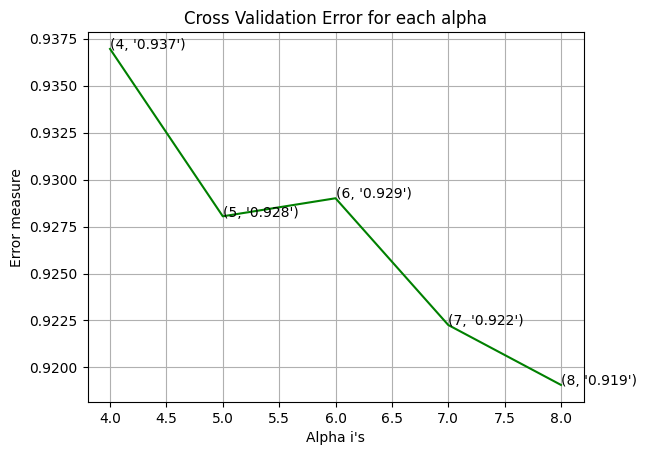

For values of best alpha =  8 The train log loss is: 0.5460200823640221
For values of best alpha =  8 The cross validation log loss is: 0.9190683918511249
For values of best alpha =  8 The test log loss is: 0.9294621973803494


In [54]:
alpha = [4,5,6,7,8]
cv_log_error_array = []
for i in alpha:
    print("for alpha =", i)
    clf = KNeighborsClassifier(n_neighbors=i, metric='cosine')
    clf.fit(train_x_responseCoding, train_y)
    sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
    sig_clf.fit(train_x_responseCoding, train_y)
    sig_clf_probs = sig_clf.predict_proba(cv_x_responseCoding)
    cv_log_error_array.append(log_loss(cv_y, sig_clf_probs, labels=clf.classes_, eps=1e-15))
    # to avoid rounding error while multiplying probabilites we use log-probability estimates
    print("Log Loss :",log_loss(cv_y, sig_clf_probs)) 

fig, ax = plt.subplots()
ax.plot(alpha, cv_log_error_array,c='g')
for i, txt in enumerate(np.round(cv_log_error_array,3)):
    ax.annotate((alpha[i],str(txt)), (alpha[i],cv_log_error_array[i]))
plt.grid()
plt.title("Cross Validation Error for each alpha")
plt.xlabel("Alpha i's")
plt.ylabel("Error measure")
plt.show()


best_alpha = np.argmin(cv_log_error_array)
clf = KNeighborsClassifier(n_neighbors=alpha[best_alpha], metric='cosine')
clf.fit(train_x_responseCoding, train_y)
sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(train_x_responseCoding, train_y)

predict_y = sig_clf.predict_proba(train_x_responseCoding)
train_loss=log_loss(y_train, predict_y, labels=clf.classes_, eps=1e-15)
print('For values of best alpha = ', alpha[best_alpha], "The train log loss is:",train_loss)
predict_y = sig_clf.predict_proba(cv_x_responseCoding)
cv_loss=log_loss(y_cv, predict_y, labels=clf.classes_, eps=1e-15)
print('For values of best alpha = ', alpha[best_alpha], "The cross validation log loss is:",cv_loss)
predict_y = sig_clf.predict_proba(test_x_responseCoding)
test_loss=log_loss(y_test, predict_y, labels=clf.classes_, eps=1e-15)
print('For values of best alpha = ', alpha[best_alpha], "The test log loss is:",test_loss)


### C. Using Weighted Distance & Euclidean

for alpha = 4
Log Loss : 0.933180861509062
for alpha = 5
Log Loss : 0.9236018923634777
for alpha = 6
Log Loss : 0.9211914897761304
for alpha = 7
Log Loss : 0.9174390050735031
for alpha = 8
Log Loss : 0.9161283381614823


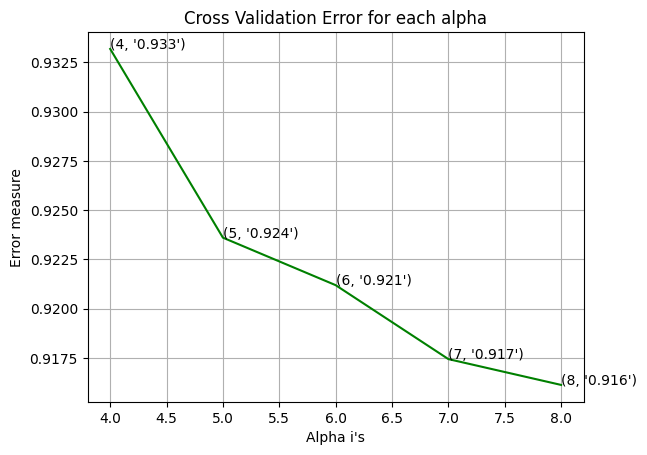

For values of best alpha =  8 The train log loss is: 0.15230789702551342
For values of best alpha =  8 The cross validation log loss is: 0.9161283381614823
For values of best alpha =  8 The test log loss is: 0.9204251640335436


In [55]:
alpha = [4, 5,6, 7,8]
cv_log_error_array = []
for i in alpha:
    print("for alpha =", i)
    clf = KNeighborsClassifier(n_neighbors=i, weights='distance')
    clf.fit(train_x_responseCoding, train_y)
    sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
    sig_clf.fit(train_x_responseCoding, train_y)
    sig_clf_probs = sig_clf.predict_proba(cv_x_responseCoding)
    cv_log_error_array.append(log_loss(cv_y, sig_clf_probs, labels=clf.classes_, eps=1e-15))
    # to avoid rounding error while multiplying probabilites we use log-probability estimates
    print("Log Loss :",log_loss(cv_y, sig_clf_probs)) 

fig, ax = plt.subplots()
ax.plot(alpha, cv_log_error_array,c='g')
for i, txt in enumerate(np.round(cv_log_error_array,3)):
    ax.annotate((alpha[i],str(txt)), (alpha[i],cv_log_error_array[i]))
plt.grid()
plt.title("Cross Validation Error for each alpha")
plt.xlabel("Alpha i's")
plt.ylabel("Error measure")
plt.show()


best_alpha = np.argmin(cv_log_error_array)
clf = KNeighborsClassifier(n_neighbors=alpha[best_alpha], weights='distance')
clf.fit(train_x_responseCoding, train_y)
sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(train_x_responseCoding, train_y)

predict_y = sig_clf.predict_proba(train_x_responseCoding)
train_loss=log_loss(y_train, predict_y, labels=clf.classes_, eps=1e-15)
print('For values of best alpha = ', alpha[best_alpha], "The train log loss is:",train_loss)
predict_y = sig_clf.predict_proba(cv_x_responseCoding)
cv_loss=log_loss(y_cv, predict_y, labels=clf.classes_, eps=1e-15)
print('For values of best alpha = ', alpha[best_alpha], "The cross validation log loss is:",cv_loss)
predict_y = sig_clf.predict_proba(test_x_responseCoding)
test_loss=log_loss(y_test, predict_y, labels=clf.classes_, eps=1e-15)
print('For values of best alpha = ', alpha[best_alpha], "The test log loss is:",test_loss)


### D. Using Cosine and weighted distance

for alpha = 13
Log Loss : 0.8932893846123634
for alpha = 14
Log Loss : 0.8955506773328503
for alpha = 15
Log Loss : 0.8988011015890978
for alpha = 16
Log Loss : 0.9029392538249407


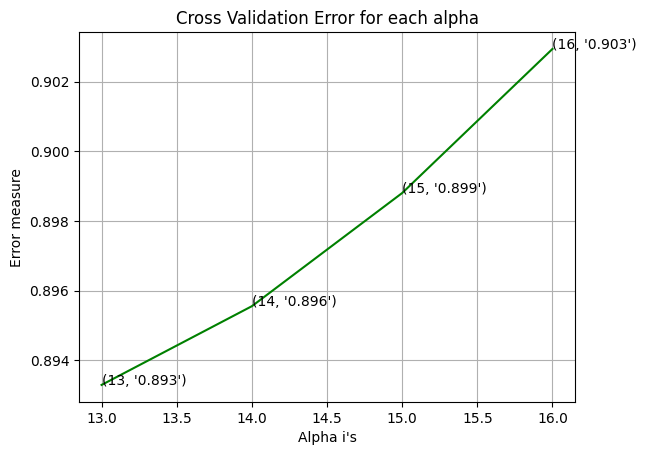

For values of best alpha =  13 The train log loss is: 0.14674722989029507
For values of best alpha =  13 The cross validation log loss is: 0.8932893846123634
For values of best alpha =  13 The test log loss is: 0.9203134487634687


In [56]:
alpha =  [13,14,15,16]
cv_log_error_array = []
for i in alpha:
    print("for alpha =", i)
    clf = KNeighborsClassifier(n_neighbors=i, weights='distance', metric='cosine')
    clf.fit(train_x_responseCoding, train_y)
    sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
    sig_clf.fit(train_x_responseCoding, train_y)
    sig_clf_probs = sig_clf.predict_proba(cv_x_responseCoding)
    cv_log_error_array.append(log_loss(cv_y, sig_clf_probs, labels=clf.classes_, eps=1e-15))
    # to avoid rounding error while multiplying probabilites we use log-probability estimates
    print("Log Loss :",log_loss(cv_y, sig_clf_probs)) 

fig, ax = plt.subplots()
ax.plot(alpha, cv_log_error_array,c='g')
for i, txt in enumerate(np.round(cv_log_error_array,3)):
    ax.annotate((alpha[i],str(txt)), (alpha[i],cv_log_error_array[i]))
plt.grid()
plt.title("Cross Validation Error for each alpha")
plt.xlabel("Alpha i's")
plt.ylabel("Error measure")
plt.show()


best_alpha = np.argmin(cv_log_error_array)
clf = KNeighborsClassifier(n_neighbors=alpha[best_alpha], weights='distance', metric='cosine')
clf.fit(train_x_responseCoding, train_y)
sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(train_x_responseCoding, train_y)

predict_y = sig_clf.predict_proba(train_x_responseCoding)
train_loss=log_loss(y_train, predict_y, labels=clf.classes_, eps=1e-15)
print('For values of best alpha = ', alpha[best_alpha], "The train log loss is:",train_loss)
predict_y = sig_clf.predict_proba(cv_x_responseCoding)
cv_loss=log_loss(y_cv, predict_y, labels=clf.classes_, eps=1e-15)
print('For values of best alpha = ', alpha[best_alpha], "The cross validation log loss is:",cv_loss)
predict_y = sig_clf.predict_proba(test_x_responseCoding)
test_loss=log_loss(y_test, predict_y, labels=clf.classes_, eps=1e-15)
print('For values of best alpha = ', alpha[best_alpha], "The test log loss is:",test_loss)


<h3>4.2.2. Testing the model with best hyper paramters</h3>

Log loss : 0.8932893846123634
Number of mis-classified points : 0.2857142857142857
-------------------- Confusion matrix --------------------


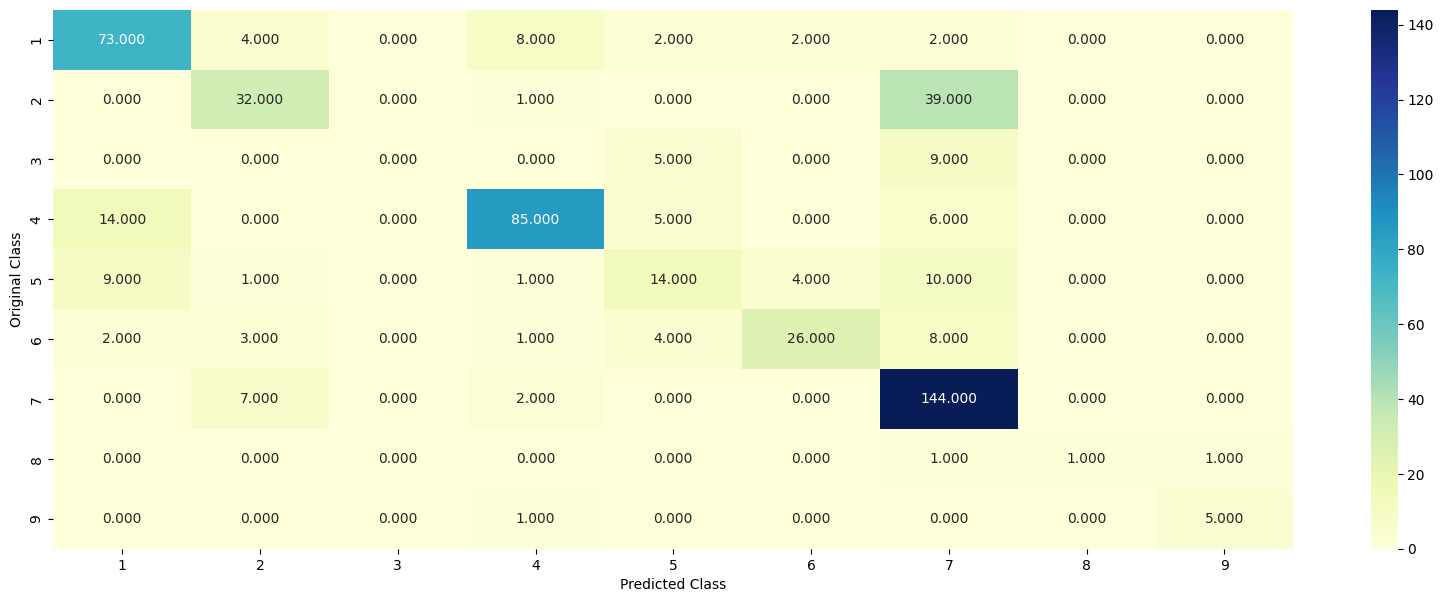

-------------------- Precision matrix (Columm Sum=1) --------------------


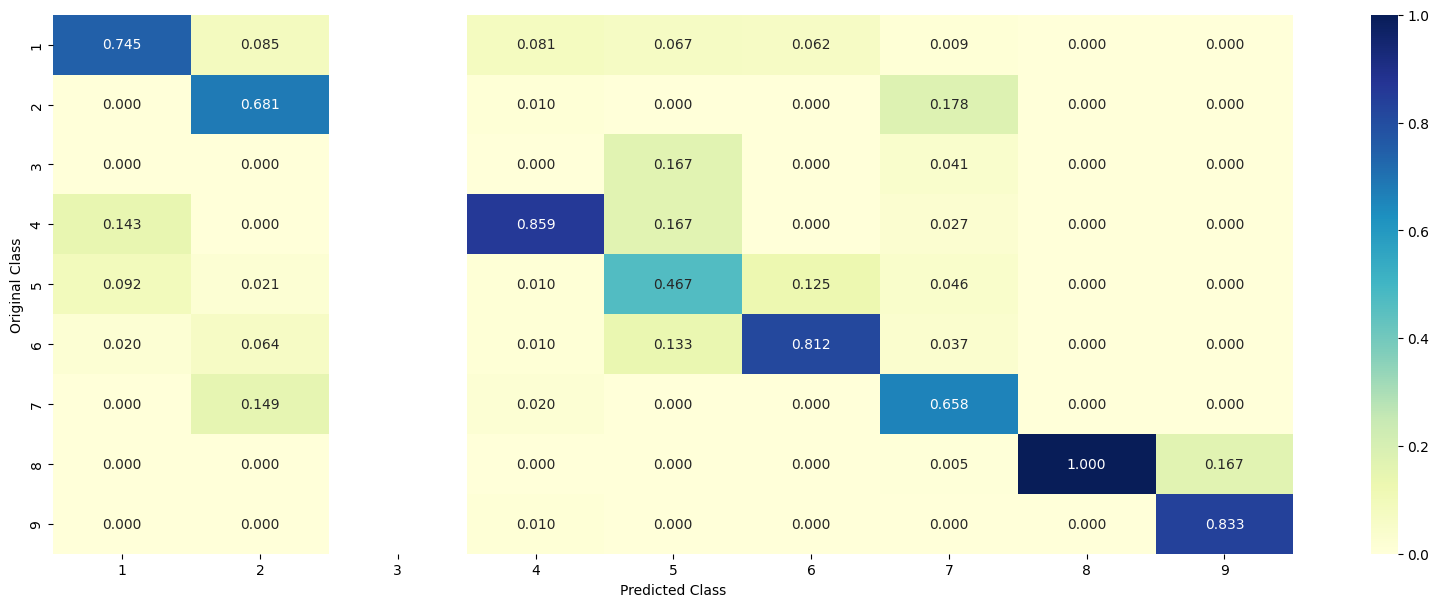

-------------------- Recall matrix (Row sum=1) --------------------


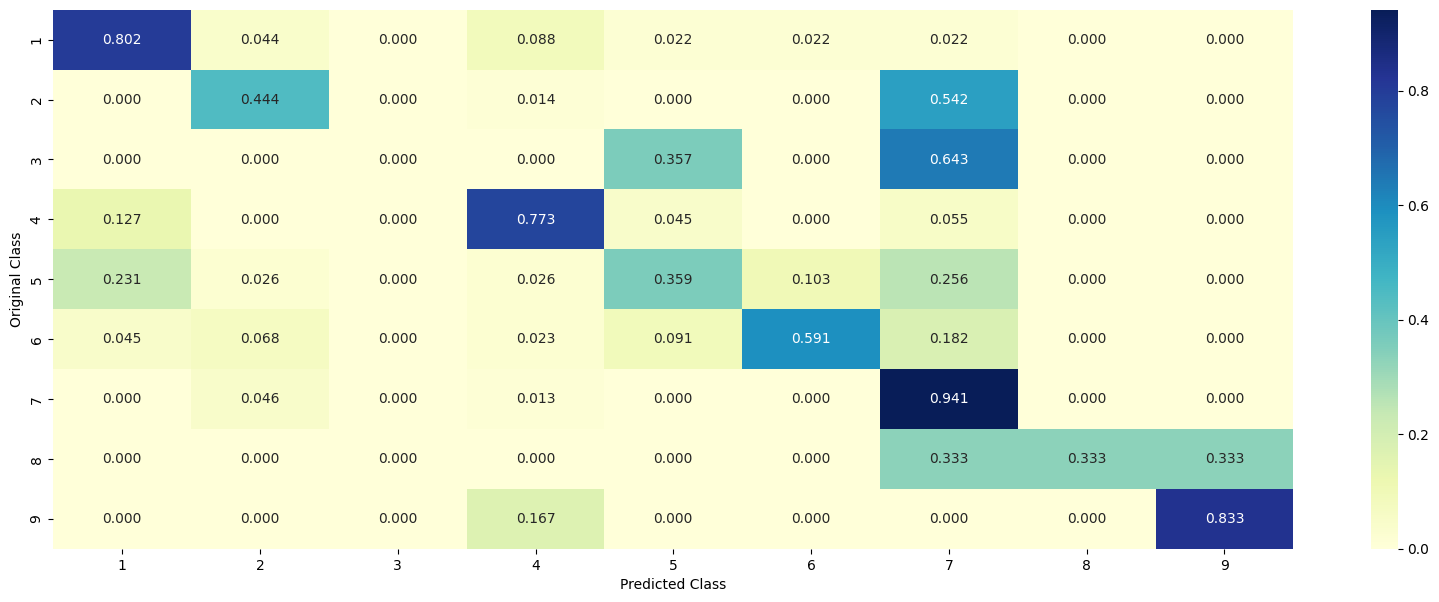

In [57]:
clf = KNeighborsClassifier(n_neighbors=alpha[best_alpha],weights='distance', metric='cosine')
predict_and_plot_confusion_matrix(train_x_responseCoding, train_y, cv_x_responseCoding, cv_y, clf)

<h3>4.2.3.Sample Query point -1</h3>

In [58]:
clf = KNeighborsClassifier(n_neighbors=alpha[best_alpha])
clf.fit(train_x_responseCoding, train_y)
sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(train_x_responseCoding, train_y)

test_point_index = 1
predicted_cls = sig_clf.predict(test_x_responseCoding[test_point_index].reshape(1,-1))  
print("Predicted Class :", predicted_cls[0])
print("Actual Class :", test_y[test_point_index])
neighbors = clf.kneighbors(test_x_responseCoding[test_point_index].reshape(1, -1), alpha[best_alpha])
print("The ",alpha[best_alpha]," nearest neighbours of the test points belongs to classes",train_y[neighbors[1][0]])
print("Fequency of nearest points :",Counter(train_y[neighbors[1][0]]))

Predicted Class : 7
Actual Class : 7
The  13  nearest neighbours of the test points belongs to classes [7 2 2 7 7 7 7 2 2 7 7 7 7]
Fequency of nearest points : Counter({7: 9, 2: 4})


#### 1. KNN is not much interpretable, we only get to know K nearest neighbours. But NB was very well interpretable, we got all classes probabilities along with the words/features that contribute to the predicted class label.
#### 2. we cannot get feature importances

#### So, KNN is not satisfying our objective of good interpretability

<h3>4.2.4. Sample Query Point-2 </h3>

In [59]:
clf = KNeighborsClassifier(n_neighbors=alpha[best_alpha])
clf.fit(train_x_responseCoding, train_y)
sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(train_x_responseCoding, train_y)

test_point_index = 100

predicted_cls = sig_clf.predict(test_x_responseCoding[test_point_index].reshape(1,-1))
print("Predicted Class :", predicted_cls[0])
print("Actual Class :", test_y[test_point_index])
neighbors = clf.kneighbors(test_x_responseCoding[test_point_index].reshape(1, -1), alpha[best_alpha])
print("the k value for knn is",alpha[best_alpha],"and the nearest neighbours of the test points belongs to classes",train_y[neighbors[1][0]])
print("Fequency of nearest points :",Counter(train_y[neighbors[1][0]]))

Predicted Class : 4
Actual Class : 4
the k value for knn is 13 and the nearest neighbours of the test points belongs to classes [4 4 4 4 4 4 4 4 4 4 4 4 4]
Fequency of nearest points : Counter({4: 13})


<h2>4.3. Logistic Regression</h2>

<h3>4.3.1. With Class balancing</h3>

#### Using One-Hot Features

<h4>4.3.1.1. Hyper paramter tuning</h4>

for alpha = 1e-05
Log Loss : 1.8308895093721704
for alpha = 0.0001
Log Loss : 1.8308895093721704
for alpha = 0.001
Log Loss : 1.326642058216459
for alpha = 0.01
Log Loss : 1.3056819145717462
for alpha = 0.1
Log Loss : 1.2888846289253357
for alpha = 1
Log Loss : 1.195965634165163
for alpha = 10
Log Loss : 1.1823591709034047


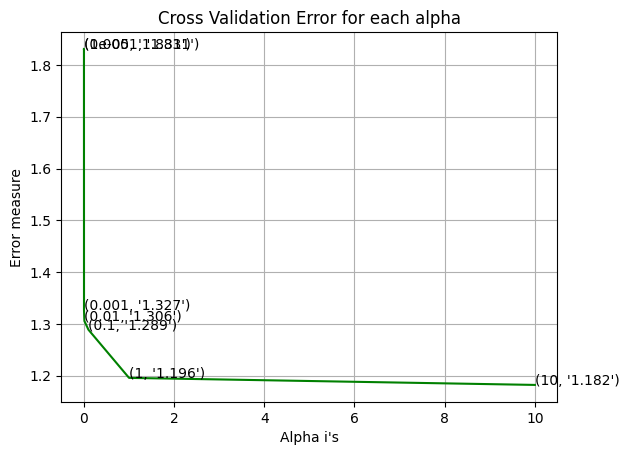

For values of best alpha =  10 The train log loss is: 0.8787762031201294
For values of best alpha =  10 The cross validation log loss is: 1.1823591709034047
For values of best alpha =  10 The test log loss is: 1.1833198270145742


In [69]:

alpha = [10 ** x for x in range(-5, 2)]
cv_log_error_array = []
for i in alpha:
    print("for alpha =", i)
    clf = SGDClassifier(class_weight='balanced', alpha=i, penalty='l2', loss='log', random_state=41)
    sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
    sig_clf.fit(train_x_onehotCoding, train_y)
    sig_clf_probs = sig_clf.predict_proba(cv_x_onehotCoding)
    cv_log_error_array.append(log_loss(cv_y, sig_clf_probs, labels=result.Class.unique(), eps=1e-15))
    # to avoid rounding error while multiplying probabilites we use log-probability estimates
    print("Log Loss :",log_loss(cv_y, sig_clf_probs)) 

fig, ax = plt.subplots()
ax.plot(alpha, cv_log_error_array,c='g')
for i, txt in enumerate(np.round(cv_log_error_array,3)):
    ax.annotate((alpha[i],str(txt)), (alpha[i],cv_log_error_array[i]))
plt.grid()
plt.title("Cross Validation Error for each alpha")
plt.xlabel("Alpha i's")
plt.ylabel("Error measure")
plt.show()


best_alpha = np.argmin(cv_log_error_array)
clf = SGDClassifier(class_weight='balanced', alpha=alpha[best_alpha], penalty='l2', loss='log', random_state=41)
sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(train_x_onehotCoding, train_y)


predict_y = sig_clf.predict_proba(train_x_onehotCoding)
train_loss=log_loss(y_train, predict_y, labels=result.Class.unique() ,eps=1e-15)
print('For values of best alpha = ', alpha[best_alpha], "The train log loss is:",train_loss)
predict_y = sig_clf.predict_proba(cv_x_onehotCoding)
cv_loss=log_loss(y_cv, predict_y, labels=result.Class.unique(), eps=1e-15)
print('For values of best alpha = ', alpha[best_alpha], "The cross validation log loss is:",cv_loss)
predict_y = sig_clf.predict_proba(test_x_onehotCoding)
test_loss=log_loss(y_test, predict_y, labels=result.Class.unique(), eps=1e-15)
print('For values of best alpha = ', alpha[best_alpha], "The test log loss is:",test_loss)


### Using Elasticnet

for alpha = 1e-05
Log Loss : 1.8308895093721704
for alpha = 0.0001
Log Loss : 1.8308895093721704
for alpha = 0.001
Log Loss : 1.3256279818433092
for alpha = 0.01
Log Loss : 1.3016102616862295
for alpha = 0.1
Log Loss : 1.315833504631682
for alpha = 1
Log Loss : 1.4088072242989
for alpha = 10
Log Loss : 1.7293594960911236


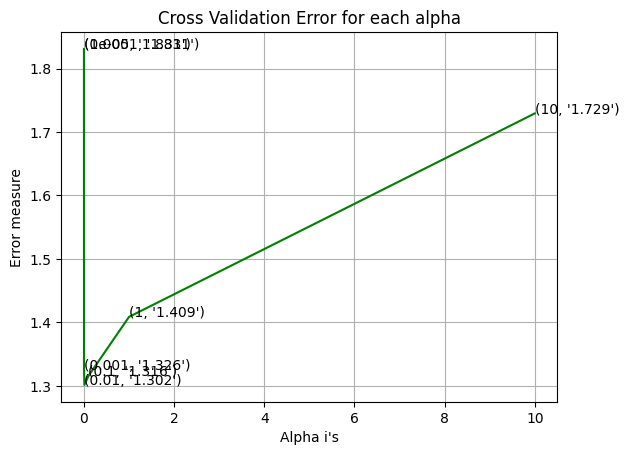

For values of best alpha =  0.01 The train log loss is: 0.963374483909704
For values of best alpha =  0.01 The cross validation log loss is: 1.3016102616862295
For values of best alpha =  0.01 The test log loss is: 1.3017084009076876


In [70]:

alpha = [10 ** x for x in range(-5, 2)]
cv_log_error_array = []
for i in alpha:
    print("for alpha =", i)
    clf = SGDClassifier(class_weight='balanced', alpha=i, penalty='elasticnet', loss='log', random_state=42)
    sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
    sig_clf.fit(train_x_onehotCoding, train_y)
    sig_clf_probs = sig_clf.predict_proba(cv_x_onehotCoding)
    cv_log_error_array.append(log_loss(cv_y, sig_clf_probs, labels=result.Class.unique(), eps=1e-15))
    # to avoid rounding error while multiplying probabilites we use log-probability estimates
    print("Log Loss :",log_loss(cv_y, sig_clf_probs)) 

fig, ax = plt.subplots()
ax.plot(alpha, cv_log_error_array,c='g')
for i, txt in enumerate(np.round(cv_log_error_array,3)):
    ax.annotate((alpha[i],str(txt)), (alpha[i],cv_log_error_array[i]))
plt.grid()
plt.title("Cross Validation Error for each alpha")
plt.xlabel("Alpha i's")
plt.ylabel("Error measure")
plt.show()


best_alpha = np.argmin(cv_log_error_array)
clf = SGDClassifier(class_weight='balanced', alpha=alpha[best_alpha], penalty='elasticnet', loss='log', random_state=42)
sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(train_x_onehotCoding, train_y)


predict_y = sig_clf.predict_proba(train_x_onehotCoding)
train_loss=log_loss(y_train, predict_y, labels=result.Class.unique(), eps=1e-15)
print('For values of best alpha = ', alpha[best_alpha], "The train log loss is:",train_loss)
predict_y = sig_clf.predict_proba(cv_x_onehotCoding)
cv_loss=log_loss(y_cv, predict_y, labels=result.Class.unique(), eps=1e-15)
print('For values of best alpha = ', alpha[best_alpha], "The cross validation log loss is:",cv_loss)
predict_y = sig_clf.predict_proba(test_x_onehotCoding)
test_loss=log_loss(y_test, predict_y, labels=result.Class.unique(), eps=1e-15)
print('For values of best alpha = ', alpha[best_alpha], "The test log loss is:",test_loss)


<h4>4.3.1.2. Testing the model with best hyper paramters</h4>

Log loss : 1.3016102616862295
Number of mis-classified points : 0.4266917293233083
-------------------- Confusion matrix --------------------


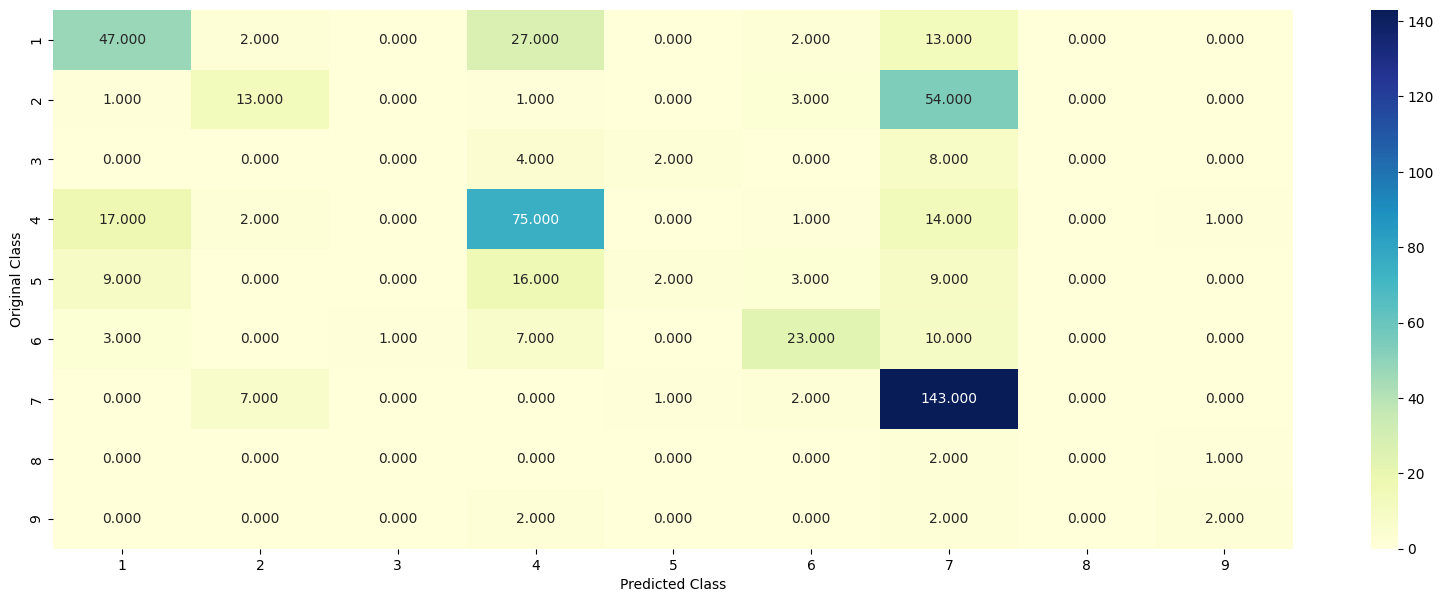

-------------------- Precision matrix (Columm Sum=1) --------------------


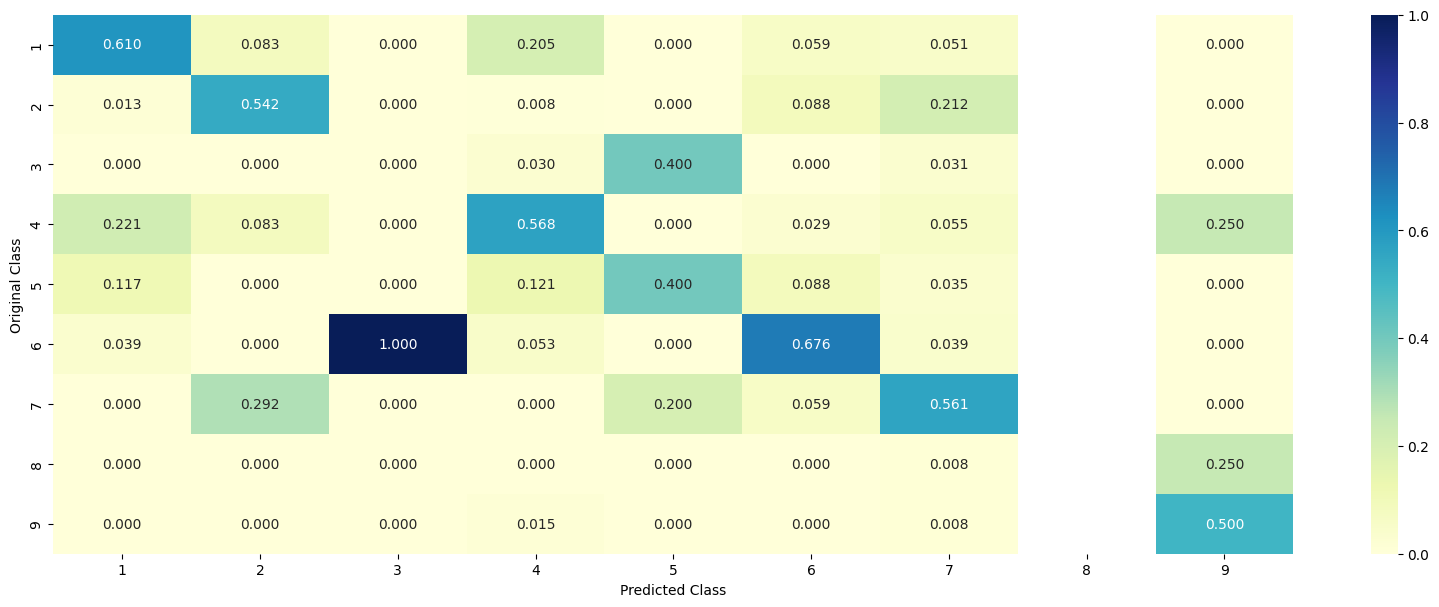

-------------------- Recall matrix (Row sum=1) --------------------


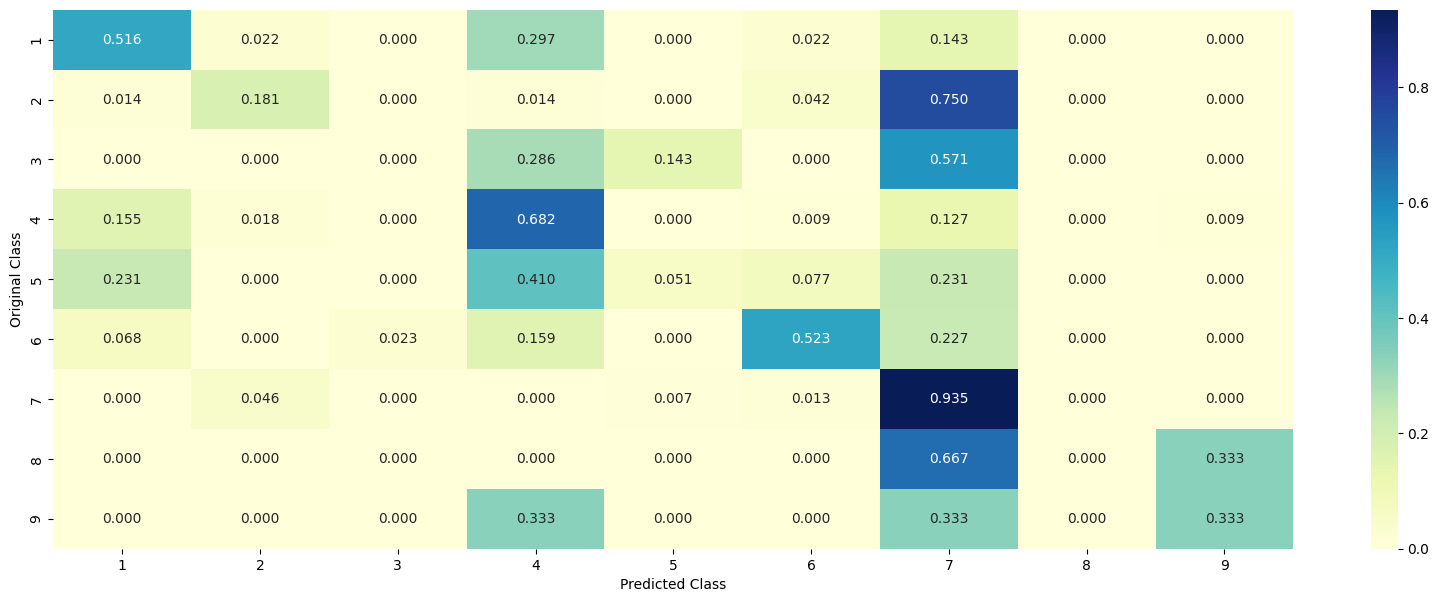

In [71]:
clf = SGDClassifier(class_weight='balanced', alpha=alpha[best_alpha], penalty='elasticnet', loss='log', random_state=42)
predict_and_plot_confusion_matrix(train_x_onehotCoding, train_y, cv_x_onehotCoding, cv_y, clf)

<h4>4.3.1.3. Feature Importance</h4>

In [72]:
def get_imp_feature_names(text, indices, removed_ind = []):
    word_present = 0
    tabulte_list = []
    incresingorder_ind = 0
    for i in indices:
        if i < train_gene_feature_onehotCoding.shape[1]:
            tabulte_list.append([incresingorder_ind, "Gene", "Yes"])
        elif i< 18:
            tabulte_list.append([incresingorder_ind,"Variation", "Yes"])
        if ((i > 17) & (i not in removed_ind)) :
            word = train_text_features[i]
            yes_no = True if word in text.split() else False
            if yes_no:
                word_present += 1
            tabulte_list.append([incresingorder_ind,train_text_features[i], yes_no])
        incresingorder_ind += 1
    print(word_present, "most importent features are present in our query point")
    print("-"*50)
    print("The features that are most importent of the ",predicted_cls[0]," class:")
    print (tabulate(tabulte_list, headers=["Index",'Feature name', 'Present or Not']))

<h5>4.3.1.3.1. Correctly Classified point</h5>

In [73]:

clf = SGDClassifier(class_weight='balanced', alpha=alpha[best_alpha], penalty='elasticnet', loss='log', random_state=42)
clf.fit(train_x_onehotCoding,train_y)
test_point_index = 1
no_feature = 500
predicted_cls = sig_clf.predict(test_x_onehotCoding[test_point_index])
print("Predicted Class :", predicted_cls[0])
print("Predicted Class Probabilities:", np.round(sig_clf.predict_proba(test_x_onehotCoding[test_point_index]),4))
print("Actual Class :", test_y[test_point_index])
indices = np.argsort(-1*abs(clf.coef_))[predicted_cls-1][:,:no_feature]
print("-"*50)
get_impfeature_names(indices[0], test_df['TEXT'].iloc[test_point_index],test_df['Gene'].iloc[test_point_index],test_df['Variation'].iloc[test_point_index], no_feature)

Predicted Class : 7
Predicted Class Probabilities: [[0.0994 0.2103 0.0239 0.145  0.1399 0.059  0.304  0.009  0.0096]]
Actual Class : 7
--------------------------------------------------
3 Text feature [compound] present in test data point [True]
7 Text feature [also] present in test data point [True]
8 Text feature [activated] present in test data point [True]
12 Text feature [therapy] present in test data point [True]
22 Text feature [lipid] present in test data point [True]
23 Text feature [11] present in test data point [True]
25 Text feature [loss] present in test data point [True]
27 Text feature [smad4] present in test data point [True]
33 Text feature [analyzed] present in test data point [True]
34 Text feature [men1] present in test data point [True]
39 Text feature [18] present in test data point [True]
40 Text feature [31] present in test data point [True]
42 Text feature [per] present in test data point [True]
56 Text feature [conditions] present in test data point [True]
57

415 Text feature [46] present in test data point [True]
417 Text feature [collection] present in test data point [True]
423 Text feature [detection] present in test data point [True]
426 Text feature [minutes] present in test data point [True]
432 Text feature [approximately] present in test data point [True]
439 Text feature [vemurafenib] present in test data point [True]
448 Text feature [genome] present in test data point [True]
450 Text feature [f3] present in test data point [True]
453 Text feature [cytokine] present in test data point [True]
457 Text feature [role] present in test data point [True]
459 Text feature [ihc] present in test data point [True]
461 Text feature [16] present in test data point [True]
465 Text feature [strand] present in test data point [True]
466 Text feature [harboring] present in test data point [True]
470 Text feature [wildtype] present in test data point [True]
473 Text feature [regions] present in test data point [True]
477 Text feature [efficacy] p

<h5>4.3.1.3.2. Incorrectly Classified point</h5>

In [74]:
test_point_index = 100
no_feature = 500
predicted_cls = sig_clf.predict(test_x_onehotCoding[test_point_index])
print("Predicted Class :", predicted_cls[0])
print("Predicted Class Probabilities:", np.round(sig_clf.predict_proba(test_x_onehotCoding[test_point_index]),4))
print("Actual Class :", test_y[test_point_index])
indices = np.argsort(-1*abs(clf.coef_))[predicted_cls-1][:,:no_feature]
print("-"*50)
get_impfeature_names(indices[0], test_df['TEXT'].iloc[test_point_index],test_df['Gene'].iloc[test_point_index],test_df['Variation'].iloc[test_point_index], no_feature)

Predicted Class : 4
Predicted Class Probabilities: [[0.088  0.0405 0.0082 0.8425 0.011  0.0011 0.0029 0.0048 0.001 ]]
Actual Class : 4
--------------------------------------------------
4 Text feature [tumors] present in test data point [True]
9 Text feature [sequence] present in test data point [True]
12 Text feature [protein] present in test data point [True]
13 Text feature [model] present in test data point [True]
16 Text feature [compared] present in test data point [True]
20 Text feature [interactions] present in test data point [True]
25 Text feature [analyses] present in test data point [True]
26 Text feature [functional] present in test data point [True]
28 Text feature [activation] present in test data point [True]
29 Text feature [amino] present in test data point [True]
31 Text feature [significantly] present in test data point [True]
33 Text feature [following] present in test data point [True]
34 Text feature [target] present in test data point [True]
35 Text feature [spo

363 Text feature [uv] present in test data point [True]
365 Text feature [nucleus] present in test data point [True]
366 Text feature [min] present in test data point [True]
371 Text feature [therefore] present in test data point [True]
375 Text feature [supplemental] present in test data point [True]
376 Text feature [occur] present in test data point [True]
377 Text feature [region] present in test data point [True]
378 Text feature [tested] present in test data point [True]
379 Text feature [related] present in test data point [True]
382 Text feature [significance] present in test data point [True]
397 Text feature [view] present in test data point [True]
398 Text feature [method] present in test data point [True]
399 Text feature [src] present in test data point [True]
403 Text feature [used] present in test data point [True]
405 Text feature [pathway] present in test data point [True]
406 Text feature [e3] present in test data point [True]
408 Text feature [proteins] present in te

<h3>4.3.2. Without Class balancing</h3>

#### Using One-Hot Features

<h4>4.3.2.1. Hyper paramter tuning</h4>

for alpha = 1e-05
Log Loss : 1.8308895093721704
for alpha = 0.0001
Log Loss : 1.818014505915095
for alpha = 0.001
Log Loss : 1.30043132418904
for alpha = 0.01
Log Loss : 1.302752652431544
for alpha = 0.1
Log Loss : 1.2852337261423168
for alpha = 1
Log Loss : 1.2243201441417204


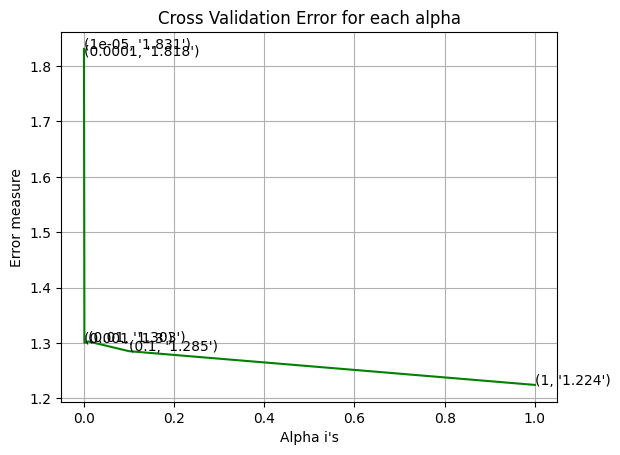

For values of best alpha =  1 The train log loss is: 0.8238304481462696
For values of best alpha =  1 The cross validation log loss is: 1.2243201441417204
For values of best alpha =  1 The test log loss is: 1.2083633554920805


In [75]:

alpha = [10 ** x for x in range(-5, 1)]
cv_log_error_array = []
for i in alpha:
    print("for alpha =", i)
    clf = SGDClassifier(alpha=i, penalty='l2', loss='log', random_state=42)
    sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
    sig_clf.fit(train_x_onehotCoding, train_y)
    sig_clf_probs = sig_clf.predict_proba(cv_x_onehotCoding)
    cv_log_error_array.append(log_loss(cv_y, sig_clf_probs, labels=result.Class.unique(), eps=1e-15))
    print("Log Loss :",log_loss(cv_y, sig_clf_probs)) 

fig, ax = plt.subplots()
ax.plot(alpha, cv_log_error_array,c='g')
for i, txt in enumerate(np.round(cv_log_error_array,3)):
    ax.annotate((alpha[i],str(txt)), (alpha[i],cv_log_error_array[i]))
plt.grid()
plt.title("Cross Validation Error for each alpha")
plt.xlabel("Alpha i's")
plt.ylabel("Error measure")
plt.show()


best_alpha = np.argmin(cv_log_error_array)
clf = SGDClassifier(alpha=alpha[best_alpha], penalty='l2', loss='log', random_state=42)
sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(train_x_onehotCoding, train_y)

predict_y = sig_clf.predict_proba(train_x_onehotCoding)
train_loss=log_loss(y_train, predict_y, labels=result.Class.unique(), eps=1e-15)
print('For values of best alpha = ', alpha[best_alpha], "The train log loss is:",train_loss)
predict_y = sig_clf.predict_proba(cv_x_onehotCoding)
cv_loss=log_loss(y_cv, predict_y, labels=result.Class.unique(), eps=1e-15)
print('For values of best alpha = ', alpha[best_alpha], "The cross validation log loss is:",cv_loss)
predict_y = sig_clf.predict_proba(test_x_onehotCoding)
test_loss=log_loss(y_test, predict_y, labels=result.Class.unique(), eps=1e-15)
print('For values of best alpha = ', alpha[best_alpha], "The test log loss is:",test_loss)


### Using Elasticnet

for alpha = 1e-05
Log Loss : 1.8308895093721704
for alpha = 0.0001
Log Loss : 1.8308895093721704
for alpha = 0.001
Log Loss : 1.2994869116909784
for alpha = 0.01
Log Loss : 1.2915239769270095
for alpha = 0.1
Log Loss : 1.3103529153155722
for alpha = 1
Log Loss : 1.381094105301255


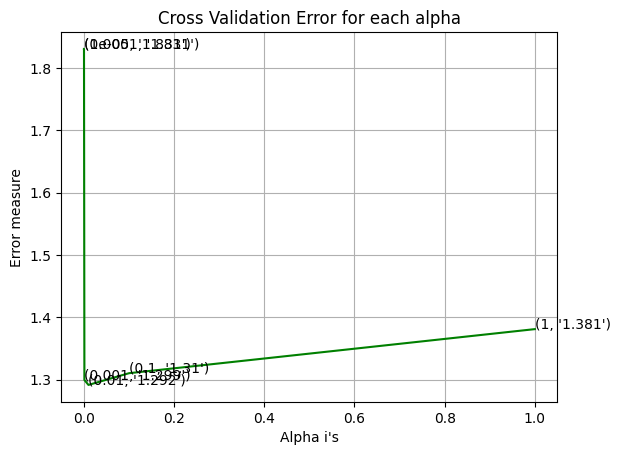

For values of best alpha =  0.01 The train log loss is: 0.9425027919698811
For values of best alpha =  0.01 The cross validation log loss is: 1.2915239769270095
For values of best alpha =  0.01 The test log loss is: 1.292146163665716


In [76]:

alpha = [10 ** x for x in range(-5, 1)]
cv_log_error_array = []
for i in alpha:
    print("for alpha =", i)
    clf = SGDClassifier(alpha=i, penalty='elasticnet', loss='log', random_state=42)
    sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
    sig_clf.fit(train_x_onehotCoding, train_y)
    sig_clf_probs = sig_clf.predict_proba(cv_x_onehotCoding)
    cv_log_error_array.append(log_loss(cv_y, sig_clf_probs, labels=result.Class.unique(), eps=1e-15))
    print("Log Loss :",log_loss(cv_y, sig_clf_probs)) 

fig, ax = plt.subplots()
ax.plot(alpha, cv_log_error_array,c='g')
for i, txt in enumerate(np.round(cv_log_error_array,3)):
    ax.annotate((alpha[i],str(txt)), (alpha[i],cv_log_error_array[i]))
plt.grid()
plt.title("Cross Validation Error for each alpha")
plt.xlabel("Alpha i's")
plt.ylabel("Error measure")
plt.show()


best_alpha = np.argmin(cv_log_error_array)
clf = SGDClassifier(alpha=alpha[best_alpha], penalty='elasticnet', loss='log', random_state=42)
sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(train_x_onehotCoding, train_y)

predict_y = sig_clf.predict_proba(train_x_onehotCoding)
train_loss=log_loss(y_train, predict_y, labels=result.Class.unique() ,eps=1e-15)
print('For values of best alpha = ', alpha[best_alpha], "The train log loss is:",train_loss)
predict_y = sig_clf.predict_proba(cv_x_onehotCoding)
cv_loss=log_loss(y_cv, predict_y, labels=result.Class.unique(), eps=1e-15)
print('For values of best alpha = ', alpha[best_alpha], "The cross validation log loss is:",cv_loss)
predict_y = sig_clf.predict_proba(test_x_onehotCoding)
test_loss=log_loss(y_test, predict_y, labels=result.Class.unique(), eps=1e-15)
print('For values of best alpha = ', alpha[best_alpha], "The test log loss is:",test_loss)


Log loss : 1.2915239769270095
Number of mis-classified points : 0.4342105263157895
-------------------- Confusion matrix --------------------


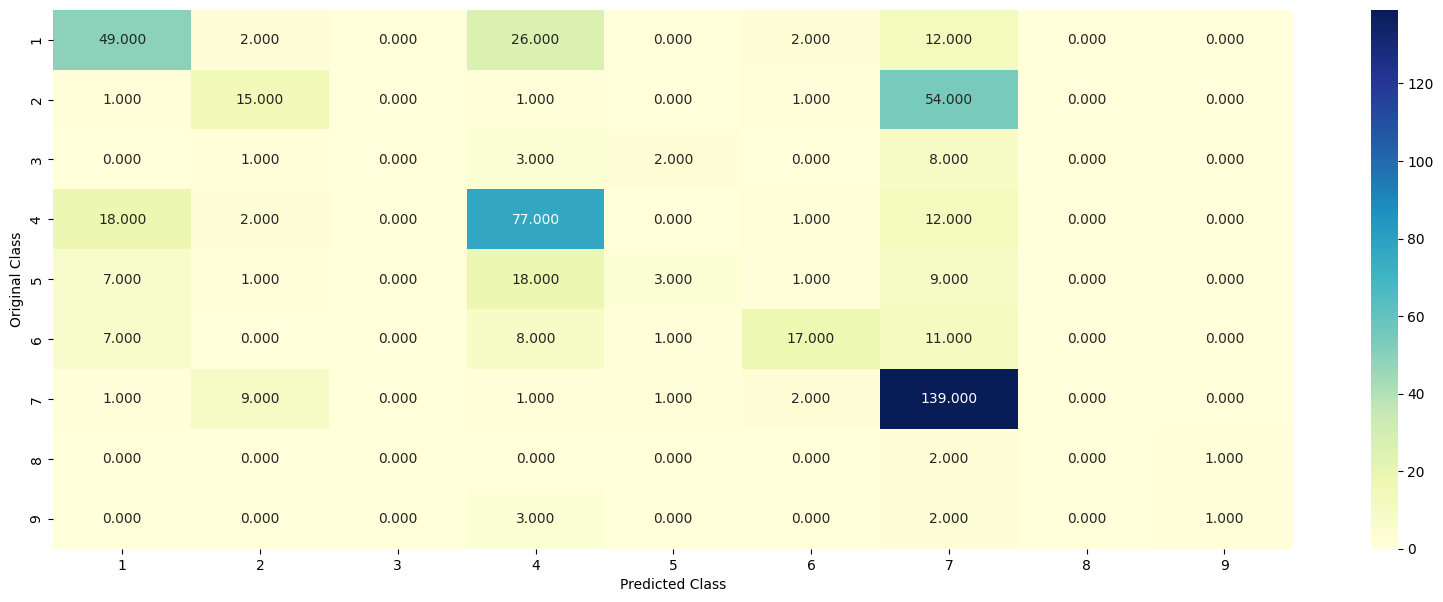

-------------------- Precision matrix (Columm Sum=1) --------------------


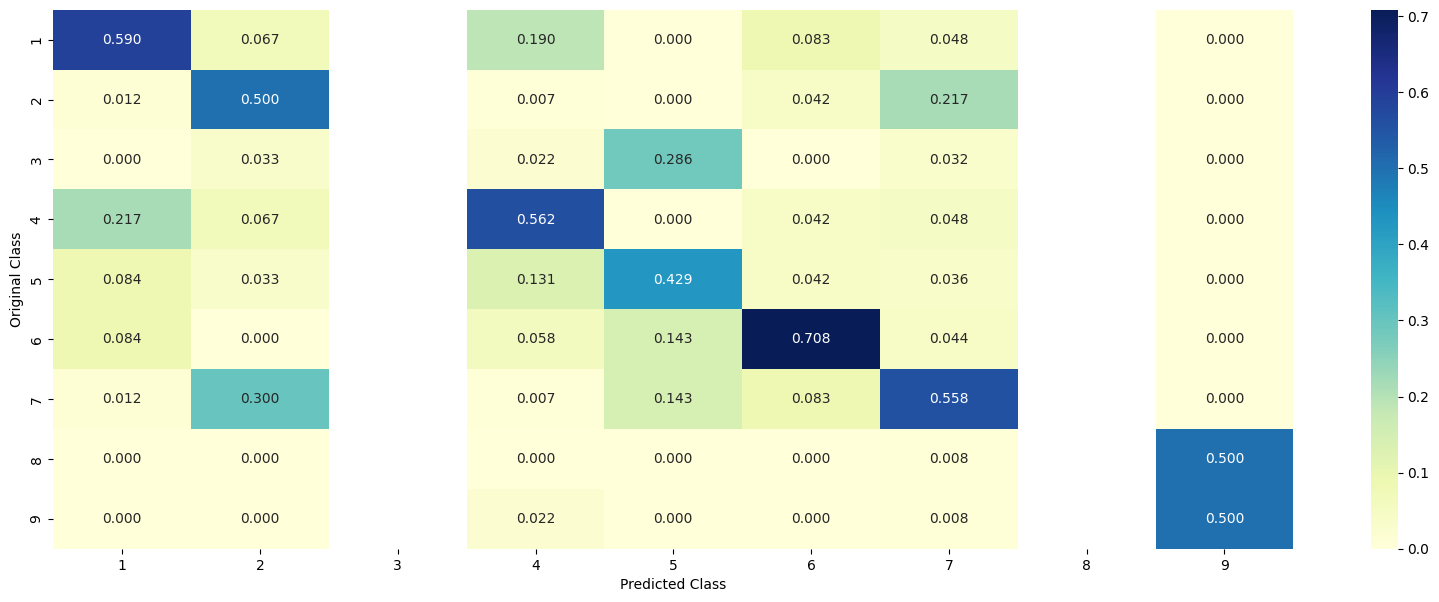

-------------------- Recall matrix (Row sum=1) --------------------


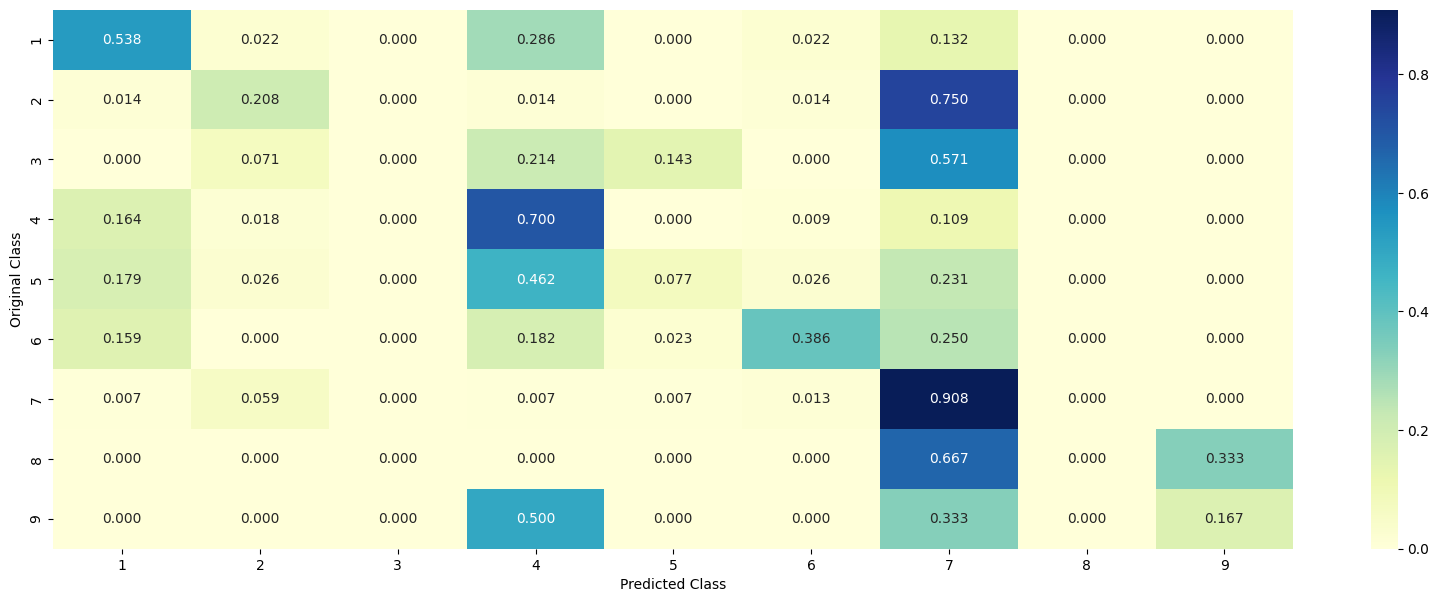

In [77]:
clf = SGDClassifier(alpha=alpha[best_alpha], penalty='elasticnet', loss='log', random_state=42)
predict_and_plot_confusion_matrix(train_x_onehotCoding, train_y, cv_x_onehotCoding, cv_y, clf)

<h4>4.3.2.3. Feature Importance, Correctly Classified point</h4>

In [78]:
clf = SGDClassifier(alpha=alpha[best_alpha], penalty='l2', loss='log', random_state=42)
clf.fit(train_x_onehotCoding,train_y)
test_point_index = 1
no_feature = 500
predicted_cls = sig_clf.predict(test_x_onehotCoding[test_point_index])
print("Predicted Class :", predicted_cls[0])
print("Predicted Class Probabilities:", np.round(sig_clf.predict_proba(test_x_onehotCoding[test_point_index]),4))
print("Actual Class :", test_y[test_point_index])
indices = np.argsort(-1*abs(clf.coef_))[predicted_cls-1][:,:no_feature]
print("-"*50)
get_impfeature_names(indices[0], test_df['TEXT'].iloc[test_point_index],test_df['Gene'].iloc[test_point_index],test_df['Variation'].iloc[test_point_index], no_feature)

Predicted Class : 7
Predicted Class Probabilities: [[0.1018 0.2218 0.0288 0.1208 0.129  0.0617 0.32   0.0075 0.0086]]
Actual Class : 7
--------------------------------------------------
0 Text feature [11] present in test data point [True]
3 Text feature [activated] present in test data point [True]
5 Text feature [loss] present in test data point [True]
9 Text feature [therapy] present in test data point [True]
16 Text feature [compound] present in test data point [True]
18 Text feature [18] present in test data point [True]
20 Text feature [similar] present in test data point [True]
25 Text feature [lipid] present in test data point [True]
27 Text feature [number] present in test data point [True]
28 Text feature [also] present in test data point [True]
35 Text feature [missense] present in test data point [True]
44 Text feature [analyzed] present in test data point [True]
45 Text feature [pi3k] present in test data point [True]
51 Text feature [control] present in test data point [T

406 Text feature [previous] present in test data point [True]
410 Text feature [clinical] present in test data point [True]
414 Text feature [jak2] present in test data point [True]
415 Text feature [human] present in test data point [True]
419 Text feature [suv] present in test data point [True]
422 Text feature [pcr] present in test data point [True]
431 Text feature [frequent] present in test data point [True]
437 Text feature [tumors] present in test data point [True]
438 Text feature [rate] present in test data point [True]
439 Text feature [tet2] present in test data point [True]
440 Text feature [map2k1] present in test data point [True]
443 Text feature [transcripts] present in test data point [True]
445 Text feature [identify] present in test data point [True]
447 Text feature [mrna] present in test data point [True]
448 Text feature [38] present in test data point [True]
449 Text feature [breakpoint] present in test data point [True]
451 Text feature [molecular] present in te

<h4>4.3.2.4. Feature Importance, Inorrectly Classified point</h4>

In [79]:
test_point_index = 100
no_feature = 500
predicted_cls = sig_clf.predict(test_x_onehotCoding[test_point_index])
print("Predicted Class :", predicted_cls[0])
print("Predicted Class Probabilities:", np.round(sig_clf.predict_proba(test_x_onehotCoding[test_point_index]),4))
print("Actual Class :", test_y[test_point_index])
indices = np.argsort(-1*abs(clf.coef_))[predicted_cls-1][:,:no_feature]
print("-"*50)
get_impfeature_names(indices[0], test_df['TEXT'].iloc[test_point_index],test_df['Gene'].iloc[test_point_index],test_df['Variation'].iloc[test_point_index], no_feature)

Predicted Class : 4
Predicted Class Probabilities: [[0.0538 0.0404 0.011  0.8747 0.0076 0.005  0.0019 0.0041 0.0016]]
Actual Class : 4
--------------------------------------------------
2 Text feature [tumors] present in test data point [True]
4 Text feature [model] present in test data point [True]
5 Text feature [protein] present in test data point [True]
7 Text feature [sequence] present in test data point [True]
10 Text feature [functional] present in test data point [True]
14 Text feature [spop] present in test data point [True]
20 Text feature [interactions] present in test data point [True]
23 Text feature [activation] present in test data point [True]
27 Text feature [keap1] present in test data point [True]
29 Text feature [interaction] present in test data point [True]
44 Text feature [nuclear] present in test data point [True]
45 Text feature [also] present in test data point [True]
47 Text feature [would] present in test data point [True]
52 Text feature [line] present in t

372 Text feature [elevated] present in test data point [True]
373 Text feature [bind] present in test data point [True]
374 Text feature [patients] present in test data point [True]
380 Text feature [samples] present in test data point [True]
383 Text feature [bound] present in test data point [True]
384 Text feature [washed] present in test data point [True]
386 Text feature [many] present in test data point [True]
387 Text feature [cdna] present in test data point [True]
397 Text feature [induced] present in test data point [True]
398 Text feature [tested] present in test data point [True]
405 Text feature [experiments] present in test data point [True]
408 Text feature [peptide] present in test data point [True]
410 Text feature [revealed] present in test data point [True]
411 Text feature [structures] present in test data point [True]
415 Text feature [early] present in test data point [True]
416 Text feature [showed] present in test data point [True]
419 Text feature [greater] pre

### Logistic Regression with Respose Encoding 
### Using Elasticnet

<h4>4.3.2.2. Testing model with best hyper parameters</h4>

for alpha = 1e-07
Log Loss : 0.6391284513587742
for alpha = 1e-06
Log Loss : 0.5711156397555516
for alpha = 1e-05
Log Loss : 0.8161679244292879
for alpha = 0.0001
Log Loss : 1.0361943992588083
for alpha = 0.001
Log Loss : 1.2456131817735725
for alpha = 0.01
Log Loss : 1.3442728871385743
for alpha = 0.1
Log Loss : 1.8303536124585322
for alpha = 1
Log Loss : 1.8303536125595392
for alpha = 10
Log Loss : 1.8303536134048808


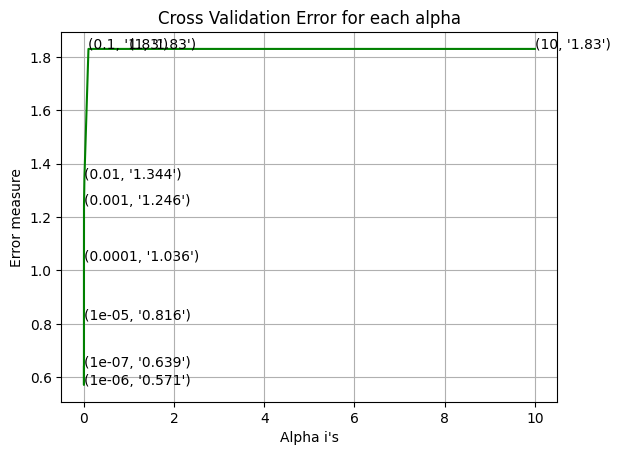

For values of best alpha =  1e-06 The train log loss is: 0.33790625158674104
For values of best alpha =  1e-06 The cross validation log loss is: 0.5711156397555516
For values of best alpha =  1e-06 The test log loss is: 0.5576335080471934


In [80]:

alpha = [10 ** x for x in range(-7, 2)]
cv_log_error_array = []
for i in alpha:
    print("for alpha =", i)
    clf = SGDClassifier(class_weight='balanced', alpha=i, penalty='elasticnet', loss='log', random_state=41)
    sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
    sig_clf.fit(train_x_responseCoding, train_y)
    sig_clf_probs = sig_clf.predict_proba(cv_x_responseCoding)
    cv_log_error_array.append(log_loss(cv_y, sig_clf_probs, labels=result.Class.unique(), eps=1e-15))
    # to avoid rounding error while multiplying probabilites we use log-probability estimates
    print("Log Loss :",log_loss(cv_y, sig_clf_probs)) 

fig, ax = plt.subplots()
ax.plot(alpha, cv_log_error_array,c='g')
for i, txt in enumerate(np.round(cv_log_error_array,3)):
    ax.annotate((alpha[i],str(txt)), (alpha[i],cv_log_error_array[i]))
plt.grid()
plt.title("Cross Validation Error for each alpha")
plt.xlabel("Alpha i's")
plt.ylabel("Error measure")
plt.show()


best_alpha = np.argmin(cv_log_error_array)
clf = SGDClassifier(class_weight='balanced', alpha=alpha[best_alpha], penalty='elasticnet', loss='log', random_state=41)
sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(train_x_responseCoding, train_y)


predict_y = sig_clf.predict_proba(train_x_responseCoding)
train_loss=log_loss(y_train, predict_y, labels=result.Class.unique(), eps=1e-15)
print('For values of best alpha = ', alpha[best_alpha], "The train log loss is:",train_loss)
predict_y = sig_clf.predict_proba(cv_x_responseCoding)
cv_loss=log_loss(y_cv, predict_y, labels=result.Class.unique(), eps=1e-15)
print('For values of best alpha = ', alpha[best_alpha], "The cross validation log loss is:",cv_loss)
predict_y = sig_clf.predict_proba(test_x_responseCoding)
test_loss=log_loss(y_test, predict_y, labels=result.Class.unique(), eps=1e-15)
print('For values of best alpha = ', alpha[best_alpha], "The test log loss is:",test_loss)


<h2>4.4. Linear Support Vector Machines</h2>

#### Linear SVM is very similar to Logistic Regression except it used Hinge Loss. Linear SVM performs very well for High Dim data  and is interpretable

#### We cant design special kernel, so we cannot use Kernel SVM

#### Also, our data is already very high dimensional, so RBF-Kernel would not help much. And RBF-Kernel is not interpretable which is a major disadvantage


### Using One-Hot Features

<h3>4.4.1. Hyper paramter tuning</h3>

for C = 1e-05
Log Loss : 1.3729048312294567
for C = 0.0001
Log Loss : 1.282921525336882
for C = 0.001
Log Loss : 1.1868333771993864
for C = 0.01
Log Loss : 1.165494661208075
for C = 0.1
Log Loss : 1.2623641074148781
for C = 1
Log Loss : 1.6666650302093726
for C = 10
Log Loss : 1.6817026700204476
for C = 100
Log Loss : 1.6817034061595226


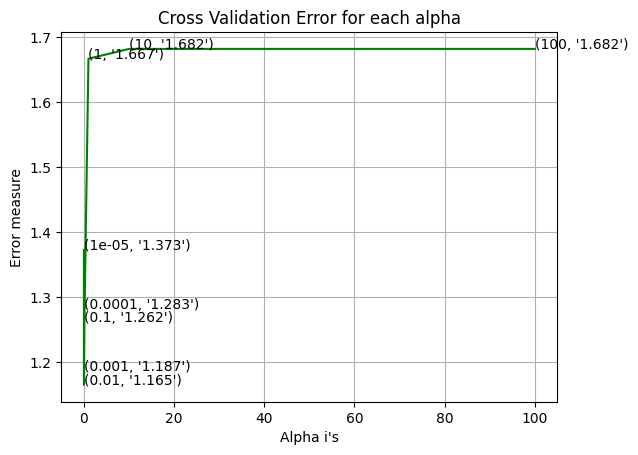

For values of best alpha =  0.01 The train log loss is: 0.6797058439884306
For values of best alpha =  0.01 The cross validation log loss is: 1.165494661208075
For values of best alpha =  0.01 The test log loss is: 1.1481567065725624


In [611]:

alpha = [10 ** x for x in range(-5, 2)]
cv_log_error_array = []
for i in alpha:
    print("for C =", i)
#     clf = SVC(C=i,kernel='linear',probability=True, class_weight='balanced')
    clf = SGDClassifier( class_weight='balanced', alpha=i, penalty='l2', loss='hinge', random_state=42)
    sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
    sig_clf.fit(train_x_onehotCoding, train_y)
    sig_clf_probs = sig_clf.predict_proba(cv_x_onehotCoding)
    cv_log_error_array.append(log_loss(cv_y, sig_clf_probs, labels=result.Class.unique(), eps=1e-15))
    print("Log Loss :",log_loss(cv_y, sig_clf_probs)) 

fig, ax = plt.subplots()
ax.plot(alpha, cv_log_error_array,c='g')
for i, txt in enumerate(np.round(cv_log_error_array,3)):
    ax.annotate((alpha[i],str(txt)), (alpha[i],cv_log_error_array[i]))
plt.grid()
plt.title("Cross Validation Error for each alpha")
plt.xlabel("Alpha i's")
plt.ylabel("Error measure")
plt.show()


best_alpha = np.argmin(cv_log_error_array)
# clf = SVC(C=i,kernel='linear',probability=True, class_weight='balanced')
clf = SGDClassifier(class_weight='balanced', alpha=alpha[best_alpha], penalty='l2', loss='hinge', random_state=42)
sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(train_x_onehotCoding, train_y)

predict_y = sig_clf.predict_proba(train_x_onehotCoding)
train_loss=log_loss(y_train, predict_y, labels=result.Class.unique() ,eps=1e-15)
print('For values of best alpha = ', alpha[best_alpha], "The train log loss is:",train_loss)
predict_y = sig_clf.predict_proba(cv_x_onehotCoding)
cv_loss=log_loss(y_cv, predict_y, labels=result.Class.unique(), eps=1e-15)
print('For values of best alpha = ', alpha[best_alpha], "The cross validation log loss is:",cv_loss)
predict_y = sig_clf.predict_proba(test_x_onehotCoding)
test_loss=log_loss(y_test, predict_y, labels=result.Class.unique(), eps=1e-15)
print('For values of best alpha = ', alpha[best_alpha], "The test log loss is:",test_loss)


### Using Elasticnet

for C = 1e-05
Log Loss : 1.3708351342108507
for C = 0.0001
Log Loss : 1.2583049351936668
for C = 0.001
Log Loss : 1.1933456042495227
for C = 0.01
Log Loss : 1.5465661143681484
for C = 0.1
Log Loss : 1.5641641511417792
for C = 1
Log Loss : 1.8303537480028131
for C = 10
Log Loss : 1.8303537479949563
for C = 100
Log Loss : 1.83035374799479


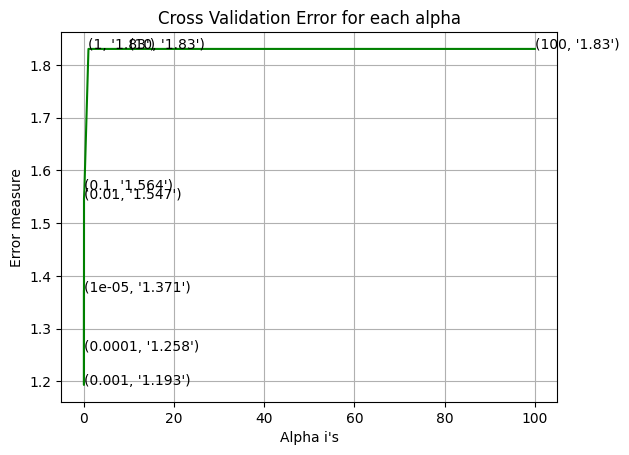

For values of best alpha =  0.001 The train log loss is: 0.6628985877778707
For values of best alpha =  0.001 The cross validation log loss is: 1.1933456042495227
For values of best alpha =  0.001 The test log loss is: 1.1557462012098179


In [613]:

alpha = [10 ** x for x in range(-5, 2)]
cv_log_error_array = []
for i in alpha:
    print("for C =", i)
#     clf = SVC(C=i,kernel='linear',probability=True, class_weight='balanced')
    clf = SGDClassifier( class_weight='balanced', alpha=i, penalty='elasticnet', loss='hinge', random_state=42)
    sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
    sig_clf.fit(train_x_onehotCoding, train_y)
    sig_clf_probs = sig_clf.predict_proba(cv_x_onehotCoding)
    cv_log_error_array.append(log_loss(cv_y, sig_clf_probs, labels=result.Class.unique(), eps=1e-15))
    print("Log Loss :",log_loss(cv_y, sig_clf_probs)) 

fig, ax = plt.subplots()
ax.plot(alpha, cv_log_error_array,c='g')
for i, txt in enumerate(np.round(cv_log_error_array,3)):
    ax.annotate((alpha[i],str(txt)), (alpha[i],cv_log_error_array[i]))
plt.grid()
plt.title("Cross Validation Error for each alpha")
plt.xlabel("Alpha i's")
plt.ylabel("Error measure")
plt.show()


best_alpha = np.argmin(cv_log_error_array)
# clf = SVC(C=i,kernel='linear',probability=True, class_weight='balanced')
clf = SGDClassifier(class_weight='balanced', alpha=alpha[best_alpha], penalty='elasticnet', loss='hinge', random_state=42)
sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(train_x_onehotCoding, train_y)

predict_y = sig_clf.predict_proba(train_x_onehotCoding)
train_loss=log_loss(y_train, predict_y, labels=result.Class.unique(), eps=1e-15)
print('For values of best alpha = ', alpha[best_alpha], "The train log loss is:",train_loss)
predict_y = sig_clf.predict_proba(cv_x_onehotCoding)
cv_loss=log_loss(y_cv, predict_y, labels=result.Class.unique(), eps=1e-15)
print('For values of best alpha = ', alpha[best_alpha], "The cross validation log loss is:",cv_loss)
predict_y = sig_clf.predict_proba(test_x_onehotCoding)
test_loss=log_loss(y_test, predict_y, labels=result.Class.unique(), eps=1e-15)
print('For values of best alpha = ', alpha[best_alpha], "The test log loss is:",test_loss)


<h3>4.4.2. Testing model with best hyper parameters</h3>

In [ ]:
clf = SGDClassifier(class_weight='balanced', alpha=alpha[best_alpha], penalty='l2', loss='hinge', random_state=42)
predict_and_plot_confusion_matrix(train_x_onehotCoding, train_y,cv_x_onehotCoding,cv_y, clf)

<h3>4.3.3. Feature Importance</h3>

<h4>4.3.3.1. For Correctly classified point</h4>

In [ ]:
clf = SGDClassifier(class_weight='balanced', alpha=alpha[best_alpha], penalty='l2', loss='hinge', random_state=42)
clf.fit(train_x_onehotCoding,train_y)
test_point_index = 1
# test_point_index = 100
no_feature = 500
predicted_cls = sig_clf.predict(test_x_onehotCoding[test_point_index])
print("Predicted Class :", predicted_cls[0])
print("Predicted Class Probabilities:", np.round(sig_clf.predict_proba(test_x_onehotCoding[test_point_index]),4))
print("Actual Class :", test_y[test_point_index])
indices = np.argsort(-1*abs(clf.coef_))[predicted_cls-1][:,:no_feature]
print("-"*50)
get_impfeature_names(indices[0], test_df['TEXT'].iloc[test_point_index],test_df['Gene'].iloc[test_point_index],test_df['Variation'].iloc[test_point_index], no_feature)

<h4>4.3.3.2. For Incorrectly classified point</h4>

In [ ]:
test_point_index = 100
no_feature = 500
predicted_cls = sig_clf.predict(test_x_onehotCoding[test_point_index])
print("Predicted Class :", predicted_cls[0])
print("Predicted Class Probabilities:", np.round(sig_clf.predict_proba(test_x_onehotCoding[test_point_index]),4))
print("Actual Class :", test_y[test_point_index])
indices = np.argsort(-1*abs(clf.coef_))[predicted_cls-1][:,:no_feature]
print("-"*50)
get_impfeature_names(indices[0], test_df['TEXT'].iloc[test_point_index],test_df['Gene'].iloc[test_point_index],test_df['Variation'].iloc[test_point_index], no_feature)

<h2>4.5 Random Forest Classifier</h2>

#### D.T do not work well with high dim data. R.F are powerful than D.T., but they also not work very well with very high dim data.
#### So, we should use Response Coding for RF, but lets try one hot encoding also as our response coded features are approximate values (may not be accurate) because we used Naive Bayes Assumption.

<h3>4.5.1. Hyper paramter tuning (With One hot Encoding)</h3>

In [619]:

alpha = [50,100,200,500,1000]
max_depth = [5, 10, 15, 20]
cv_log_error_array = []
for i in alpha:
    for j in max_depth:
        print("for n_estimators =", i,"and max depth = ", j)
        clf = RandomForestClassifier(n_estimators=i, criterion='gini', max_depth=j, random_state=42, n_jobs=-1)
        sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
        sig_clf.fit(train_x_onehotCoding, train_y)
        sig_clf_probs = sig_clf.predict_proba(cv_x_onehotCoding)
        cv_log_error_array.append(log_loss(cv_y, sig_clf_probs, labels=result.Class.unique(), eps=1e-15))
        print("Log Loss :",log_loss(cv_y, sig_clf_probs)) 

best_alpha = np.argmin(cv_log_error_array)
clf = RandomForestClassifier(n_estimators=alpha[int(best_alpha/2)], criterion='gini', max_depth=max_depth[int(best_alpha%2)], random_state=42, n_jobs=-1)
sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(train_x_onehotCoding, train_y)

predict_y = sig_clf.predict_proba(train_x_onehotCoding)
print('For values of best estimator = ', alpha[int(best_alpha/2)], "The train log loss is:",log_loss(y_train, predict_y, labels=result.Class.unique(), eps=1e-15))
predict_y = sig_clf.predict_proba(cv_x_onehotCoding)
print('For values of best estimator = ', alpha[int(best_alpha/2)], "The cross validation log loss is:",log_loss(y_cv, predict_y, labels=result.Class.unique(), eps=1e-15))
predict_y = sig_clf.predict_proba(test_x_onehotCoding)
print('For values of best estimator = ', alpha[int(best_alpha/2)], "The test log loss is:",log_loss(y_test, predict_y, labels=result.Class.unique(), eps=1e-15))

<h3>4.5.2. Testing model with best hyper parameters (One Hot Encoding)</h3>

In [620]:
clf = RandomForestClassifier(n_estimators=alpha[int(best_alpha/2)], criterion='gini', max_depth=max_depth[int(best_alpha%2)], random_state=42, n_jobs=-1)
predict_and_plot_confusion_matrix(train_x_onehotCoding, train_y,cv_x_onehotCoding,cv_y, clf)

<h3>4.5.3. Feature Importance</h3>

<h4>4.5.3.1. Correctly Classified point</h4>

In [621]:
# test_point_index = 10
clf = RandomForestClassifier(n_estimators=alpha[int(best_alpha/2)], criterion='gini', max_depth=max_depth[int(best_alpha%2)], random_state=42, n_jobs=-1)
clf.fit(train_x_onehotCoding, train_y)
sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(train_x_onehotCoding, train_y)

test_point_index = 1
no_feature = 100
predicted_cls = sig_clf.predict(test_x_onehotCoding[test_point_index])
print("Predicted Class :", predicted_cls[0])
print("Predicted Class Probabilities:", np.round(sig_clf.predict_proba(test_x_onehotCoding[test_point_index]),4))
print("Actual Class :", test_y[test_point_index])
indices = np.argsort(-clf.feature_importances_)
print("-"*50)
get_impfeature_names(indices[:no_feature], test_df['TEXT'].iloc[test_point_index],test_df['Gene'].iloc[test_point_index],test_df['Variation'].iloc[test_point_index], no_feature)

<h4>4.5.3.2. Inorrectly Classified point</h4>

In [622]:
test_point_index = 100
no_feature = 100
predicted_cls = sig_clf.predict(test_x_onehotCoding[test_point_index])
print("Predicted Class :", predicted_cls[0])
print("Predicted Class Probabilities:", np.round(sig_clf.predict_proba(test_x_onehotCoding[test_point_index]),4))
print("Actuall Class :", test_y[test_point_index])
indices = np.argsort(-clf.feature_importances_)
print("-"*50)
get_impfeature_names(indices[:no_feature], test_df['TEXT'].iloc[test_point_index],test_df['Gene'].iloc[test_point_index],test_df['Variation'].iloc[test_point_index], no_feature)

<h3>4.5.3. Hyper paramter tuning (With Response Coding)</h3>

In [623]:
alpha = [10,50,100,200,500,1000]
max_depth = [2,3,5,10]
cv_log_error_array = []
for i in alpha:
    for j in max_depth:
        print("for n_estimators =", i,"and max depth = ", j)
        clf = RandomForestClassifier(n_estimators=i, criterion='gini', max_depth=j, random_state=42, n_jobs=-1)
        sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
        sig_clf.fit(train_x_responseCoding, train_y)
        sig_clf_probs = sig_clf.predict_proba(cv_x_responseCoding)
        cv_log_error_array.append(log_loss(cv_y, sig_clf_probs, labels=result.Class.unique(), eps=1e-15))
        print("Log Loss :",log_loss(cv_y, sig_clf_probs)) 


best_alpha = np.argmin(cv_log_error_array)
clf = RandomForestClassifier(n_estimators=alpha[int(best_alpha/4)], criterion='gini', max_depth=max_depth[int(best_alpha%4)], random_state=42, n_jobs=-1)
sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(train_x_responseCoding, train_y)

predict_y = sig_clf.predict_proba(train_x_responseCoding)
print('For values of best alpha = ', alpha[int(best_alpha/4)], "The train log loss is:",log_loss(y_train, predict_y, labels=result.Class.unique(), eps=1e-15))
predict_y = sig_clf.predict_proba(cv_x_responseCoding)
print('For values of best alpha = ', alpha[int(best_alpha/4)], "The cross validation log loss is:",log_loss(y_cv, predict_y, labels=result.Class.unique(), eps=1e-15))
predict_y = sig_clf.predict_proba(test_x_responseCoding)
print('For values of best alpha = ', alpha[int(best_alpha/4)], "The test log loss is:",log_loss(y_test, predict_y, labels=result.Class.unique(), eps=1e-15))

#### Even after Hyperparameter tuning, model is highly overfit. This model is useless. We will discard this model.
#### The reason can be :
1. in our featurization (response coding) because response coded features are approximate values (may not be accurate) because we used Naive Bayes Assumption.
2. Or if featurization is correct then, our features are not working well to predict class labels

<h3>4.5.4. Testing model with best hyper parameters (Response Coding)</h3>

In [624]:
clf = RandomForestClassifier(max_depth=max_depth[int(best_alpha%4)], n_estimators=alpha[int(best_alpha/4)], criterion='gini', max_features='auto',random_state=42)
predict_and_plot_confusion_matrix(train_x_responseCoding, train_y,cv_x_responseCoding,cv_y, clf)

<h3>4.5.5. Feature Importance</h3>

<h4>4.5.5.1. Correctly Classified point</h4>

In [625]:
clf = RandomForestClassifier(n_estimators=alpha[int(best_alpha/4)], criterion='gini', max_depth=max_depth[int(best_alpha%4)], random_state=42, n_jobs=-1)
clf.fit(train_x_responseCoding, train_y)
sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(train_x_responseCoding, train_y)


test_point_index = 1
no_feature = 27
predicted_cls = sig_clf.predict(test_x_responseCoding[test_point_index].reshape(1,-1))
print("Predicted Class :", predicted_cls[0])
print("Predicted Class Probabilities:", np.round(sig_clf.predict_proba(test_x_responseCoding[test_point_index].reshape(1,-1)),4))
print("Actual Class :", test_y[test_point_index])
indices = np.argsort(-clf.feature_importances_)
print("-"*50)
for i in indices:
    if i<9:
        print("Gene is important feature")
    elif i<18:
        print("Variation is important feature")
    else:
        print("Text is important feature")

<h4>4.5.5.2. Incorrectly Classified point</h4>

In [626]:
test_point_index = 100
predicted_cls = sig_clf.predict(test_x_responseCoding[test_point_index].reshape(1,-1))
print("Predicted Class :", predicted_cls[0])
print("Predicted Class Probabilities:", np.round(sig_clf.predict_proba(test_x_responseCoding[test_point_index].reshape(1,-1)),4))
print("Actual Class :", test_y[test_point_index])
indices = np.argsort(-clf.feature_importances_)
print("-"*50)
for i in indices:
    if i<9:
        print("Gene is important feature")
    elif i<18:
        print("Variation is important feature")
    else:
        print("Text is important feature")

<h2>4.6 GBDT</h2>

<h3>4.6.1. Hyper paramter tuning (With One hot Encoding)</h3>

In [628]:
from xgboost import XGBClassifier

learning_rate =  [0.1, 0.3, 0.5, 0.7, 0.8]
max_depth = [3, 4, 5, 7]
cv_log_error_array = []
for i in learning_rate:
    for j in max_depth:
        print("for n_estimators =", i,"and max depth = ", j)

        clf = XGBClassifier(objective='multi:softmax', num_class=9, eta=i, max_depth=j, random_state=42, n_jobs=-1)
        sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
        sig_clf.fit(train_x_onehotCoding, train_new)
        sig_clf_probs = sig_clf.predict_proba(cv_x_onehotCoding)
        cv_log_error_array.append(log_loss(cv_y, sig_clf_probs, labels=result.Class.unique(), eps=1e-15))
        print("Log Loss :",log_loss(cv_y, sig_clf_probs)) 

best_alpha = np.argmin(cv_log_error_array)
clf = XGBClassifier(objective='multi:softmax', num_class=9, eta=learning_rate[int(best_alpha/2)], max_depth=max_depth[int(best_alpha%2)], random_state=42, n_jobs=-1)
sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(train_x_onehotCoding, train_new)

predict_y = sig_clf.predict_proba(train_x_onehotCoding)
print('For values of best estimator = ', alpha[int(best_alpha/2)], "The train log loss is:",log_loss(y_train, predict_y, labels=result.Class.unique(), eps=1e-15))
predict_y = sig_clf.predict_proba(cv_x_onehotCoding)
print('For values of best estimator = ', alpha[int(best_alpha/2)], "The cross validation log loss is:",log_loss(y_cv, predict_y, labels=result.Class.unique(), eps=1e-15))
predict_y = sig_clf.predict_proba(test_x_onehotCoding)
print('For values of best estimator = ', alpha[int(best_alpha/2)], "The test log loss is:",log_loss(y_test, predict_y, labels=result.Class.unique(), eps=1e-15))

## Comparing top 3 models for each encoding

In [681]:
df=pd.read_pickle("score_onehot_Binomial.pkl")
print(" Test Performance : \n",df.iloc[2].sort_values().head(3))
print("\n CV Performance : \n",df.iloc[1].sort_values().head(3))

 Test Performance : 
 KNN_Cosine_weigh    0.894678
KNN_Euc_weigh       0.928535
KNN_euc             0.963881
Name: 2, dtype: float64

 CV Performance : 
 KNN_Cosine_weigh            0.935088
Log_bal_elastic_response    0.936472
KNN_Euc_weigh               0.952033
Name: 1, dtype: float64


In [660]:
df=pd.read_pickle("score_onehot_Bernouli.pkl")
df.iloc[2].sort_values().head(4)

Log_bal_elastic          1.040451
Log_imb_elastic          1.081410
LinearSVM_bal_elastic    1.146889
Log_bal_L2               1.153356
Name: 2, dtype: float64

In [666]:
df=pd.read_pickle("score_onehot_bigram.pkl")
df.iloc[2].sort_values().head(4)

Log_bal_elastic          1.100485
Log_imb_elastic          1.101956
LinearSVM_bal_elastic    1.241740
NB_Multinomial           1.291044
Name: 2, dtype: float64

In [83]:
df=pd.read_pickle("score_tfidf.pkl")
print(" Test Performance : \n",df.iloc[2].sort_values().head(3))
print("\n CV Performance : \n",df.iloc[1].sort_values().head(3))

 Test Performance : 
 Log_bal_elastic    0.927296
Log_imb_elastic    0.953061
Log_bal_L2         0.984215
Name: 2, dtype: float64

 CV Performance : 
 Log_bal_elastic    0.979554
Log_imb_elastic    1.027802
Log_bal_L2         1.050114
Name: 1, dtype: float64


### Top 3 models
1. KNN (cosine similarity + weighted distance) using Response coding
2. Logistic Regression (Balanced + Elasticnet) using TF-IDF encoding
3. Logistic Regression (Balanced + Elasticnet) using Response coding

In [906]:
text_vectorizer = TfidfVectorizer()
train_text_feature_onehotCoding = text_vectorizer.fit_transform(train_df['TEXT'])
test_text_feature_onehotCoding = text_vectorizer.transform(test_df['TEXT'])
cv_text_feature_onehotCoding = text_vectorizer.transform(cv_df['TEXT'])

train_text_feature_onehotCoding = normalize(train_text_feature_onehotCoding, axis=0)
test_text_feature_onehotCoding = normalize(test_text_feature_onehotCoding, axis=0)
cv_text_feature_onehotCoding = normalize(cv_text_feature_onehotCoding, axis=0)

train_gene_var_onehotCoding = hstack((train_gene_feature_onehotCoding,train_variation_feature_onehotCoding))
test_gene_var_onehotCoding = hstack((test_gene_feature_onehotCoding,test_variation_feature_onehotCoding))
cv_gene_var_onehotCoding = hstack((cv_gene_feature_onehotCoding,cv_variation_feature_onehotCoding))

train_x_onehotCoding = hstack((train_gene_var_onehotCoding, train_text_feature_onehotCoding)).tocsr()
test_x_onehotCoding = hstack((test_gene_var_onehotCoding, test_text_feature_onehotCoding)).tocsr()
cv_x_onehotCoding = hstack((cv_gene_var_onehotCoding, cv_text_feature_onehotCoding)).tocsr()

### 1. Logistic Regression (Balanced + Elasticnet) using TF-IDF encoding

In [922]:
clf = SGDClassifier(class_weight='balanced', alpha=0.001, penalty='elasticnet', loss='log', random_state=41)
sig_clf1 = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf1.fit(train_x_onehotCoding, y_train)


predict_y = sig_clf1.predict_proba(train_x_onehotCoding)
train_loss=log_loss(y_train, predict_y, labels=np.unique(y_train), eps=1e-15)
print('For values of best alpha = ', alpha[best_alpha], "The train log loss is:",train_loss)
predict_y = sig_clf1.predict_proba(cv_x_onehotCoding)
cv_loss=log_loss(y_cv, predict_y, labels=np.unique(y_train), eps=1e-15)
print('For values of best alpha = ', alpha[best_alpha], "The cross validation log loss is:",cv_loss)
predict_y = sig_clf1.predict_proba(test_x_onehotCoding)
test_loss=log_loss(y_test, predict_y, labels=np.unique(y_train), eps=1e-15)
print('For values of best alpha = ', alpha[best_alpha], "The test log loss is:",test_loss)


For values of best alpha =  0.0001 The train log loss is: 0.595923841542123
For values of best alpha =  0.0001 The cross validation log loss is: 0.9330474600885154
For values of best alpha =  0.0001 The test log loss is: 1.0056900634310542


### 2. Logistic Regression (Balanced + Elasticnet) using Response coding

In [917]:
clf = SGDClassifier(class_weight='balanced', alpha=0.000001, penalty='elasticnet', loss='log', random_state=41)
sig_clf2 = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf2.fit(train_x_responseCoding, y_train)


predict_y = sig_clf2.predict_proba(train_x_responseCoding)
train_loss=log_loss(y_train, predict_y, labels=np.unique(y_train), eps=1e-15)
print( "The train log loss is:",train_loss)
predict_y = sig_clf2.predict_proba(cv_x_responseCoding)
cv_loss=log_loss(y_cv, predict_y, labels=np.unique(y_train), eps=1e-15)
print( "The cross validation log loss is:",cv_loss)
predict_y = sig_clf2.predict_proba(test_x_responseCoding)
test_loss=log_loss(y_test, predict_y, labels=np.unique(y_train), eps=1e-15)
print("The test log loss is:",test_loss)


The train log loss is: 0.3400383074152097
The cross validation log loss is: 0.5664150864327611
The test log loss is: 0.542394014481213


### 3. KNN (cosine similarity + weighted distance) using Response coding

In [904]:
clf = KNeighborsClassifier(n_neighbors=16, weights='distance', metric='cosine')
clf.fit(train_x_responseCoding, y_train)
sig_clf3 = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf3.fit(train_x_responseCoding, y_train)

predict_y = sig_clf3.predict_proba(train_x_responseCoding)
train_loss=log_loss(y_train, predict_y, labels=clf.classes_, eps=1e-15)
print("The train log loss is:",train_loss)
predict_y = sig_clf3.predict_proba(cv_x_responseCoding)
cv_loss=log_loss(y_cv, predict_y, labels=clf.classes_, eps=1e-15)
print("The cross validation log loss is:",cv_loss)
predict_y = sig_clf3.predict_proba(test_x_responseCoding)
test_loss=log_loss(y_test, predict_y, labels=clf.classes_, eps=1e-15)
print("The test log loss is:",test_loss)


The train log loss is: 0.1479637534385574
The cross validation log loss is: 0.895328821440067
The test log loss is: 0.829275054761257


<h2>4.7 Stack the top 3 models </h2>

#### The biggest disadvantage of stacking is, interpretability is gone.

In [924]:
trained_base_classifiers = [('sig_clf1', sig_clf1), ('sig_clf2', sig_clf2), ('sig_clf3', sig_clf3)]

# Create the stacking classifier with the trained base classifiers
stacking_classifier = StackingClassifier(estimators=trained_base_classifiers, final_estimator=SGDClassifier(class_weight='balanced', alpha=0.001, penalty='elasticnet', loss='log', random_state=41))

# Make predictions (probabilities) on the training data using the base classifiers
base_predictions = []
predict_y1 = sig_clf1.predict_proba(train_x_onehotCoding)
predict_y2 = sig_clf2.predict_proba(train_x_responseCoding)
predict_y3 = sig_clf3.predict_proba(train_x_responseCoding)

# Stack the base predictions horizontally
base_predictions = np.hstack((predict_y1, predict_y2, predict_y3))

# Fit the stacking classifier using the base predictions
stacking_classifier.fit(base_predictions, y_train)

# Make predictions (probabilities) on the test data using the base classifiers
test_base_predictions = []
predict_y1 = sig_clf1.predict_proba(test_x_onehotCoding)
predict_y2 = sig_clf2.predict_proba(test_x_responseCoding)
predict_y3 = sig_clf3.predict_proba(test_x_responseCoding)

# Stack the test base predictions horizontally
test_base_predictions = np.hstack((predict_y1, predict_y2, predict_y3))

# Predict probabilities using the final estimator
predictions = stacking_classifier.predict_proba(test_base_predictions)

log_loss(y_test, predictions, labels=np.unique(y_train), eps=1e-15)

1.121988737767514

<h3>4.7.3 Maximum Voting classifier </h3>
It is also not interpretable

Soft Voting Classifier: In this approach, each individual classifier assigns a probability or confidence score to each class label, and the average or weighted average of these probabilities is taken for each class. The class label with the highest probability is selected as the final prediction.

Log loss (test) on the VotingClassifier : 0.8626869680872435
Number of missclassified point : 0.20902255639097744
-------------------- Confusion matrix --------------------


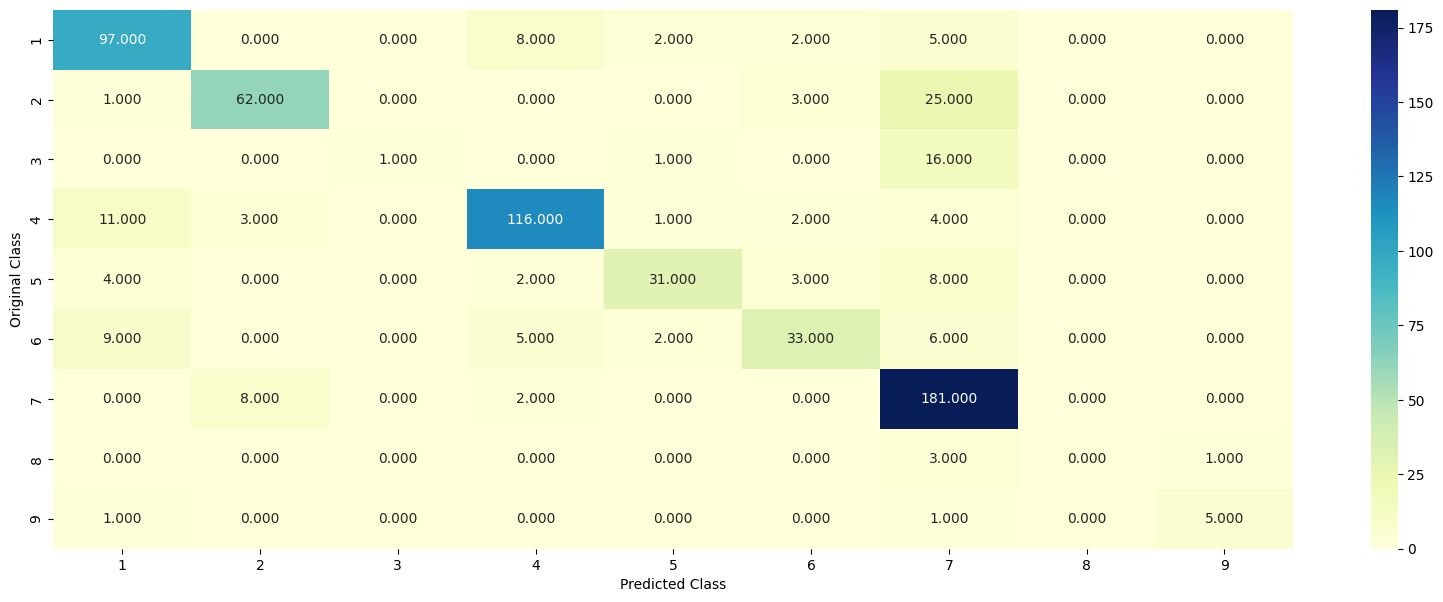

-------------------- Precision matrix (Columm Sum=1) --------------------


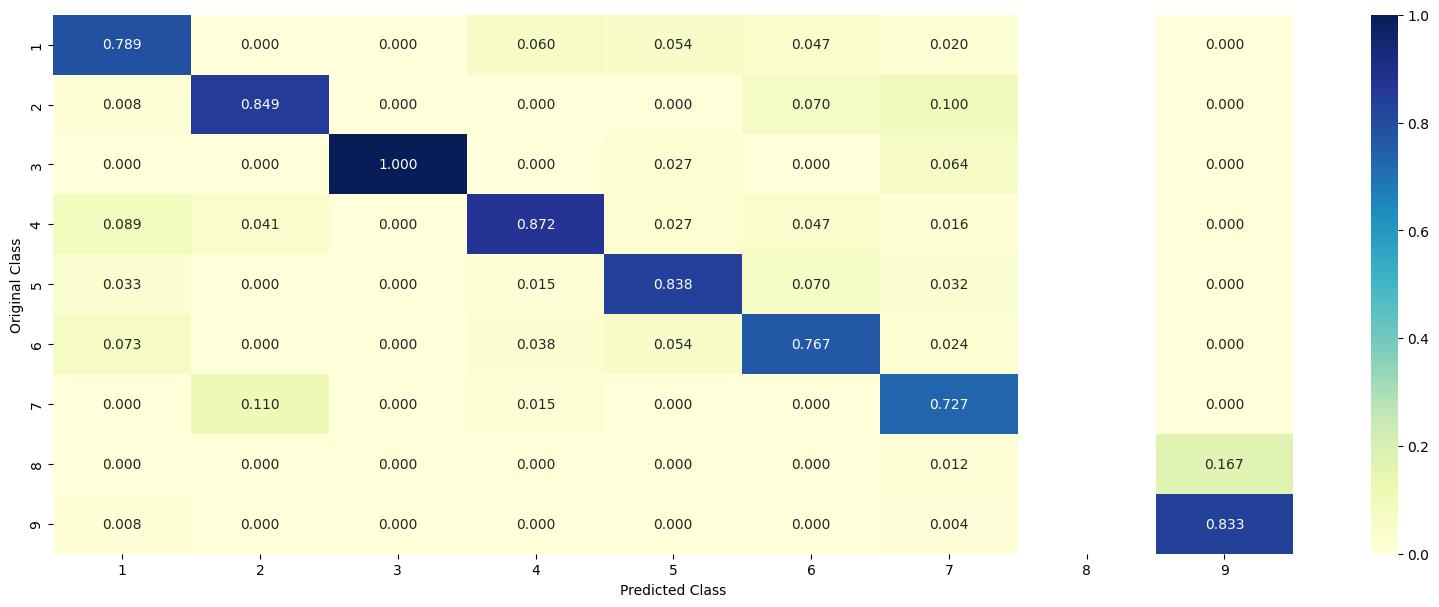

-------------------- Recall matrix (Row sum=1) --------------------


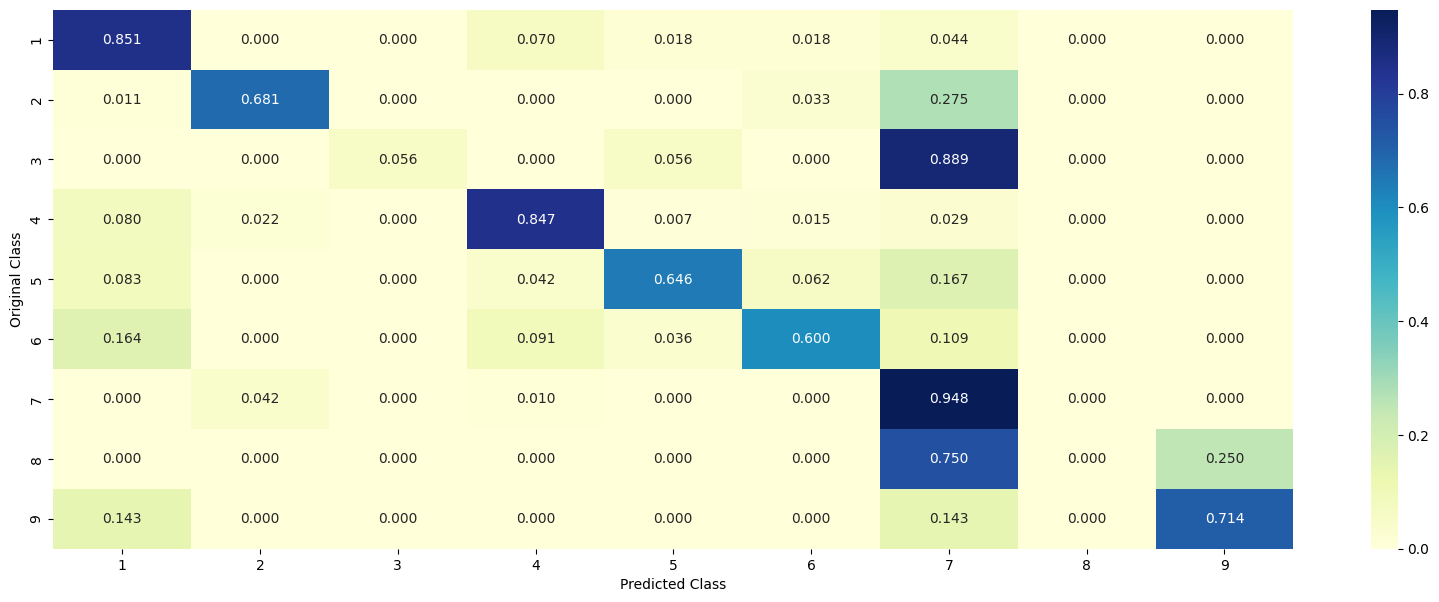

In [927]:
from sklearn.ensemble import VotingClassifier
trained_base_classifiers = [('sig_clf1', sig_clf1), ('sig_clf2', sig_clf2), ('sig_clf3', sig_clf3)]

# Create the stacking classifier with the trained base classifiers
vclf = VotingClassifier(estimators=trained_base_classifiers, voting='soft') # soft means we will use probabilities

# Make predictions (probabilities) on the training data using the base classifiers
base_predictions = []
predict_y1 = sig_clf1.predict_proba(train_x_onehotCoding)
predict_y2 = sig_clf2.predict_proba(train_x_responseCoding)
predict_y3 = sig_clf3.predict_proba(train_x_responseCoding)

# Stack the base predictions horizontally
base_predictions = np.hstack((predict_y1, predict_y2, predict_y3))

# Fit the stacking classifier using the base predictions
vclf.fit(base_predictions, y_train)

# Make predictions (probabilities) on the test data using the base classifiers
test_base_predictions = []
predict_y1 = sig_clf1.predict_proba(test_x_onehotCoding)
predict_y2 = sig_clf2.predict_proba(test_x_responseCoding)
predict_y3 = sig_clf3.predict_proba(test_x_responseCoding)

# Stack the test base predictions horizontally
test_base_predictions = np.hstack((predict_y1, predict_y2, predict_y3))
predictions = vclf.predict_proba(test_base_predictions)
print("Log loss (test) on the VotingClassifier :",log_loss(y_test, predictions, labels=np.unique(y_train), eps=1e-15))
print("Number of missclassified point :", np.count_nonzero((vclf.predict(test_base_predictions)- y_test))/y_test.shape[0])
plot_confusion_matrix(test_y=y_test ,predict_y=vclf.predict(test_base_predictions))

# Our Best Model is Logistic Regression (Balanced + Elasticnet) using Response coding

In [929]:
clf = SGDClassifier(class_weight='balanced', alpha=0.000001, penalty='elasticnet', loss='log', random_state=41)
sig_clf2 = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf2.fit(train_x_responseCoding, y_train)


predict_y = sig_clf2.predict_proba(train_x_responseCoding)
train_loss=log_loss(y_train, predict_y, labels=np.unique(y_train), eps=1e-15)
print( "The train log loss is:",train_loss)
predict_y = sig_clf2.predict_proba(cv_x_responseCoding)
cv_loss=log_loss(y_cv, predict_y, labels=np.unique(y_train), eps=1e-15)
print( "The cross validation log loss is:",cv_loss)
predict_y = sig_clf2.predict_proba(test_x_responseCoding)
test_loss=log_loss(y_test, predict_y, labels=np.unique(y_train), eps=1e-15)
print("The test log loss is:",test_loss)

The train log loss is: 0.3400383074152097
The cross validation log loss is: 0.5664150864327611
The test log loss is: 0.542394014481213


Number of missclassified point : 0.14736842105263157
-------------------- Confusion matrix --------------------


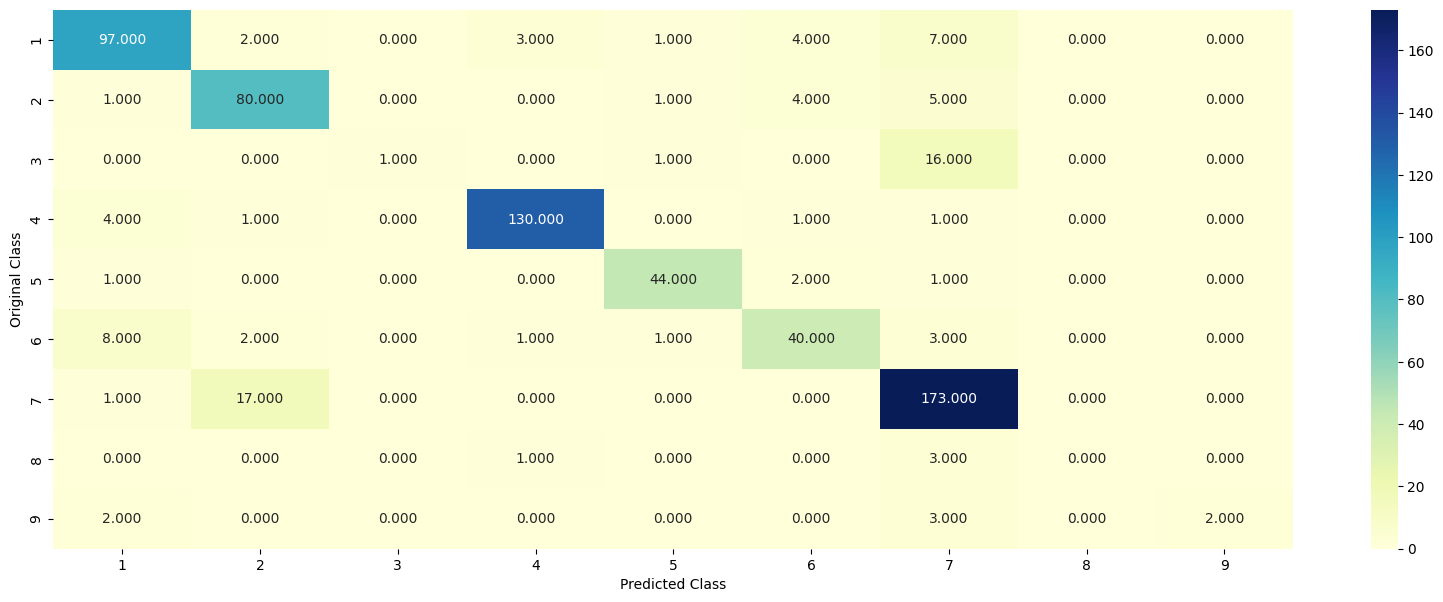

-------------------- Precision matrix (Columm Sum=1) --------------------


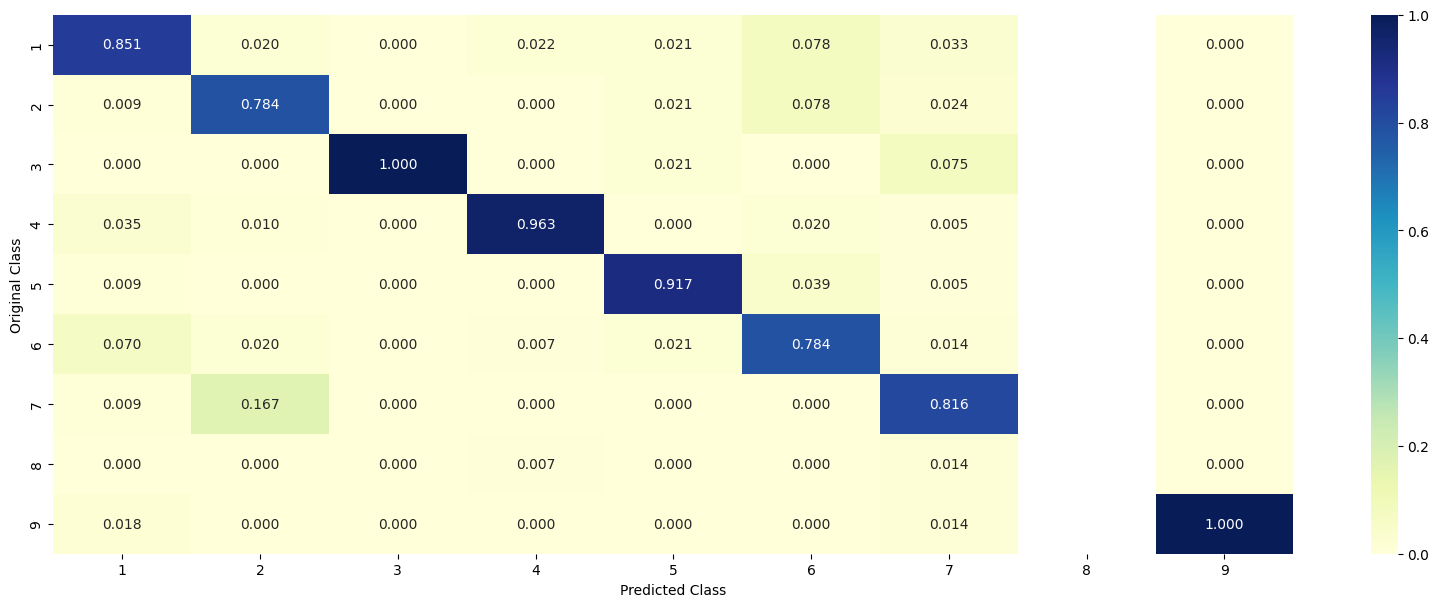

-------------------- Recall matrix (Row sum=1) --------------------


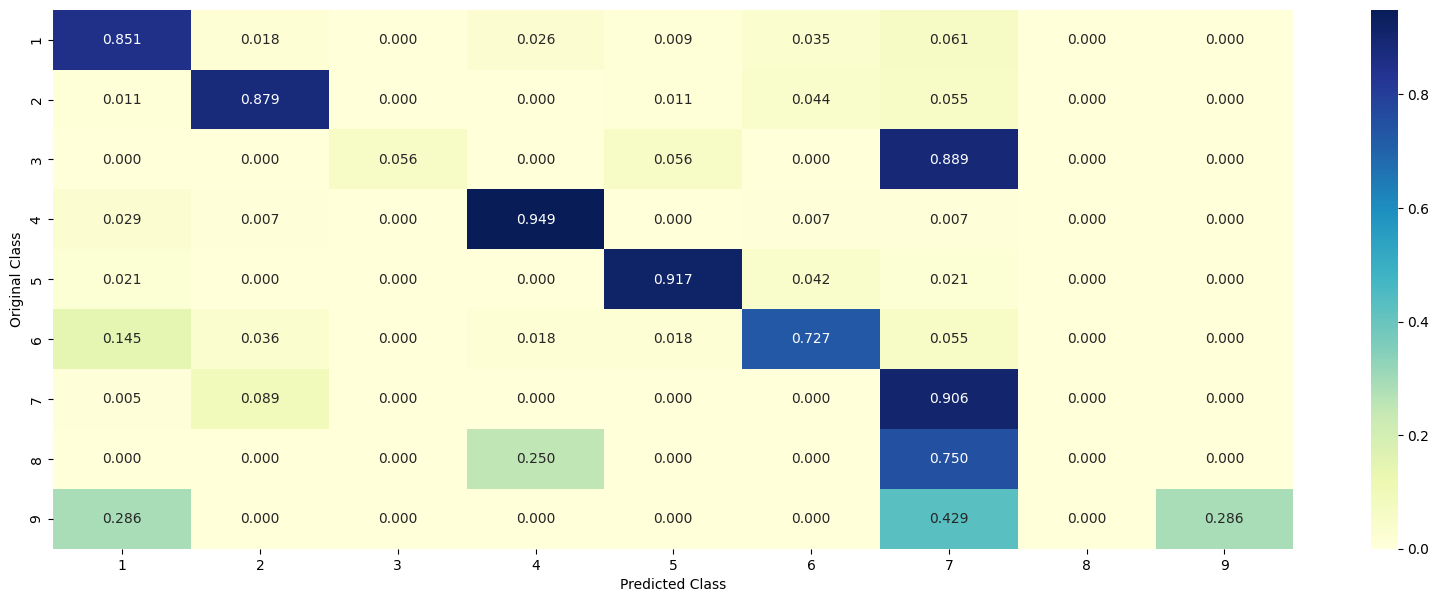

In [930]:
print("Number of missclassified point :", np.count_nonzero((sig_clf2.predict(test_x_responseCoding)- y_test))/y_test.shape[0])
plot_confusion_matrix(test_y=y_test ,predict_y=sig_clf2.predict(test_x_responseCoding))

## Feature Importance

In [117]:
sig_clf = SGDClassifier(class_weight='balanced', alpha=0.000001, penalty='elasticnet', loss='log', random_state=41)
sig_clf.fit(train_x_responseCoding, y_train)
test_point_index = 1
no_feature = 500
predicted_cls = sig_clf.predict(test_x_responseCoding[test_point_index].reshape(1,-1))
print("Predicted Class :", predicted_cls[0])
print("Predicted Class Probabilities:", np.round(sig_clf.predict_proba(test_x_responseCoding[test_point_index].reshape(1,-1)),4))
print("Actual Class :", y_test[test_point_index])

indices = np.argsort(-1*abs(sig_clf.coef_))[predicted_cls-1][:,:no_feature]

print("-"*50)

Predicted Class : 7
Predicted Class Probabilities: [[6.900e-02 5.110e-02 0.000e+00 0.000e+00 3.420e-02 3.000e-04 8.453e-01
  0.000e+00 0.000e+00]]
Actual Class : 7
--------------------------------------------------
